Authors: Charlie Moffett and Andrew Nell, NYU CUSP, 2017

# Basemapping Exercise for Team 3 Project in Civic Analytics

# NB TEAM NOTE: This takes ages to run with geopandas. BE CAREFUL trying to rerun. I have exported output data set and saved on google drive. 

## In order to assess our definition of flood resilience for buildings in the NYC flood zone(s), we want to first join PLUTO and DOB construction permits to Building Footprints

In [746]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pylab as plt
%matplotlib inline

import os

from fiona.crs import from_epsg

# Import and Process Building Footprints Data

In [1174]:
###############################################################################
# Read in Building Footprints 
Footprintsshp = gpd.GeoDataFrame.from_file('BuildingFootprintsNYC/geo_export'\
                                           '_903c37dd-3813-4e4e-a6fd-61e30cd'\
                                           'ce535.shp')
Footprintsshp.bin = Footprintsshp.bin.astype(int).astype(str)

NameError: name 'geometry' is not defined

In [748]:
Footprintsshp.shape

(1082693, 14)

In [749]:
Footprintsshp.head()

feat_code  doitt_id  cnstrct_yr  date_lstmo    time_lstmo   lststatype  \
0     2100.0  939203.0      2001.0  2017-08-22  00:00:00.000  Constructed   
1     2100.0  107990.0      1938.0  2017-08-22  00:00:00.000  Constructed   
2     5110.0  931167.0      1920.0  2017-08-17  00:00:00.000  Constructed   
3     2100.0   86053.0         0.0  2013-09-19  00:00:00.000  Constructed   
4     2100.0  998592.0      2004.0  2017-08-22  00:00:00.000  Constructed   

    shape_len      bin  groundelev  heightroof  name   shape_area         bbl  \
0  169.940373  4462384         6.0   26.528549  None  1768.567205  4155980564   
1  148.987698  4467306         8.0   17.947245  None  1105.077843  4163500400   
2   80.661670  4529256         6.0   14.242061  None   402.928037  4160290023   
3  108.680772  4540232        16.0   14.529231  None   668.812178  4163250001   
4  146.076029  4530675         7.0   42.447070  None  1094.409581  4160900043   

                                            geometry  
0  POLYGON ((-73.74251376378085 40.59908599695821...  
1  POLYGON ((-73.9209069239085 40.55836935121037,...  
2  POLYGON ((-73.79828818376016 40.59816639370658...  
3  POLYGON ((-73.87742893628622 40.56522339103481...  
4  POLYGON ((-73.8033513244464 40.58942758198572,...

In [750]:
# Check how many unique BBL there are. This suggests there are some buildings with the same BBL but not BIN
UniqueBBL = Footprintsshp.bbl.unique()
UniqueBIN = Footprintsshp.bin.unique()
UniqueDOITT = Footprintsshp.doitt_id.unique()
print(len(UniqueBBL),len(UniqueBIN),len(UniqueDOITT))

(815554, 1082556, 1082693)


Although BIN is not unique there are much more overlapping BBLs. So we should merge data on BIN. DOITT ID only exists in this data set, however is the most unique variable 

In [751]:
Footprintsshp.columns

Index([ u'feat_code',   u'doitt_id', u'cnstrct_yr', u'date_lstmo',
       u'time_lstmo', u'lststatype',  u'shape_len',        u'bin',
       u'groundelev', u'heightroof',       u'name', u'shape_area',
              u'bbl',   u'geometry'],
      dtype='object')

In [752]:
Footprintsshp.crs

{'init': u'epsg:4326'}

In [753]:
Footprintsshp.geometry.head()

0    POLYGON ((-73.74251376378085 40.59908599695821...
1    POLYGON ((-73.9209069239085 40.55836935121037,...
2    POLYGON ((-73.79828818376016 40.59816639370658...
3    POLYGON ((-73.87742893628622 40.56522339103481...
4    POLYGON ((-73.8033513244464 40.58942758198572,...
Name: geometry, dtype: object

In [754]:
# Convert to foot coordinates in smaller space for merging
Footprintsshp_ft = Footprintsshp.to_crs(epsg=2263)

In [755]:
Footprintsshp_ft.crs

{'init': 'epsg:2263', 'no_defs': True}

In [756]:
Footprintsshp_ft.geometry.head()

0    POLYGON ((1055753.964263395 157644.6762304076,...
1    POLYGON ((1006227.581032902 142715.4199997431,...
2    POLYGON ((1040266.202588066 157269.0454199966,...
3    POLYGON ((1018305.302284227 145226.4176024057,...
4    POLYGON ((1038867.297249392 154082.085258486, ...
Name: geometry, dtype: object

In [757]:
Footprintsshp_ft.head()

feat_code  doitt_id  cnstrct_yr  date_lstmo    time_lstmo   lststatype  \
0     2100.0  939203.0      2001.0  2017-08-22  00:00:00.000  Constructed   
1     2100.0  107990.0      1938.0  2017-08-22  00:00:00.000  Constructed   
2     5110.0  931167.0      1920.0  2017-08-17  00:00:00.000  Constructed   
3     2100.0   86053.0         0.0  2013-09-19  00:00:00.000  Constructed   
4     2100.0  998592.0      2004.0  2017-08-22  00:00:00.000  Constructed   

    shape_len      bin  groundelev  heightroof  name   shape_area         bbl  \
0  169.940373  4462384         6.0   26.528549  None  1768.567205  4155980564   
1  148.987698  4467306         8.0   17.947245  None  1105.077843  4163500400   
2   80.661670  4529256         6.0   14.242061  None   402.928037  4160290023   
3  108.680772  4540232        16.0   14.529231  None   668.812178  4163250001   
4  146.076029  4530675         7.0   42.447070  None  1094.409581  4160900043   

                                            geometry  
0  POLYGON ((1055753.964263395 157644.6762304076,...  
1  POLYGON ((1006227.581032902 142715.4199997431,...  
2  POLYGON ((1040266.202588066 157269.0454199966,...  
3  POLYGON ((1018305.302284227 145226.4176024057,...  
4  POLYGON ((1038867.297249392 154082.085258486, ...

# Import Flood Zone Data

NB if you are running this code for the first time, remember to change the name of a file in the shapefile (S_FLD_HAZ_AR.prj to s_fld_haz_ar.prj)

In [758]:
# Read into dataframe
FloodPlain = gpd.read_file('FloodZoneShape/s_fld_haz_ar.shp')

In [759]:
FloodPlain.head()

FLD_AR_ID                            FLD_ZONE FLOODWAY SFHA_TF  STATIC_BFE  \
0        81                                  AE     None       T        13.0   
1        82                                   X     None       F     -9999.0   
2        83  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     None       F     -9999.0   
3        84  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     None       F     -9999.0   
4        85  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     None       F     -9999.0   

  V_DATUM   DEPTH LEN_UNIT  VELOCITY VEL_UNIT AR_REVERT  BFE_REVERT  \
0  NAVD88 -9999.0     FEET   -9999.0     None      None     -9999.0   
1    None -9999.0     None   -9999.0     None      None     -9999.0   
2    None -9999.0     None   -9999.0     None      None     -9999.0   
3    None -9999.0     None   -9999.0     None      None     -9999.0   
4    None -9999.0     None   -9999.0     None      None     -9999.0   

   DEP_REVERT SOURCE_CIT                                           geometry  
0     -9999.0     STUDY4  POLYGON ((1032001.690901905 263867.8387837261,...  
1     -9999.0     STUDY4  POLYGON ((1033748.951514989 263778.4642905593,...  
2     -9999.0     STUDY4  POLYGON ((1033309.701081157 263544.1806384027,...  
3     -9999.0     STUDY4  POLYGON ((1033414.147722661 262658.8677764833,...  
4     -9999.0     STUDY4  POLYGON ((1034089.115204751 262466.0338445604,...

In [760]:
FloodPlain.columns

Index([ u'FLD_AR_ID',   u'FLD_ZONE',   u'FLOODWAY',    u'SFHA_TF',
       u'STATIC_BFE',    u'V_DATUM',      u'DEPTH',   u'LEN_UNIT',
         u'VELOCITY',   u'VEL_UNIT',  u'AR_REVERT', u'BFE_REVERT',
       u'DEP_REVERT', u'SOURCE_CIT',   u'geometry'],
      dtype='object')

In [761]:
FloodPlain.drop(['FLOODWAY','SFHA_TF','V_DATUM',
                 'DEPTH','LEN_UNIT','VELOCITY',
                 'VEL_UNIT','AR_REVERT','BFE_REVERT',
                 'DEP_REVERT','SOURCE_CIT'],
                axis=1,inplace=True)

In [762]:
FloodPlain.shape

(3985, 4)

In [763]:
FloodPlain.crs

{u'datum': u'NAD83',
 u'lat_0': 40.16666666666666,
 u'lat_1': 40.66666666666666,
 u'lat_2': 41.03333333333333,
 u'lon_0': -74,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'us-ft',
 u'x_0': 300000,
 u'y_0': 0}

In [764]:
FloodPlain.geometry.head()

0    POLYGON ((1032001.690901905 263867.8387837261,...
1    POLYGON ((1033748.951514989 263778.4642905593,...
2    POLYGON ((1033309.701081157 263544.1806384027,...
3    POLYGON ((1033414.147722661 262658.8677764833,...
4    POLYGON ((1034089.115204751 262466.0338445604,...
Name: geometry, dtype: object

In [765]:
# Convert to foot coordinates in smaller space for merging
FloodPlain_ft = FloodPlain.to_crs(epsg=2263)

In [766]:
FloodPlain_ft.crs

{'init': 'epsg:2263', 'no_defs': True}

In [767]:
FloodPlain_ft.geometry.head()

0    POLYGON ((1032001.690901907 263867.8387958121,...
1    POLYGON ((1033748.95151499 263778.4643026471, ...
2    POLYGON ((1033309.701081156 263544.1806504956,...
3    POLYGON ((1033414.147722664 262658.8677885717,...
4    POLYGON ((1034089.115204753 262466.0338566509,...
Name: geometry, dtype: object

In [768]:
FloodPlain_ft.head()

FLD_AR_ID                            FLD_ZONE  STATIC_BFE  \
0        81                                  AE        13.0   
1        82                                   X     -9999.0   
2        83  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     -9999.0   
3        84  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     -9999.0   
4        85  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     -9999.0   

                                            geometry  
0  POLYGON ((1032001.690901907 263867.8387958121,...  
1  POLYGON ((1033748.95151499 263778.4643026471, ...  
2  POLYGON ((1033309.701081156 263544.1806504956,...  
3  POLYGON ((1033414.147722664 262658.8677885717,...  
4  POLYGON ((1034089.115204753 262466.0338566509,...

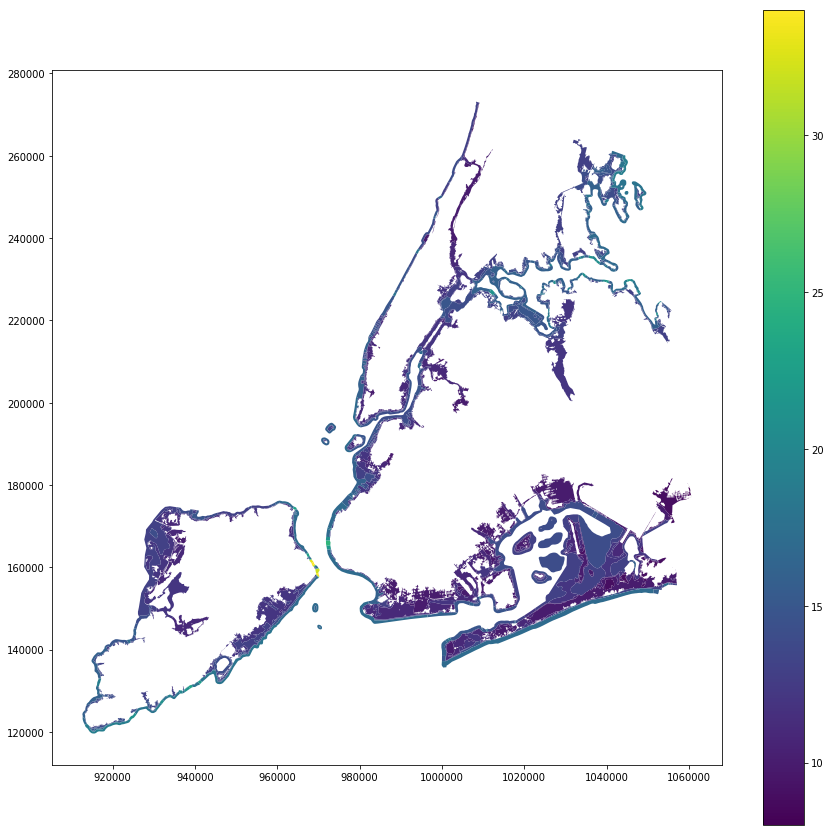

In [769]:
FloodPlain[(FloodPlain['FLD_ZONE']<>'X') & (FloodPlain['STATIC_BFE']>0) ].plot(column='STATIC_BFE', cmap='viridis', legend=True, figsize=(15,15))

# Import Base Map of NYC boroughs to use to provide context

In [770]:
baseboro = gpd.read_file('NYC_Boroughs_shape/nybb_17c/nybb.shp')

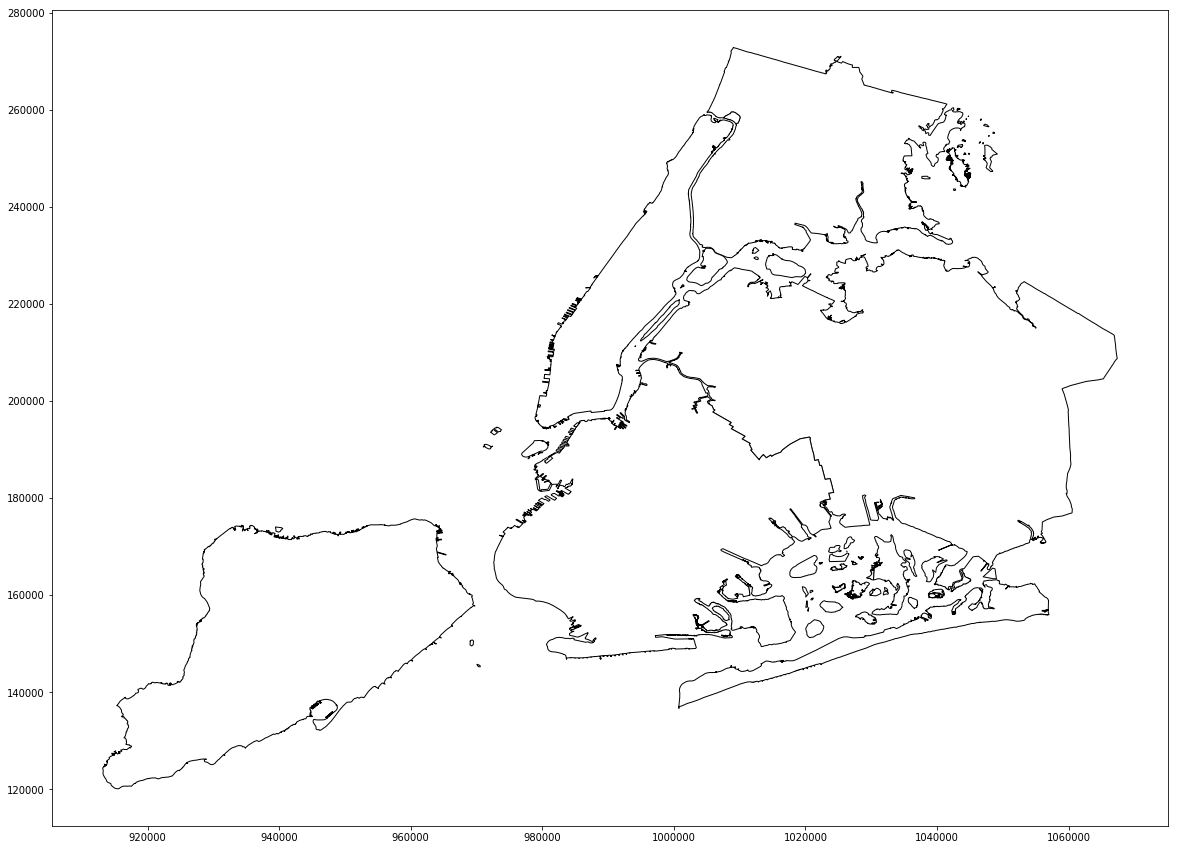

In [771]:
fig,ax = plt.subplots(figsize=(20,15))
baseboro.plot(color='white',edgecolor='black', ax=ax)

#### Figure 1: Base Map of Boroughs

# Merge Footprints and Flood Plain shape files

In [772]:
FloodFootprints = gpd.sjoin(Footprintsshp_ft,FloodPlain_ft,how='inner',op='within')

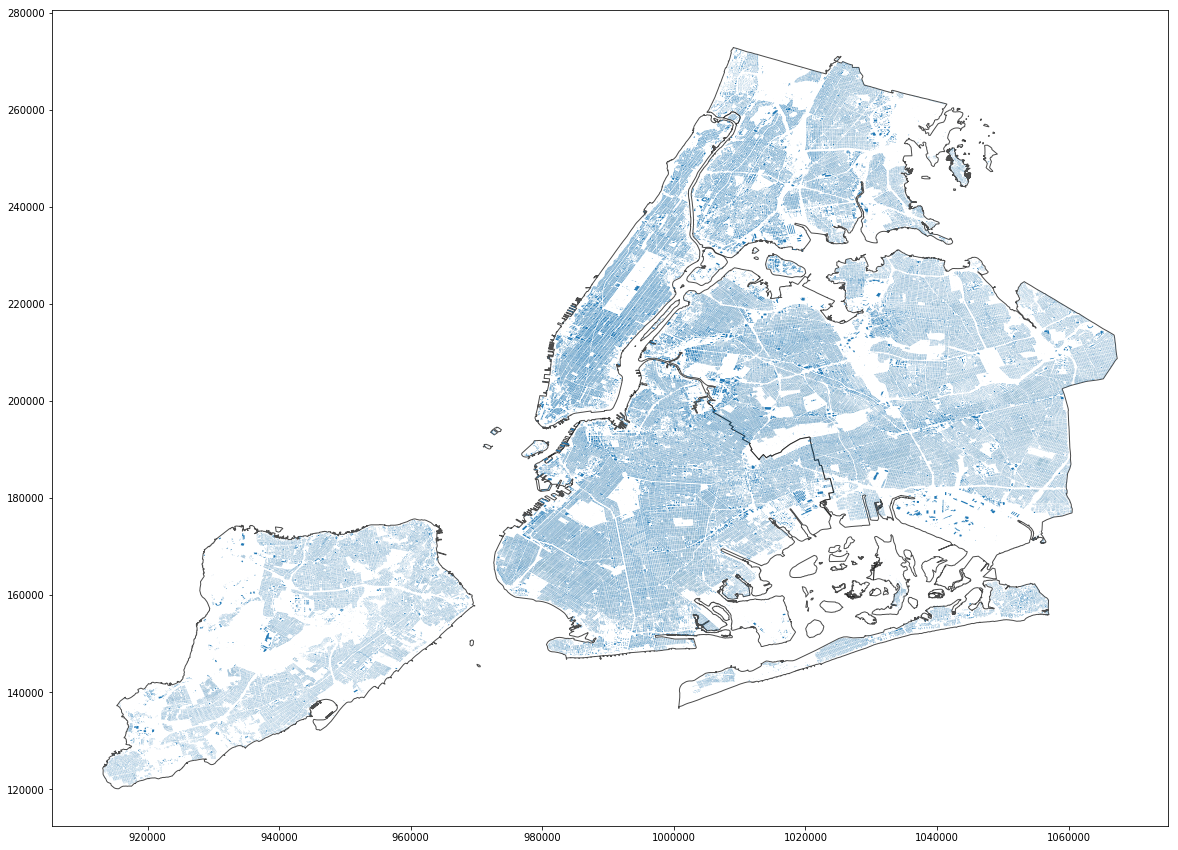

In [773]:
fig,ax = plt.subplots(figsize=(20,15))
baseboro.plot(color='white',edgecolor='black', ax=ax, alpha=0.7)
# Check data plots as building footprints
# Plot geometry
FloodFootprints.geometry.plot(ax=ax)

In [774]:
FloodFootprints.head()

feat_code   doitt_id  cnstrct_yr  date_lstmo    time_lstmo  \
92453       2100.0  1027609.0      1942.0  2014-07-18  00:00:00.000   
990452      5110.0   690460.0      1942.0  2017-08-22  00:00:00.000   
925629      5110.0   802971.0      1958.0  2017-08-22  00:00:00.000   
1043066     5110.0  1213686.0      1939.0  2017-08-17  00:00:00.000   
834332      2100.0     5536.0      1939.0  2014-07-18  00:00:00.000   

          lststatype   shape_len      bin  groundelev  heightroof  name  \
92453    Constructed  140.613918  2095149        11.0   28.240000  None   
990452   Constructed   87.980887  2095150        12.0   13.450000  None   
925629   Constructed   93.942063  2067198        11.0    9.140000  None   
1043066  Constructed  154.362244  2122779         8.0   24.090089  None   
834332   Constructed   99.898544  2122777         7.0   16.921271  None   

          shape_area         bbl  \
92453    1234.040914  2049740070   
990452    480.511093  2049740070   
925629    551.569563  2049740088   
1043066  1414.079693  2049740120   
834332    615.814960  2049740120   

                                                  geometry  index_right  \
92453    POLYGON ((1032115.225779818 263604.5643758191,...            0   
990452   POLYGON ((1032062.329888226 263689.7298879102,...            0   
925629   POLYGON ((1032068.150086567 263717.9001071612,...            0   
1043066  POLYGON ((1032579.20024556 263473.6955430705, ...            0   
834332   POLYGON ((1032529.851919053 263300.492805499, ...            0   

        FLD_AR_ID FLD_ZONE  STATIC_BFE  
92453          81       AE        13.0  
990452         81       AE        13.0  
925629         81       AE        13.0  
1043066        81       AE        13.0  
834332         81       AE        13.0

In [775]:
# Save original merge for potential later use
FloodFootprintsOG = FloodFootprints

# Check size
FloodFootprints.shape

(1060482, 18)

In [776]:
# Exclude Builings outside Flood Plain
FloodFootprints = FloodFootprints[FloodFootprints.FLD_ZONE <> 'X']

# Check new size
FloodFootprints.shape

(86602, 18)

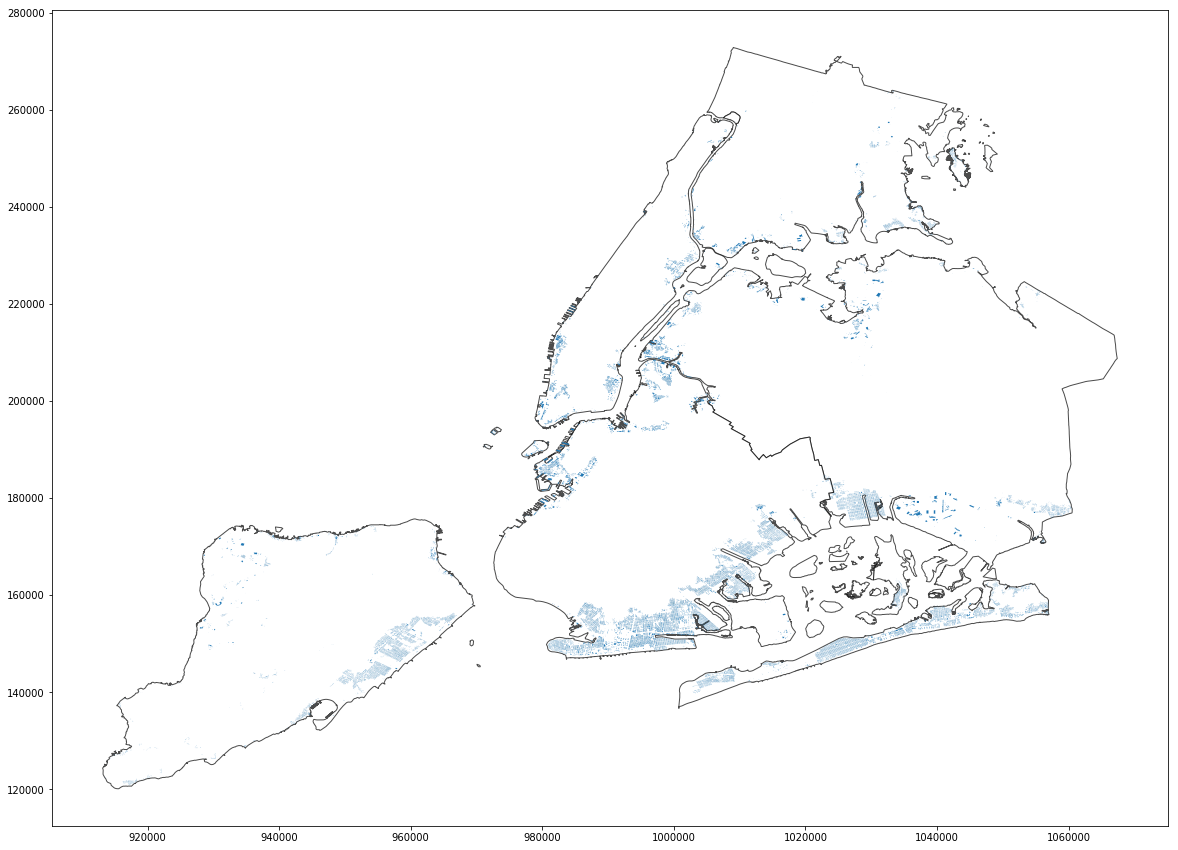

In [777]:
fig,ax = plt.subplots(figsize=(20,15))
baseboro.plot(color='white',edgecolor='black', ax=ax, alpha=0.7)
# Check data plots as building footprints
# Plot geometry
FloodFootprints.geometry.plot(ax=ax)

Looking at the data size reduction, it appears we are only looking at buildings in Flood Zones

# Import and Process Pluto Data for each Borough

In [778]:
# Combine Data 
plutoBK = pd.read_csv('BORO_zip_files_csv/BK.csv')
plutoBX = pd.read_csv('BORO_zip_files_csv/BX.csv')
plutoMN = pd.read_csv('BORO_zip_files_csv/MN.csv')
plutoQN = pd.read_csv('BORO_zip_files_csv/QN.csv')
plutoSI = pd.read_csv('BORO_zip_files_csv/SI.csv')

### Because PLUTO data comes separate for each borough, we're concatentating them here to construct a single PLUTO dataset for all of NYC

In [779]:
###############################################################################
# Concatenate PLUTO data from each of 5 borough into single dataset
pluto = pd.concat([plutoBK, plutoBX, plutoMN, plutoQN, plutoSI]).reset_index()
pluto.shape

(858370, 85)

In [780]:
pluto.head(5)

index Borough  Block   Lot   CD  CT2010  CB2010  SchoolDist  Council  \
0      0      BK      1     1  302    21.0     NaN        13.0     33.0   
1      1      BK      1    50  302    21.0  2000.0        13.0     33.0   
2      2      BK      1  7501  302    21.0  2000.0        13.0     33.0   
3      3      BK      3     1  302    21.0  3002.0        13.0     33.0   
4      4      BK      3     5  302    21.0     NaN        13.0     33.0   

   ZipCode   ...      YCoord  ZoneMap  ZMCode  Sanborn   TaxMap EDesigNum  \
0  11201.0   ...         NaN      12d     NaN  302 007  30101.0       NaN   
1  11201.0   ...    195989.0      12d     NaN  302 007  30101.0     E-231   
2  11201.0   ...    195992.0      12d     NaN  302 007  30101.0       NaN   
3  11201.0   ...    196151.0      12d     NaN  302 007  30101.0       NaN   
4  11201.0   ...         NaN      12d     NaN  302 007  30101.0       NaN   

         APPBBL     APPDate PLUTOMapID Version  
0  3.000010e+09  11/26/2013          1    16V2  
1  0.000000e+00         NaN          1    16V2  
2  3.000010e+09    3/4/2016          1    16V2  
3  0.000000e+00         NaN          1    16V2  
4  0.000000e+00         NaN          4    16V2  

[5 rows x 85 columns]

In [781]:
pluto.columns

Index([u'index', u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010',
       u'SchoolDist', u'Council', u'ZipCode', u'FireComp', u'PolicePrct',
       u'HealthArea', u'SanitBoro', u'SanitDistrict', u'SanitSub', u'Address',
       u'ZoneDist1', u'ZoneDist2', u'ZoneDist3', u'ZoneDist4', u'Overlay1',
       u'Overlay2', u'SPDist1', u'SPDist2', u'SPDist3', u'LtdHeight',
       u'SplitZone', u'BldgClass', u'LandUse', u'Easements', u'OwnerType',
       u'OwnerName', u'LotArea', u'BldgArea', u'ComArea', u'ResArea',
       u'OfficeArea', u'RetailArea', u'GarageArea', u'StrgeArea',
       u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs', u'NumFloors',
       u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', u'BldgFront',
       u'BldgDepth', u'Ext', u'ProxCode', u'IrrLotCode', u'LotType',
       u'BsmtCode', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot',
       u'YearBuilt', u'YearAlter1', u'YearAlter2', u'HistDist', u'Landmark',
       u'BuiltFAR', u'ResidFAR', u'Co

In [782]:
###############################################################################
# Clean data and drop irrelevant columns
pluto.drop(['index','Block','Lot','SchoolDist','Council','ZipCode',
            'FireComp','PolicePrct','HealthArea','SanitBoro', 'SanitDistrict', 
            'SanitSub', 'Address','Overlay1','Overlay2', 'SPDist1', 'SPDist2', 
            'SPDist3', 'Easements', 'IrrLotCode','HistDist', 'Landmark', 
            'CommFAR', 'FacilFAR', 'BoroCode', 'XCoord', 
            'YCoord', 'ZoneMap', 'ZMCode','Sanborn', 'TaxMap', 'EDesigNum', 
            'APPBBL', 'APPDate', 'Version'], axis=1,inplace=True);

In [783]:
# Drop NAs?

In [784]:
# Convert BBL to string
pluto.BBL = pluto.BBL.astype(int).astype(str)

In [785]:
pluto.head()

Borough   CD  CT2010  CB2010 ZoneDist1 ZoneDist2 ZoneDist3 ZoneDist4  \
0      BK  302    21.0     NaN      M3-1  M1-4/R8A       NaN       NaN   
1      BK  302    21.0  2000.0  M1-4/R8A      M3-1       NaN       NaN   
2      BK  302    21.0  2000.0      M3-1       NaN       NaN       NaN   
3      BK  302    21.0  3002.0      M3-1       NaN       NaN       NaN   
4      BK  302    21.0     NaN      M3-1       NaN       NaN       NaN   

  LtdHeight SplitZone     ...     ExemptTot  YearBuilt YearAlter1 YearAlter2  \
0       NaN         Y     ...           0.0          0          0          0   
1       NaN         Y     ...      290250.0       1920       1994       2007   
2       NaN         N     ...           0.0          0          0          0   
3       NaN         N     ...           0.0          0          0          0   
4       NaN         N     ...       21150.0          0          0          0   

   BuiltFAR  ResidFAR         BBL  CondoNo  Tract2010  PLUTOMapID  
0      0.00       0.0  3000010001        0         21           1  
1      7.84       5.4  3000010050        0         21           1  
2      0.00       0.0  3000017501     3819         21           1  
3      0.00       0.0  3000030001        0         21           1  
4      0.00       0.0  3000030005        0         21           4  

[5 rows x 50 columns]

In [786]:
pluto.columns

Index([u'Borough', u'CD', u'CT2010', u'CB2010', u'ZoneDist1', u'ZoneDist2',
       u'ZoneDist3', u'ZoneDist4', u'LtdHeight', u'SplitZone', u'BldgClass',
       u'LandUse', u'OwnerType', u'OwnerName', u'LotArea', u'BldgArea',
       u'ComArea', u'ResArea', u'OfficeArea', u'RetailArea', u'GarageArea',
       u'StrgeArea', u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs',
       u'NumFloors', u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth',
       u'BldgFront', u'BldgDepth', u'Ext', u'ProxCode', u'LotType',
       u'BsmtCode', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot',
       u'YearBuilt', u'YearAlter1', u'YearAlter2', u'BuiltFAR', u'ResidFAR',
       u'BBL', u'CondoNo', u'Tract2010', u'PLUTOMapID'],
      dtype='object')

In [787]:
sorted(pluto.NumFloors.unique())

[0.0,
 0.5,
 1.0,
 1.01,
 1.1000000000000001,
 1.1499999999999999,
 1.1699999999999999,
 1.2,
 1.25,
 1.3300000000000001,
 1.3500000000000001,
 1.3999999999999999,
 1.5,
 1.6000000000000001,
 1.6499999999999999,
 1.6599999999999999,
 1.6699999999999999,
 1.7,
 1.75,
 1.76,
 1.78,
 1.8,
 1.8500000000000001,
 1.8700000000000001,
 1.8999999999999999,
 1.99,
 2.0,
 2.1000000000000001,
 2.2000000000000002,
 2.25,
 2.2999999999999998,
 2.3300000000000001,
 2.3999999999999999,
 2.4500000000000002,
 2.5,
 2.5499999999999998,
 2.6000000000000001,
 2.6600000000000001,
 2.6699999999999999,
 2.7000000000000002,
 2.75,
 2.77,
 2.7999999999999998,
 2.8500000000000001,
 2.8700000000000001,
 2.8999999999999999,
 2.9900000000000002,
 3.0,
 3.25,
 3.2999999999999998,
 3.3199999999999998,
 3.3300000000000001,
 3.3999999999999999,
 3.5,
 3.6000000000000001,
 3.6699999999999999,
 3.75,
 4.0,
 4.25,
 4.2999999999999998,
 4.3300000000000001,
 4.5,
 4.75,
 5.0,
 5.0899999999999999,
 5.25,
 5.5,
 5.75,
 6.0,
 

In [1054]:
pluto.groupby('LandUse').count()['PLUTOMapID']

LandUse
1.0     565321
2.0     130774
3.0      12352
4.0      51912
5.0      22241
6.0      11113
7.0       4162
8.0      12215
9.0       5058
10.0     12454
11.0     27737
Name: PLUTOMapID, dtype: int64

# Import and clean DOB permit applications data from DOB open NYC

In [788]:
# Read in DOB Job Application Filings
DOBapps = pd.read_csv('DOBapps.csv', 
                      dtype={'Block': object,'Lot': object,
                             'Bin #':object})
DOBapps.shape

(323325, 82)

In [789]:
DOBapps.head(5)

Job #  Doc #        Borough       House #  \
0  121577873      2      MANHATTAN  386            
1  520129502      1  STATEN ISLAND  107            
2  121601560      1      MANHATTAN  63             
3  121601203      1      MANHATTAN  48             
4  121601338      1      MANHATTAN  45             

                        Street Name  Block    Lot    Bin # Job Type  \
0  PARK AVENUE SOUTH                 00857  00038  1016890       A2   
1  KNOX PLACE                        00342  00001  5161350       A3   
2  WEST 131 STREET                   01729  00009  1053831       A2   
3  WEST 25TH STREET                  00826  00069  1015610       A2   
4  WEST 29 STREET                    00831  00007  1015754       A3   

  Job Status           ...                         Owner's Last Name  \
0          D           ...            MIGLIORE                         
1          A           ...            BLUMENBERG                       
2          Q           ...            MARKOWITZ                        
3          D           ...            CASALE                           
4          D           ...            LEE                              

              Owner's Business Name Owner's House Number  \
0  MACKLOWE MANAGEMENT                      126            
1  NA                                       107            
2  635 RIVERSIDE DRIVE NY LLC               619            
3  48 W 25 ST LLC C/O BERNSTEIN             150            
4  HYUNG-HYANG REALTY CORP                  614            

           Owner'sHouse Street Name            City  State    Zip  \
0  EAST 56TH STREET                  NEW YORK           NY  10222   
1  KNOX PLACE                        STATEN ISLAND      NY  10314   
2  WEST 54TH STREET                  NEW YORK           NY  10016   
3  WEST 30TH STREET                  NEW YORK           NY  10001   
4  8 AVENUE                          NEW YORK           NY  10001   

  Owner'sPhone #                                    Job Description  \
0     2125545837  GENERAL MECHANICAL & PLUMBING MODIFICATIONS AS...   
1     3477398892  BUILDERS PAVEMENT PLAN 143 LF.                ...   
2     2127652555  GENERAL CONSTRUCTION TO INCLUDE NEW PARTITIONS...   
3     2125941414  STRUCTURAL CHANGES ON THE 5TH FLOOR (MOONDOG E...   
4     2019881222  FILING HEREWITH FACADE REPAIR PLANS. WORK SCOP...   

               DOBRunDate  
0  04/26/2013 12:00:00 AM  
1  04/26/2013 12:00:00 AM  
2  04/26/2013 12:00:00 AM  
3  04/26/2013 12:00:00 AM  
4  04/26/2013 12:00:00 AM  

[5 rows x 82 columns]

In [790]:
DOBapps.columns

Index([u'Job #', u'Doc #', u'Borough', u'House #', u'Street Name', u'Block',
       u'Lot', u'Bin #', u'Job Type', u'Job Status', u'Job Status Descrp',
       u'Latest Action Date', u'Building Type', u'Community - Board',
       u'Cluster', u'Landmarked', u'Adult Estab', u'Loft Board', u'City Owned',
       u'Little e', u'PC Filed', u'eFiling Filed', u'Plumbing', u'Mechanical',
       u'Boiler', u'Fuel Burning', u'Fuel Storage', u'Standpipe', u'Sprinkler',
       u'Fire Alarm', u'Equipment', u'Fire Suppression', u'Curb Cut', u'Other',
       u'Other Description', u'Applicant's First Name',
       u'Applicant's Last Name', u'Applicant Professional Title',
       u'Applicant License #', u'Professional Cert', u'Pre- Filing Date',
       u'Paid', u'Fully Paid', u'Assigned', u'Approved', u'Fully Permitted',
       u'Initial Cost', u'Total Est. Fee', u'Fee Status',
       u'Existing Zoning Sqft', u'Proposed Zoning Sqft', u'Horizontal Enlrgmt',
       u'Vertical Enlrgmt', u'Enlargement SQ Foo

In [791]:
###############################################################################
# Drop irrelevant columns
DOBapps.drop(['Job #', 'Doc #','Street Name', 'House #','Job Status', 
              'Community - Board','Cluster', 'Landmarked', 'Adult Estab',
              'Loft Board', 'Little e', 'PC Filed', 'eFiling Filed', 'Plumbing', 
              'Mechanical','Boiler', 'Fuel Burning', 'Fuel Storage', 
              'Standpipe', 'Sprinkler','Fire Alarm', 'Equipment', 
              'Fire Suppression', 'Curb Cut', 'Other', 
              "Applicant's First Name","Applicant's Last Name", 
              'Applicant Professional Title', 'Professional Cert', 
              'Pre- Filing Date','Paid', 'Fully Paid', 
              'Assigned', 'Fully Permitted','Initial Cost', 
              'Total Est. Fee', 'Fee Status','Existing Zoning Sqft', 
              'Proposed Zoning Sqft', 'Horizontal Enlrgmt','Vertical Enlrgmt', 
              'Enlargement SQ Footage', 'Street Frontage',
              'Site Fill', 'Zoning Dist1', 
              'Zoning Dist2','Zoning Dist3', 'Special District 1', 
              'Special District 2','Owner Type', 'Non-Profit', 
              "Owner's First Name","Owner's Last Name", "Owner's Business Name", 
              "Owner's House Number","Owner'sHouse Street Name", 'City ', 
              'State','Zip',"Owner'sPhone #"],
             axis=1, inplace=True);

In [792]:
# Here we're mapping a digit to each borough name to replicate BBL format
DOBapps['num_boro'] = DOBapps['Borough'].map({'BRONX':'2','BROOKLYN':"3",
                                              'MANHATTAN':'1','STATEN ISLAND':'5',
                                              'QUEENS':'4'})
DOBapps.tail(2)

Borough  Block    Lot    Bin # Job Type  \
323323    QUEENS  07314  00033  4156906       A2   
323324  BROOKLYN  00879  00003  3017069       A2   

                      Job Status Descrp Latest Action Date Building Type  \
323323  PERMIT ISSUED - ENTIRE JOB/WORK         11/08/2017         OTHER   
323324   APPLICATION PROCESSED - ENTIRE         11/08/2017         OTHER   

       City Owned Other Description   ...    Proposed No. of Stories  \
323323        NaN      GEN. CONSTR.   ...                        2.0   
323324        NaN               NaN   ...                        2.0   

       Existing Height  Proposed Height  Existing Dwelling Units  \
323323            28.0             28.0                      NaN   
323324            20.0             20.0                        1   

        Proposed Dwelling Units  Existing Occupancy Proposed Occupancy  \
323323                      NaN                 PUB                PUB   
323324                        1                 COM                COM   

                                          Job Description  \
323323  INSTALLATION OF PARTITION FOR NEW BOILER, INCL...   
323324  INSTALLATION OF AUTOMATIC FIRE SUPPRESSION SYS...   

                    DOBRunDate num_boro  
323323  11/09/2017 12:00:00 AM        4  
323324  11/09/2017 12:00:00 AM        3  

[2 rows x 23 columns]

In [793]:
# Create BBL column by combining Borough, Block and Lot Numbers
DOBapps["BBL"] = DOBapps['num_boro']+DOBapps["Block"]+DOBapps["Lot"].str[1:]
DOBapps.drop(['Block','num_boro','Lot','Borough'],axis=1,inplace=True)
DOBapps.head(5)

Bin # Job Type                         Job Status Descrp  \
0  1016890       A2  APPLICATION PROCESSED - ENTIRE             
1  5161350       A3  PRE-FILING                                 
2  1053831       A2  PERMIT ISSUED - PARTIAL JOB                
3  1015610       A2  APPLICATION PROCESSED - ENTIRE             
4  1015754       A3  APPLICATION PROCESSED - ENTIRE             

  Latest Action Date Building Type City Owned Other Description  \
0         04/25/2013         OTHER        NaN                     
1         04/25/2013  1-2-3 FAMILY        NaN   BPP               
2         04/25/2013         OTHER        NaN   GEN. CONSTR.      
3         04/25/2013         OTHER        NaN   STRUCTURAL        
4         04/25/2013         OTHER        NaN   GEN. CONSTR.      

  Applicant License #    Approved  ExistingNo. of Stories  \
0             0058375         NaN                     0.0   
1             0025259         NaN                     0.0   
2             0084178  04/25/2013                     5.0   
3             0078226         NaN                    12.0   
4             0086781         NaN                     6.0   

   Proposed No. of Stories  Existing Height  Proposed Height  \
0                      0.0              0.0              0.0   
1                      0.0              0.0              0.0   
2                      5.0             54.0             54.0   
3                     12.0            120.0            120.0   
4                      6.0             64.0             64.0   

  Existing Dwelling Units Proposed Dwelling Units Existing Occupancy  \
0                                                                      
1                                                                      
2                      20                      20               RES    
3                                                               E      
4                                                               COM    

  Proposed Occupancy                                    Job Description  \
0                     GENERAL MECHANICAL & PLUMBING MODIFICATIONS AS...   
1                     BUILDERS PAVEMENT PLAN 143 LF.                ...   
2               RES   GENERAL CONSTRUCTION TO INCLUDE NEW PARTITIONS...   
3               E     STRUCTURAL CHANGES ON THE 5TH FLOOR (MOONDOG E...   
4               COM   FILING HEREWITH FACADE REPAIR PLANS. WORK SCOP...   

               DOBRunDate         BBL  
0  04/26/2013 12:00:00 AM  1008570038  
1  04/26/2013 12:00:00 AM  5003420001  
2  04/26/2013 12:00:00 AM  1017290009  
3  04/26/2013 12:00:00 AM  1008260069  
4  04/26/2013 12:00:00 AM  1008310007

In [794]:
# Filter Data set to get permits that affect elevation, Build it Back, etc.
DOBapps.dropna(subset=["Job Description"],inplace=True)
DOBapps['Job Description'] = DOBapps['Job Description'].str.lower()
DOBapps['Job Description'][DOBapps["Job Description"].str.contains('flood|bib |bfe')].count() 

# Other possible ones: elevat,floor,lift

2146

In [795]:
# Filter DOB by jobs related  to Flooding BIB etc.
DOBapps = DOBapps[DOBapps["Job Description"].str.contains('flood|bib |bfe')]

In [796]:
DOBapps.head()

Bin # Job Type                         Job Status Descrp  \
614  3163702       A2  PLAN EXAM - APPROVED                       
632  1087832       A2  APPLICATION PROCESSED - ENTIRE             
674  3255494       A2  APPLICATION PROCESSED - ENTIRE             
735  1087832       A2  APPLICATION PROCESSED - ENTIRE             
834  4465434       A2  APPLICATION PROCESSED - ENTIRE             

    Latest Action Date Building Type City Owned Other Description  \
614         04/26/2013         OTHER          Y   GEN. CONSTR.      
632         04/26/2013         OTHER        NaN   STRUCTURAL        
674         04/26/2013  1-2-3 FAMILY        NaN   GEN. CONSTR.      
735         04/26/2013         OTHER        NaN   GEN. CONSTR.      
834         04/29/2013  1-2-3 FAMILY        NaN   FDN, GC, S/B      

    Applicant License #    Approved  ExistingNo. of Stories  \
614             0017098  04/26/2013                     4.0   
632             0086645         NaN                     0.0   
674             0081669         NaN                     2.0   
735             0013278         NaN                    28.0   
834             0070523         NaN                     2.0   

     Proposed No. of Stories  Existing Height  Proposed Height  \
614                      4.0             70.0             70.0   
632                      0.0              0.0              0.0   
674                      2.0             20.0             20.0   
735                     28.0            280.0            280.0   
834                      2.0             21.0             21.0   

    Existing Dwelling Units Proposed Dwelling Units Existing Occupancy  \
614                                                               G      
632                                                                      
674                       1                       1               J-3    
735                     189                     189               J-2    
834                       1                       1               RES    

    Proposed Occupancy                                    Job Description  \
614               G     scope of work includes but is not limited to: ...   
632                     structural work for emergency generator and fl...   
674               J-3   no change to use, occupancy, or egress.  repla...   
735               J-2   install flood door and emergency generator due...   
834               RES   filing to temporarily shore extg house.remove ...   

                 DOBRunDate         BBL  
614  04/27/2013 12:00:00 AM  3062940001  
632  04/27/2013 12:00:00 AM  1000690006  
674  04/27/2013 12:00:00 AM  3070060031  
735  04/27/2013 12:00:00 AM  1000690006  
834  04/30/2013 12:00:00 AM  4163500300

### We have three datasets to merge now (footprints and flood zone combination, PLUTO, and permits); we want to merge them.

Building Footprints and Flood Zone Geometry - FloodFootprints

PLUTO - pluto

DOB Construction Permits - DOBapps

We need to determine best way to merge data, potentially merging DOB with footprints using BIN and Pluto with that by BBL? Maybe a better way?

In [797]:
# Merging DOB Construction Permits with Footprints
BF_merge2 = pd.merge(FloodFootprints, DOBapps, left_on='bin', right_on='Bin #', how='left')

In [798]:
BF_merge2.head()

feat_code   doitt_id  cnstrct_yr  date_lstmo    time_lstmo   lststatype  \
0     2100.0  1027609.0      1942.0  2014-07-18  00:00:00.000  Constructed   
1     5110.0   690460.0      1942.0  2017-08-22  00:00:00.000  Constructed   
2     5110.0   802971.0      1958.0  2017-08-22  00:00:00.000  Constructed   
3     5110.0  1213686.0      1939.0  2017-08-17  00:00:00.000  Constructed   
4     2100.0     5536.0      1939.0  2014-07-18  00:00:00.000  Constructed   

    shape_len      bin  groundelev  heightroof ...  Proposed No. of Stories  \
0  140.613918  2095149        11.0   28.240000 ...                      NaN   
1   87.980887  2095150        12.0   13.450000 ...                      NaN   
2   93.942063  2067198        11.0    9.140000 ...                      NaN   
3  154.362244  2122779         8.0   24.090089 ...                      NaN   
4   99.898544  2122777         7.0   16.921271 ...                      NaN   

   Existing Height Proposed Height Existing Dwelling Units  \
0              NaN             NaN                     NaN   
1              NaN             NaN                     NaN   
2              NaN             NaN                     NaN   
3              NaN             NaN                     NaN   
4              NaN             NaN                     NaN   

   Proposed Dwelling Units Existing Occupancy Proposed Occupancy  \
0                      NaN                NaN                NaN   
1                      NaN                NaN                NaN   
2                      NaN                NaN                NaN   
3                      NaN                NaN                NaN   
4                      NaN                NaN                NaN   

   Job Description DOBRunDate  BBL  
0              NaN        NaN  NaN  
1              NaN        NaN  NaN  
2              NaN        NaN  NaN  
3              NaN        NaN  NaN  
4              NaN        NaN  NaN  

[5 rows x 38 columns]

In [799]:
DOBapps.shape

(2146, 20)

In [800]:
FloodFootprints.shape

(86602, 18)

In [801]:
BF_merge2.shape

(87189, 38)

In [802]:
# Merge Pluto Data to Building Footprints

In [803]:
three_way = pd.merge(BF_merge2, pluto, left_on='bbl', right_on='BBL')

In [804]:
three_way.head()

feat_code   doitt_id  cnstrct_yr  date_lstmo    time_lstmo   lststatype  \
0     2100.0  1027609.0      1942.0  2014-07-18  00:00:00.000  Constructed   
1     5110.0   690460.0      1942.0  2017-08-22  00:00:00.000  Constructed   
2     2100.0   764314.0      1942.0  2014-07-18  00:00:00.000  Constructed   
3     5110.0   802971.0      1958.0  2017-08-22  00:00:00.000  Constructed   
4     2100.0   658068.0      1958.0  2014-07-18  00:00:00.000  Constructed   

    shape_len      bin  groundelev  heightroof    ...     ExemptTot  \
0  140.613918  2095149        11.0   28.240000    ...           0.0   
1   87.980887  2095150        12.0   13.450000    ...           0.0   
2  121.229794  2095146         8.0   14.940000    ...           0.0   
3   93.942063  2067198        11.0    9.140000    ...           0.0   
4  156.269672  2095148        10.0   19.094666    ...           0.0   

   YearBuilt YearAlter1 YearAlter2  BuiltFAR ResidFAR       BBL_y  CondoNo  \
0       1942          0          0      0.01      0.0  2049740070        0   
1       1942          0          0      0.01      0.0  2049740070        0   
2       1942          0          0      0.01      0.0  2049740070        0   
3       1958          0          0      0.05      0.0  2049740088        0   
4       1958          0          0      0.05      0.0  2049740088        0   

  Tract2010 PLUTOMapID  
0       456          1  
1       456          1  
2       456          1  
3       456          1  
4       456          1  

[5 rows x 88 columns]

In [805]:
three_way.columns

Index([              u'feat_code',                u'doitt_id',
                    u'cnstrct_yr',              u'date_lstmo',
                    u'time_lstmo',              u'lststatype',
                     u'shape_len',                     u'bin',
                    u'groundelev',              u'heightroof',
                          u'name',              u'shape_area',
                           u'bbl',                u'geometry',
                   u'index_right',               u'FLD_AR_ID',
                      u'FLD_ZONE',              u'STATIC_BFE',
                         u'Bin #',                u'Job Type',
             u'Job Status Descrp',      u'Latest Action Date',
                 u'Building Type',              u'City Owned',
             u'Other Description',     u'Applicant License #',
                      u'Approved',  u'ExistingNo. of Stories',
       u'Proposed No. of Stories',         u'Existing Height',
               u'Proposed Height', u'Existing Dwelling 

In [806]:
three_way.drop(['feat_code','doitt_id',
                'time_lstmo','lststatype','shape_len',
                'shape_area','name','index_right',
                'Applicant License #','DOBRunDate',
                'OwnerType','OwnerName'],
               axis=1,inplace=True)

In [807]:
three_way.shape

(87004, 76)

In [808]:
# Save files as csv and shapefiles
three_way.to_csv('Threeway.csv')
three_way.to_file('Threeway.shp', driver='ESRI Shapefile')

This warning will not be emitted any more for that layer.


In [809]:
# Move all shapefiles to new directory
os.system('mkdir Threeway_Shapefile')
os.system('mv Threeway.shp Threeway_Shapefile')
os.system('mv Threeway.cpg Threeway_Shapefile')
os.system('mv Threeway.dbf Threeway_Shapefile')
os.system('mv Threeway.prj Threeway_Shapefile')
os.system('mv Threeway.cpg Threeway_Shapefile')
os.system('mv Threeway.shx Threeway_Shapefile')

0

# Now let's look at some Descriptive Statistics for the merged data set

### Some more data cleaning

In [1303]:
# Use if data crashes
three_way2 = gpd.read_file('Threeway_Shapefile/Threeway.shp')
#three_way = three_way2
three_way2.columns

Index([u'cnstrct_yr', u'date_lstmo',        u'bin', u'groundelev',
       u'heightroof',        u'bbl',  u'FLD_AR_ID',   u'FLD_ZONE',
       u'STATIC_BFE',      u'Bin #',   u'Job Type', u'Job Status',
       u'Latest Act', u'Building T', u'City Owned', u'Other Desc',
         u'Approved', u'ExistingNo', u'Proposed N', u'Existing H',
       u'Proposed H', u'Existing D', u'Proposed D', u'Existing O',
       u'Proposed O', u'Job Descri',      u'BBL_x',    u'Borough',
               u'CD',     u'CT2010',     u'CB2010',  u'ZoneDist1',
        u'ZoneDist2',  u'ZoneDist3',  u'ZoneDist4',  u'LtdHeight',
        u'SplitZone',  u'BldgClass',    u'LandUse',    u'LotArea',
         u'BldgArea',    u'ComArea',    u'ResArea', u'OfficeArea',
       u'RetailArea', u'GarageArea',  u'StrgeArea', u'FactryArea',
        u'OtherArea', u'AreaSource',   u'NumBldgs',  u'NumFloors',
         u'UnitsRes', u'UnitsTotal',   u'LotFront',   u'LotDepth',
        u'BldgFront',  u'BldgDepth',        u'Ext',   u'ProxCo

In [1207]:
c

Index([u'cnstrct_yr', u'date_lstmo', u'bin', u'groundelev', u'heightroof',
       u'FLD_AR_ID', u'FLD_ZONE', u'STATIC_BFE', u'Bin #', u'Job Type',
       u'Job Status Descrp', u'Latest Action Date', u'Building Type',
       u'City Owned', u'Other Description', u'Approved',
       u'ExistingNo. of Stories', u'Proposed No. of Stories',
       u'Existing Height', u'Proposed Height', u'Existing Dwelling Units',
       u'Proposed Dwelling Units', u'Existing Occupancy',
       u'Proposed Occupancy', u'Job Description', u'BBL_x', u'Borough', u'CD',
       u'CT2010', u'CB2010', u'ZoneDist1', u'ZoneDist2', u'ZoneDist3',
       u'ZoneDist4', u'LtdHeight', u'SplitZone', u'BldgClass', u'LandUse',
       u'LotArea', u'BldgArea', u'ComArea', u'ResArea', u'OfficeArea',
       u'RetailArea', u'GarageArea', u'StrgeArea', u'FactryArea', u'OtherArea',
       u'AreaSource', u'NumBldgs', u'NumFloors', u'UnitsRes', u'UnitsTotal',
       u'LotFront', u'LotDepth', u'BldgFront', u'BldgDepth', u'Ext',
       u'

In [1194]:
colum[1:-3]

Index([u'cnstrct_yr', u'date_lstmo', u'bin', u'groundelev', u'heightroof',
       u'bbl', u'geometry', u'FLD_AR_ID', u'FLD_ZONE', u'STATIC_BFE', u'Bin #',
       u'Job Type', u'Job Status Descrp', u'Latest Action Date',
       u'Building Type', u'City Owned', u'Other Description', u'Approved',
       u'ExistingNo. of Stories', u'Proposed No. of Stories',
       u'Existing Height', u'Proposed Height', u'Existing Dwelling Units',
       u'Proposed Dwelling Units', u'Existing Occupancy',
       u'Proposed Occupancy', u'Job Description', u'BBL_x', u'Borough', u'CD',
       u'CT2010', u'CB2010', u'ZoneDist1', u'ZoneDist2', u'ZoneDist3',
       u'ZoneDist4', u'LtdHeight', u'SplitZone', u'BldgClass', u'LandUse',
       u'LotArea', u'BldgArea', u'ComArea', u'ResArea', u'OfficeArea',
       u'RetailArea', u'GarageArea', u'StrgeArea', u'FactryArea', u'OtherArea',
       u'AreaSource', u'NumBldgs', u'NumFloors', u'UnitsRes', u'UnitsTotal',
       u'LotFront', u'LotDepth', u'BldgFront', u'BldgDept

In [1203]:
c.append(colum[7:8])

Index([u'cnstrct_yr', u'date_lstmo', u'bin', u'groundelev', u'heightroof',
       u'geometry'],
      dtype='object')

In [1306]:
c = colum[1:7]
c = c.append(colum[8:-3])
c = c.append(colum[7:8])
c

Index([u'date_lstmo', u'bin', u'groundelev', u'heightroof', u'bbl',
       u'FLD_AR_ID', u'STATIC_BFE', u'Bin #', u'Job Type', u'Job Status',
       u'Latest Act', u'Building T', u'City Owned', u'Other Desc', u'Approved',
       u'ExistingNo', u'Proposed N', u'Existing H', u'Proposed H',
       u'Existing D', u'Proposed D', u'Existing O', u'Proposed O',
       u'Job Descri', u'BBL_x', u'Borough', u'CD', u'CT2010', u'CB2010',
       u'ZoneDist1', u'ZoneDist2', u'ZoneDist3', u'ZoneDist4', u'LtdHeight',
       u'SplitZone', u'BldgClass', u'LandUse', u'LotArea', u'BldgArea',
       u'ComArea', u'ResArea', u'OfficeArea', u'RetailArea', u'GarageArea',
       u'StrgeArea', u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs',
       u'NumFloors', u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth',
       u'BldgFront', u'BldgDepth', u'Ext', u'ProxCode', u'LotType',
       u'BsmtCode', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot',
       u'YearBuilt', u'YearAlter1', u'YearAlter

three_way2.columns = c

In [1305]:
colum = three_way.columns

In [1304]:
three_way = three_way2

In [1212]:
three_way.head()

cnstrct_yr  date_lstmo      bin  groundelev  heightroof         bbl  \
0      1942.0  2014-07-18  2095149        11.0   28.240000  2049740070   
1      1942.0  2017-08-22  2095150        12.0   13.450000  2049740070   
2      1942.0  2014-07-18  2095146         8.0   14.940000  2049740070   
3      1958.0  2017-08-22  2067198        11.0    9.140000  2049740088   
4      1958.0  2014-07-18  2095148        10.0   19.094666  2049740088   

  FLD_AR_ID FLD_ZONE  STATIC_BFE Bin #  \
0        81       AE        13.0  None   
1        81       AE        13.0  None   
2        81       AE        13.0  None   
3        81       AE        13.0  None   
4        81       AE        13.0  None   

                         ...                         YearBuilt YearAlter1  \
0                        ...                              1942          0   
1                        ...                              1942          0   
2                        ...                              1942          0   
3                        ...                              1958          0   
4                        ...                              1958          0   

  YearAlter2 BuiltFAR ResidFAR       BBL_y CondoNo  Tract2010  PLUTOMapID  \
0          0     0.01      0.0  2049740070       0        456           1   
1          0     0.01      0.0  2049740070       0        456           1   
2          0     0.01      0.0  2049740070       0        456           1   
3          0     0.05      0.0  2049740088       0        456           1   
4          0     0.05      0.0  2049740088       0        456           1   

                                            geometry  
0  POLYGON ((1032115.225779818 263604.5643758191,...  
1  POLYGON ((1032062.329888226 263689.7298879102,...  
2  POLYGON ((1032515.749913137 263468.8799359164,...  
3  POLYGON ((1032068.150086567 263717.9001071612,...  
4  POLYGON ((1032161.539991645 263703.4700179226,...  

[5 rows x 76 columns]

In [1213]:
three_way.shape

(87004, 76)

In [1214]:
# Removing Non-Residential Buildings
three_way = three_way[~(three_way['LandUse'] > 3)]
three_way = three_way.dropna(subset=["LandUse"])

In [1215]:
three_way.shape

(75285, 76)

### Buildings in each Borough

In [1216]:
BoroBldgTable = pd.DataFrame(three_way.groupby('Borough')['heightroof'].count())
BoroBldgTable

heightroof
Borough            
BK            35644
BX             2719
MN             1164
QN            23665
SI            12093

In [1217]:
BoroUnitTable = pd.DataFrame(three_way.groupby('Borough')['UnitsRes'].sum())
BoroUnitTable

UnitsRes
Borough          
BK         262744
BX          32606
MN         199166
QN        3774857
SI          66399

Therefore we have far fewer buildings in the Bronx and Manhattan. However, there are far more residential units in Brooklyn, Manhattan and Queens.

### Ground Elevation

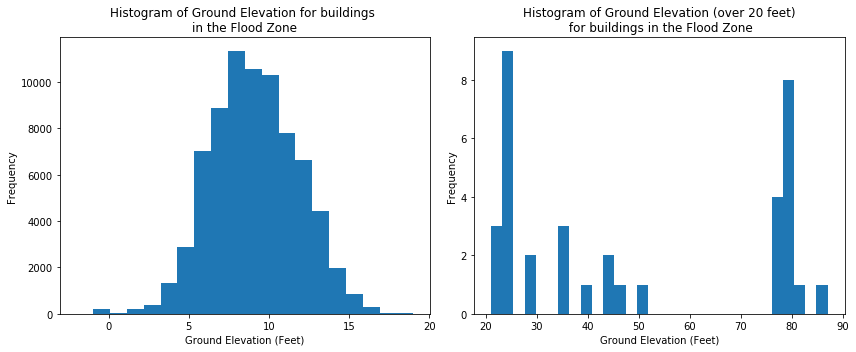

In [1218]:
#Set total figure size
plt.figure(figsize=(12,5))

# Plot Basic Histogram for Height
plt.subplot(121)
plt.hist(three_way['groundelev'][three_way['groundelev']<20], bins = 20)

# Formatting
plt.xlabel("Ground Elevation (Feet)",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Histogram of Ground Elevation for buildings \nin the Flood Zone",fontsize=12)
#plt.ylim(0,100)
#plt.xlim(0,100)

# Plot Histogram at heights over 100 feet
plt.subplot(122)
plt.hist(three_way['groundelev'][three_way['groundelev']>20], bins = 30)

# Formatting
plt.xlabel("Ground Elevation (Feet)",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Histogram of Ground Elevation (over 20 feet)\n"\
          " for buildings in the Flood Zone",fontsize=12)


plt.tight_layout()

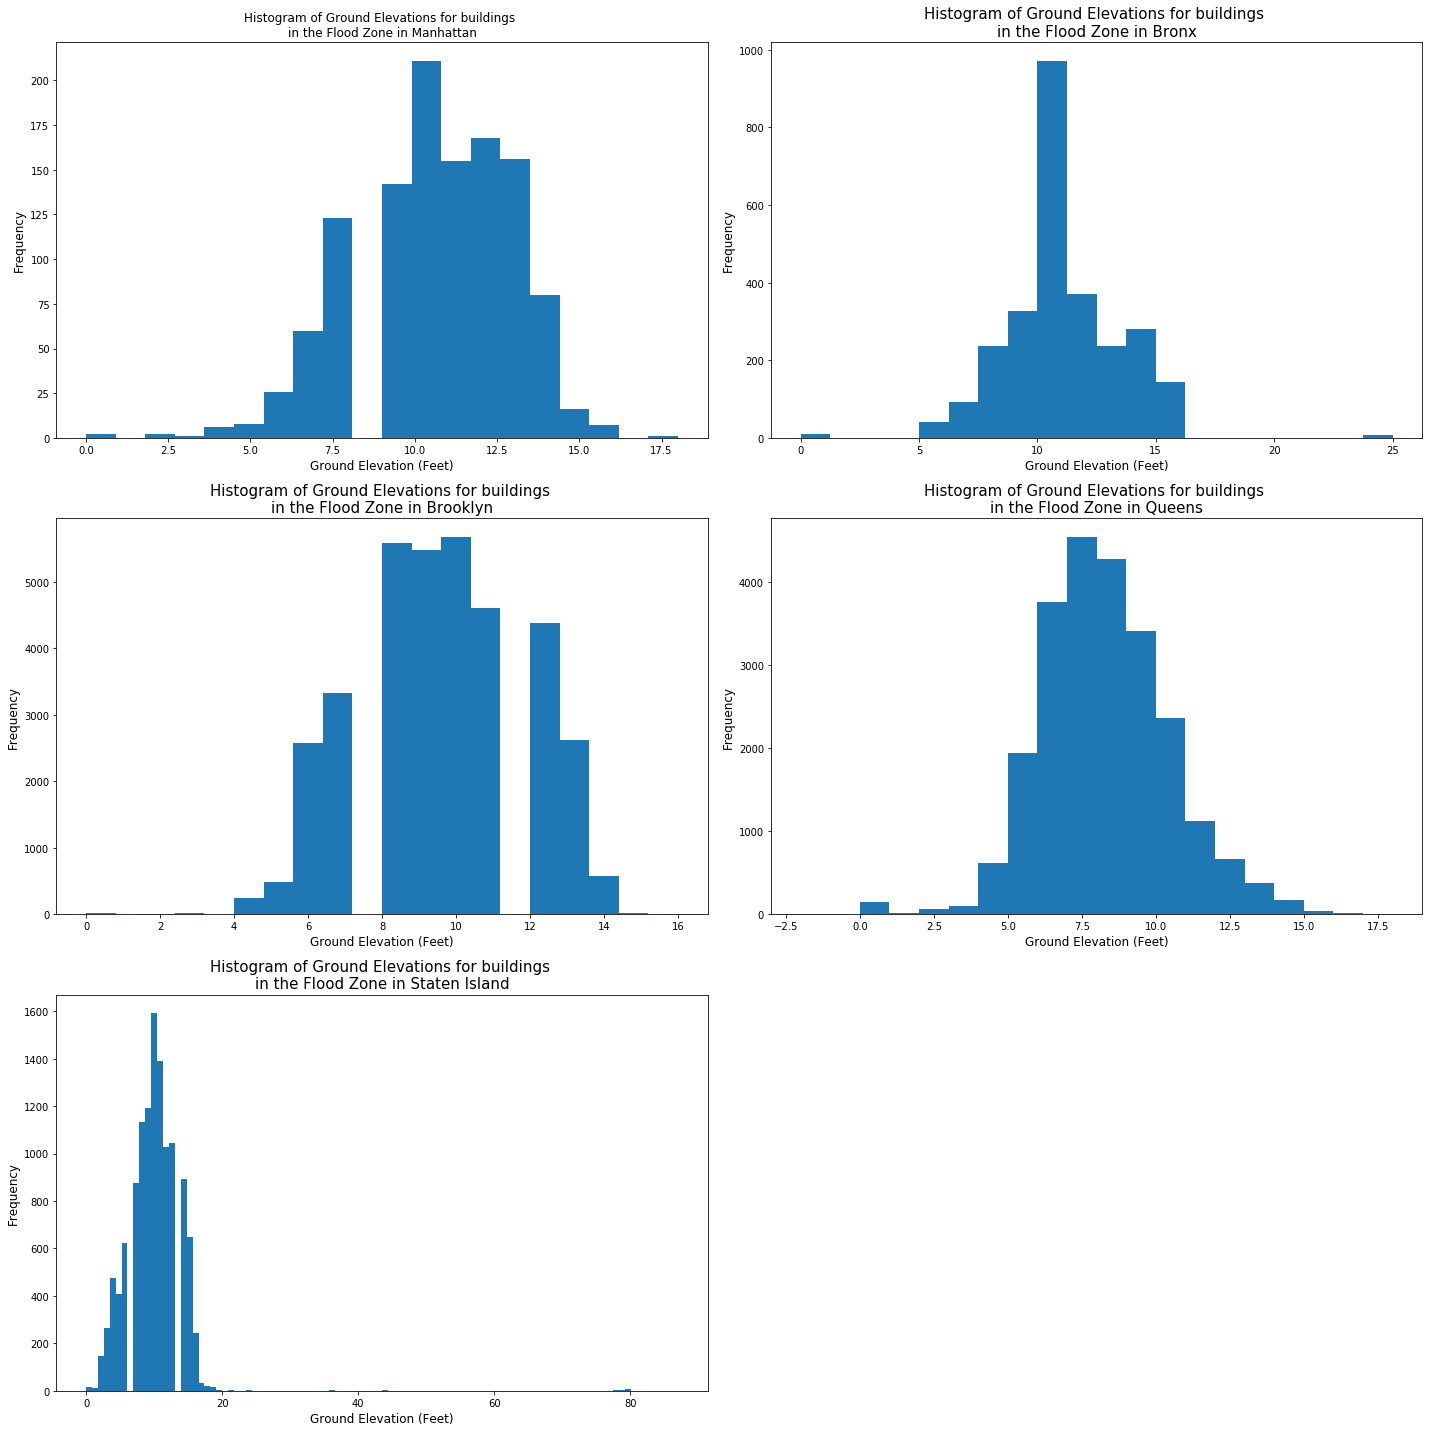

In [1219]:
#Set total figure size
plt.figure(figsize=(20,20))

# Plot Manhattan Heights
plt.subplot(321)
plt.hist(three_way['groundelev'][three_way['Borough']=='MN'], bins = 20)

# Formatting
plt.xlabel("Ground Elevation (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Ground Elevations for buildings \nin the Flood Zone in Manhattan",fontsize=12)
#plt.xlim(0,700)

# Plot Bronx Heights
plt.subplot(322)
plt.hist(three_way['groundelev'][three_way['Borough']=='BX'], bins = 20)

# Formatting
plt.xlabel("Ground Elevation (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Ground Elevations for buildings \nin the Flood Zone in Bronx",fontsize=15)
#plt.xlim(0,700)

# Plot Brooklyn Heights
plt.subplot(323)
plt.hist(three_way['groundelev'][three_way['Borough']=='BK'], bins = 20)

# Formatting
plt.xlabel("Ground Elevation (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Ground Elevations for buildings \nin the Flood Zone in Brooklyn",fontsize=15)
#plt.xlim(0,700)

# Plot Queens Heights
plt.subplot(324)
plt.hist(three_way['groundelev'][three_way['Borough']=='QN'], bins = 20)

# Formatting
plt.xlabel("Ground Elevation (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Ground Elevations for buildings \nin the Flood Zone in Queens",fontsize=15)
#plt.xlim(0,700)

# Plot Staten Island Heights
plt.subplot(325)
plt.hist(three_way['groundelev'][three_way['Borough']=='SI'], bins = 100)

# Formatting
plt.xlabel("Ground Elevation (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Ground Elevations for buildings \nin the Flood Zone in Staten Island",fontsize=15)
#plt.xlim(0,700)

plt.tight_layout()

# Decide whether to get rid of these outliers

Seems to be some noise in the data in terms of ground elevations, particularly for Staten Island. If the 0.2% flood area is approxiamtely 15 feet above ground anything abocve thiscan be removed.

In [1220]:
# Removing Ground Elevations above 22, clearly outliers
three_way = three_way[~(three_way['groundelev'] > 22)]

In [1221]:
three_way.shape # Only +- 30 data points dropped

(75252, 76)

### Base Flood Elevation (BFE)

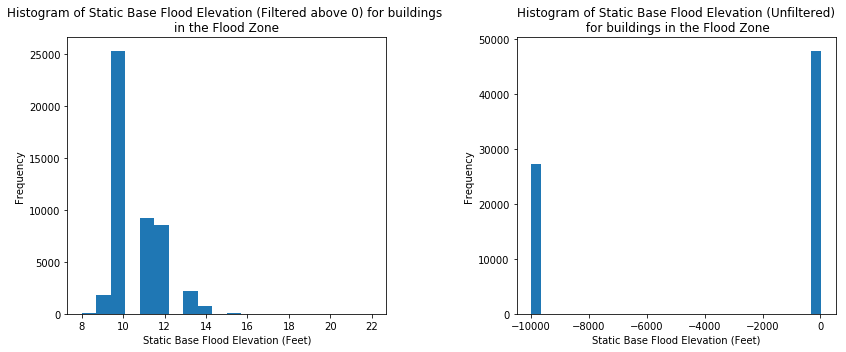

In [1222]:
#Set total figure size
plt.figure(figsize=(12,5))

# Plot Basic Histogram for Height
plt.subplot(121)
plt.hist(three_way['STATIC_BFE'][three_way['STATIC_BFE']>0], bins = 20)

# Formatting
plt.xlabel("Static Base Flood Elevation (Feet)",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Histogram of Static Base Flood Elevation (Filtered above 0)"\
          " for buildings \nin the Flood Zone",fontsize=12)
#plt.ylim(0,100)
#plt.xlim(0,100)

# Plot Histogram at heights over 100 feet
plt.subplot(122)
plt.hist(three_way['STATIC_BFE'], bins = 30)

# Formatting
plt.xlabel("Static Base Flood Elevation (Feet)",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Histogram of Static Base Flood Elevation (Unfiltered)\n"\
          " for buildings in the Flood Zone",fontsize=12)


plt.tight_layout()

There are a large number of BFE's at -9999, this includes data we cannot get rid of. Unfortunately we cannot use this as measure of BFE, we need to use Flood Zone Name. We can use this where it exists.

In [1223]:
three_way[three_way['STATIC_BFE']<0].shape

(27270, 76)

[]

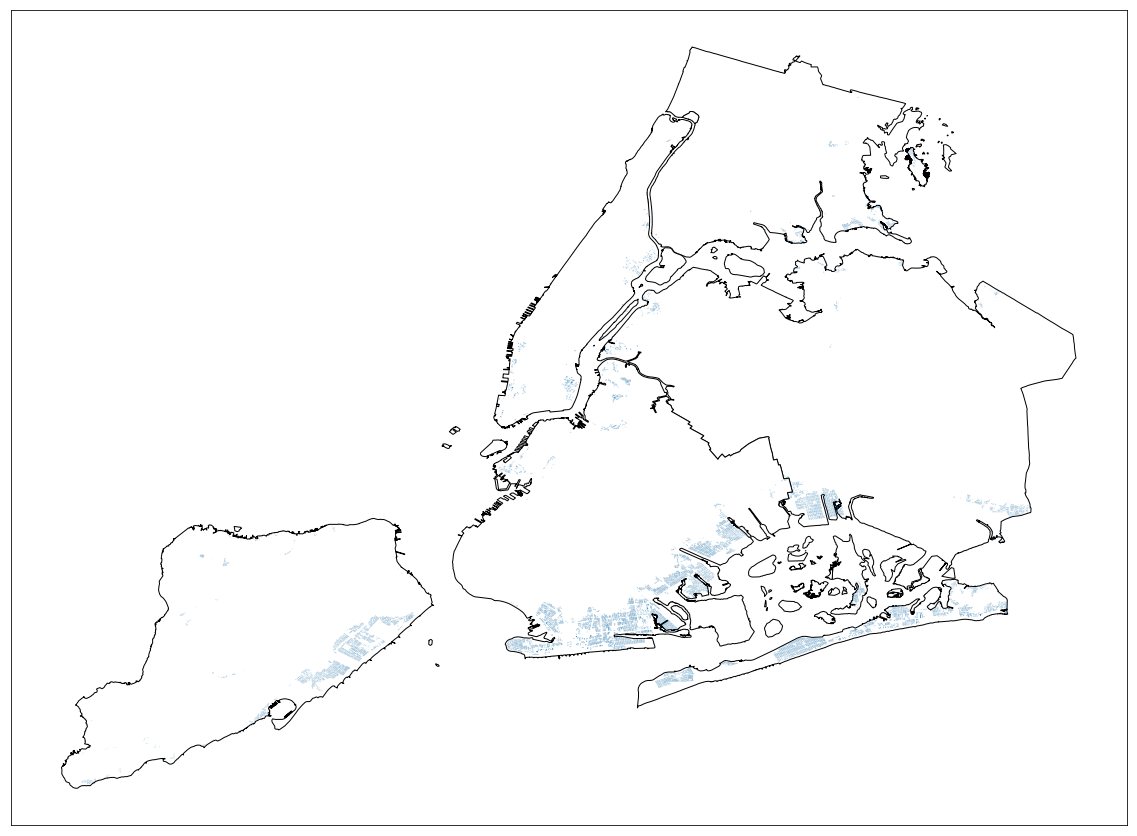

In [1224]:
# Plot Figure with base plot
fig,ax = plt.subplots(figsize=(20,15))
base = baseboro.plot(color='white',edgecolor='black', ax=ax)
three_way.plot(ax=ax)

# Format Plot
plt.title(' ',fontsize=30)
ax.set_xticks([])
ax.set_yticks([])


[]

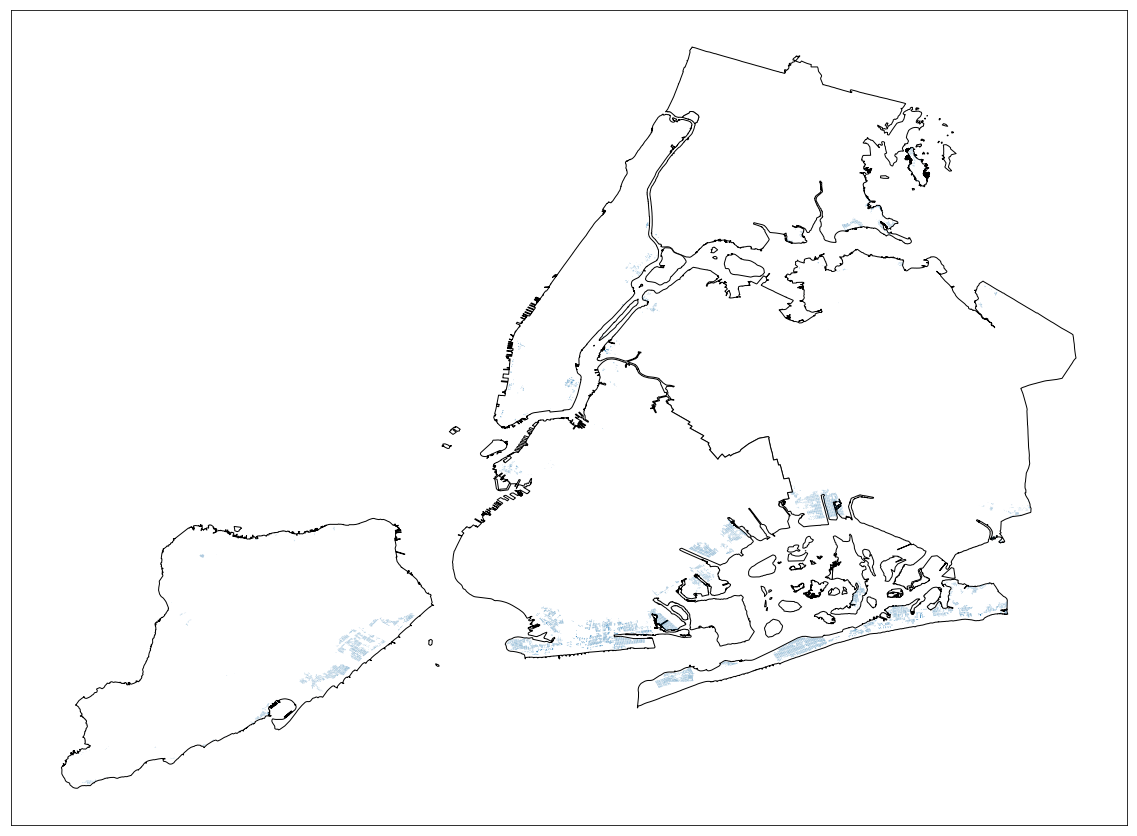

In [1225]:
# Plot Figure with base plot
fig,ax = plt.subplots(figsize=(20,15))
base = baseboro.plot(color='white',edgecolor='black', ax=ax)
three_way[three_way['STATIC_BFE']>0].plot(ax=ax)

# Format Plot
plt.title(' ',fontsize=30)
ax.set_xticks([])
ax.set_yticks([])


#three_way[three_way['STATIC_BFE']<0].plot() 

The buildings with Stitic BFE's not recorded properly are all inland and less at risk areas

In [1226]:
# Create data frame to check flood plain data
FloodPlain2 = FloodPlain
FloodPlain2['Test'] = 1

# Check flood plain data values
FloodPlain2.pivot_table(index='FLD_ZONE', columns='STATIC_BFE',values='Test')

STATIC_BFE                          -9999.0   8.0      9.0      10.0    \
FLD_ZONE                                                                 
0.2 PCT ANNUAL CHANCE FLOOD HAZARD      1.0      NaN      NaN      NaN   
A                                       1.0      NaN      NaN      NaN   
AE                                      1.0      1.0      1.0      1.0   
AO                                      1.0      NaN      NaN      NaN   
OPEN WATER                              1.0      NaN      NaN      NaN   
VE                                      NaN      NaN      NaN      NaN   
X                                       1.0      NaN      NaN      NaN   

STATIC_BFE                           11.0     12.0     13.0     14.0    \
FLD_ZONE                                                                 
0.2 PCT ANNUAL CHANCE FLOOD HAZARD      NaN      NaN      NaN      NaN   
A                                       NaN      NaN      NaN      NaN   
AE                                      1.0      1.0      1.0      1.0   
AO                                      NaN      NaN      NaN      NaN   
OPEN WATER                              NaN      NaN      NaN      NaN   
VE                                      1.0      1.0      1.0      1.0   
X                                       NaN      NaN      NaN      NaN   

STATIC_BFE                           15.0     16.0     ...      19.0    \
FLD_ZONE                                               ...               
0.2 PCT ANNUAL CHANCE FLOOD HAZARD      NaN      NaN   ...         NaN   
A                                       NaN      NaN   ...         NaN   
AE                                      1.0      1.0   ...         1.0   
AO                                      NaN      NaN   ...         NaN   
OPEN WATER                              NaN      NaN   ...         NaN   
VE                                      1.0      1.0   ...         1.0   
X                                       NaN      NaN   ...         NaN   

STATIC_BFE                           20.0     21.0     22.0     23.0    \
FLD_ZONE                                                                 
0.2 PCT ANNUAL CHANCE FLOOD HAZARD      NaN      NaN      NaN      NaN   
A                                       NaN      NaN      NaN      NaN   
AE                                      1.0      1.0      1.0      1.0   
AO                                      NaN      NaN      NaN      NaN   
OPEN WATER                              NaN      NaN      NaN      NaN   
VE                                      1.0      1.0      1.0      1.0   
X                                       NaN      NaN      NaN      NaN   

STATIC_BFE                           25.0     26.0     32.0     33.0    \
FLD_ZONE                                                                 
0.2 PCT ANNUAL CHANCE FLOOD HAZARD      NaN      NaN      NaN      NaN   
A                                       NaN      NaN      NaN      NaN   
AE                                      NaN      NaN      NaN      NaN   
AO                                      NaN      NaN      NaN      NaN   
OPEN WATER                              NaN      NaN      NaN      NaN   
VE                                      1.0      1.0      1.0      1.0   
X                                       NaN      NaN      NaN      NaN   

STATIC_BFE                           34.0    
FLD_ZONE                                     
0.2 PCT ANNUAL CHANCE FLOOD HAZARD      NaN  
A                                       NaN  
AE                                      NaN  
AO                                      NaN  
OPEN WATER                              NaN  
VE                                      1.0  
X                                       NaN  

[7 rows x 22 columns]

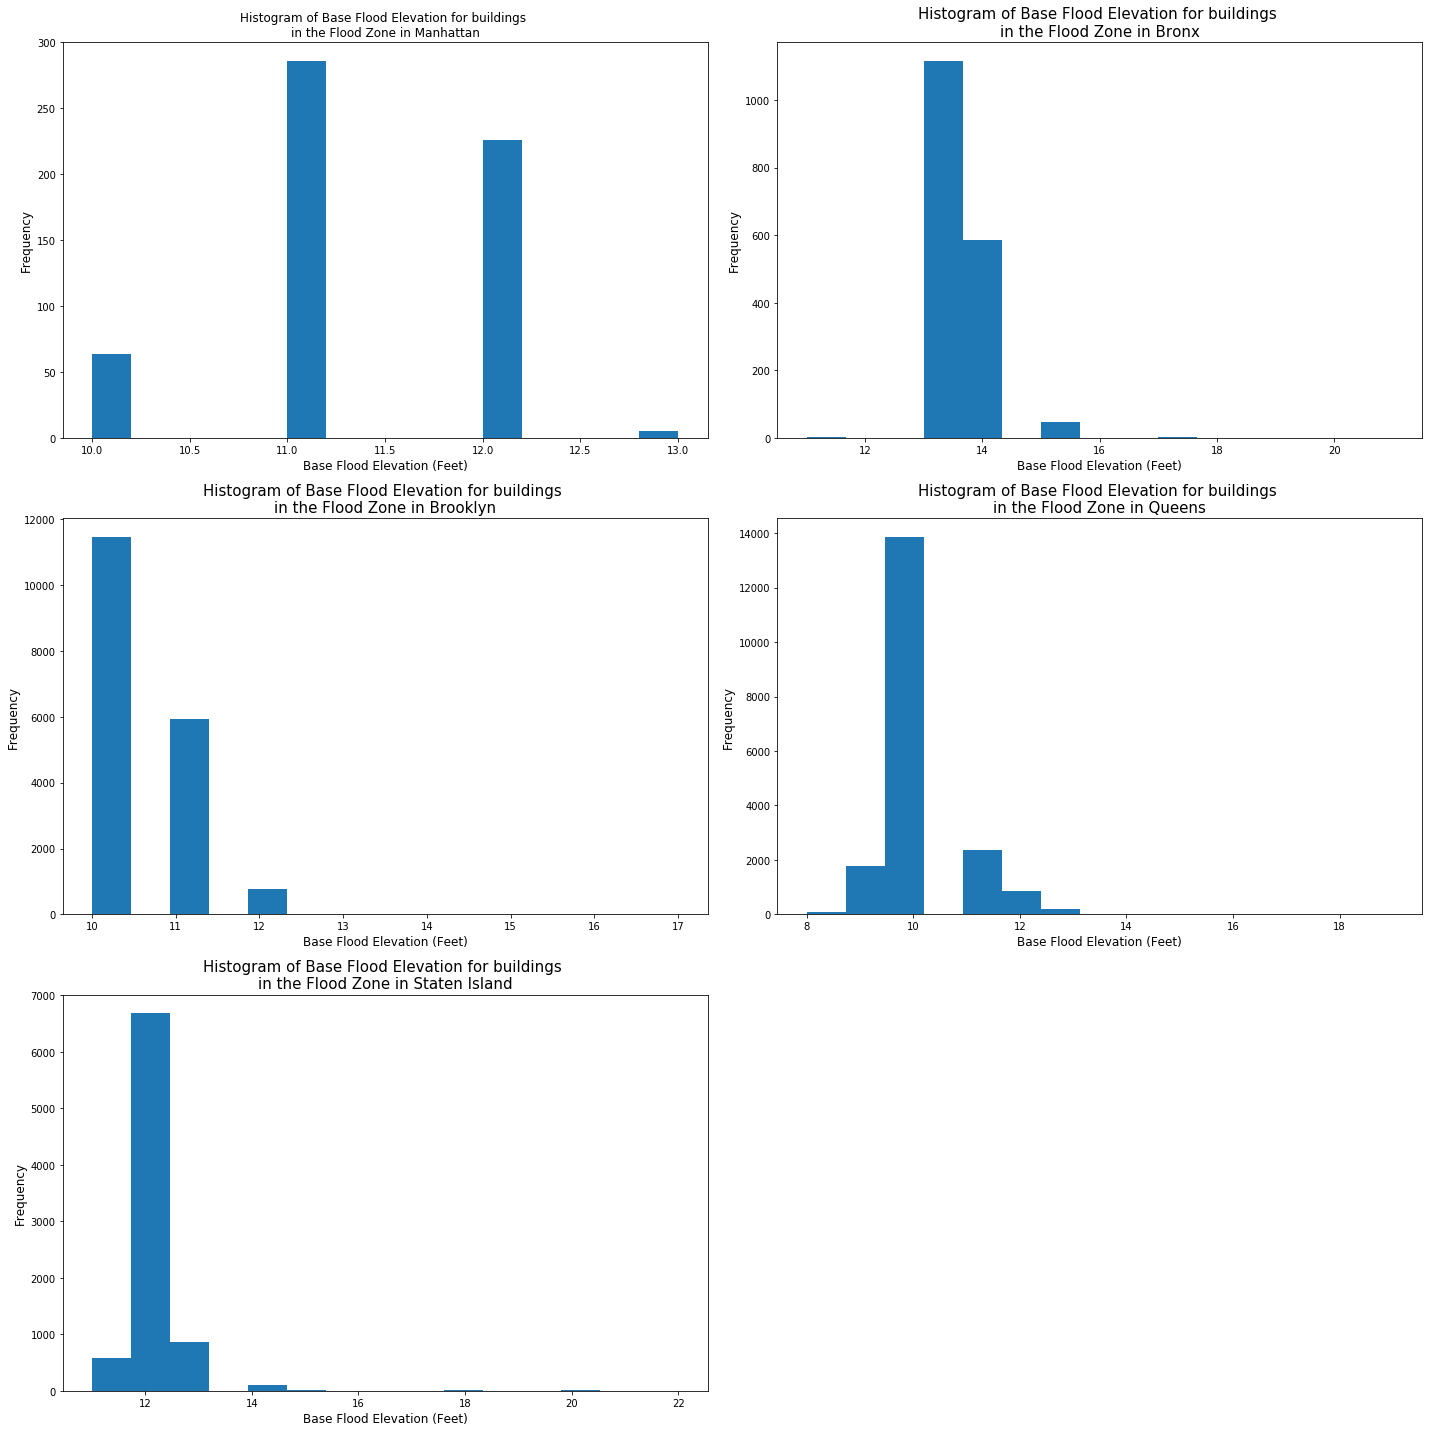

In [1227]:
#Set total figure size
plt.figure(figsize=(20,20))

# Plot Manhattan Heights
plt.subplot(321)
plt.hist(three_way['STATIC_BFE'][(three_way['Borough']=='MN') & (three_way['STATIC_BFE']>0)], bins = 15)

# Formatting
plt.xlabel("Base Flood Elevation (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Base Flood Elevation for buildings \nin the Flood Zone in Manhattan",fontsize=12)
#plt.xlim(0,700)

# Plot Bronx Heights
plt.subplot(322)
plt.hist(three_way['STATIC_BFE'][(three_way['Borough']=='BX') & (three_way['STATIC_BFE']>0)], bins = 15)

# Formatting
plt.xlabel("Base Flood Elevation (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Base Flood Elevation for buildings \nin the Flood Zone in Bronx",fontsize=15)
#plt.xlim(0,700)

# Plot Brooklyn Heights
plt.subplot(323)
plt.hist(three_way['STATIC_BFE'][(three_way['Borough']=='BK') & (three_way['STATIC_BFE']>0)], bins = 15)

# Formatting
plt.xlabel("Base Flood Elevation (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Base Flood Elevation for buildings \nin the Flood Zone in Brooklyn",fontsize=15)
#plt.xlim(0,700)

# Plot Queens Heights
plt.subplot(324)
plt.hist(three_way['STATIC_BFE'][(three_way['Borough']=='QN') & (three_way['STATIC_BFE']>0)], bins = 15)

# Formatting
plt.xlabel("Base Flood Elevation (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Base Flood Elevation for buildings \nin the Flood Zone in Queens",fontsize=15)
#plt.xlim(0,700)

# Plot Staten Island Heights
plt.subplot(325)
plt.hist(three_way['STATIC_BFE'][(three_way['Borough']=='SI') & (three_way['STATIC_BFE']>0)], bins = 15)

# Formatting
plt.xlabel("Base Flood Elevation (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Base Flood Elevation for buildings \nin the Flood Zone in Staten Island",fontsize=15)
#plt.xlim(0,700)

plt.tight_layout()

The actual BFE's vary between 8 and 22 feet. 

### Building Height Data

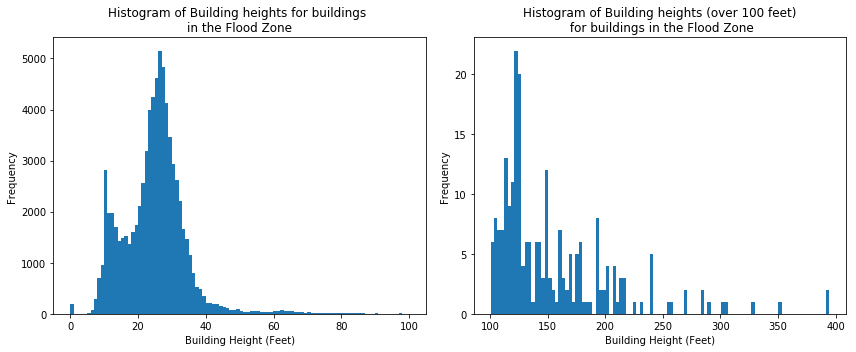

In [1228]:
#Set total figure size
plt.figure(figsize=(12,5))

# Plot Basic Histogram for Height
plt.subplot(121)
plt.hist(three_way['heightroof'][three_way['heightroof']<100], bins = 100)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Histogram of Building heights for buildings \nin the Flood Zone",fontsize=12)
#plt.ylim(0,100)
#plt.xlim(0,100)

# Plot Histogram at heights over 100 feet
plt.subplot(122)
plt.hist(three_way['heightroof'][three_way['heightroof']>100], bins = 100)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Histogram of Building heights (over 100 feet)\n"\
          " for buildings in the Flood Zone",fontsize=12)


plt.tight_layout()

There are clearly several outliers for building heights, however this si to be expected with sky scrapers and highrises in some flood zone areas. It would be better to visualise the height dispersion from a Geospatial persepctive to identify potential outliers and noise in data. 

We need to remove houses with heights below 7 feet as this does not make sense, this would be a house less than a single story and potentially underground? However, we will not remove outliers on the high end as there are high buildings in NYC. There is a case to remove them as one could assume buildings over a certain height may not be at risk as they could be considered desirable residential or mixed use properties.

In [1229]:
# Removing Ground Elevations above 22, clearly outliers
three_way = three_way[~(three_way['heightroof'] < 7)]

In [1230]:
three_way.shape # We remove approximately 300 data points

(74976, 76)

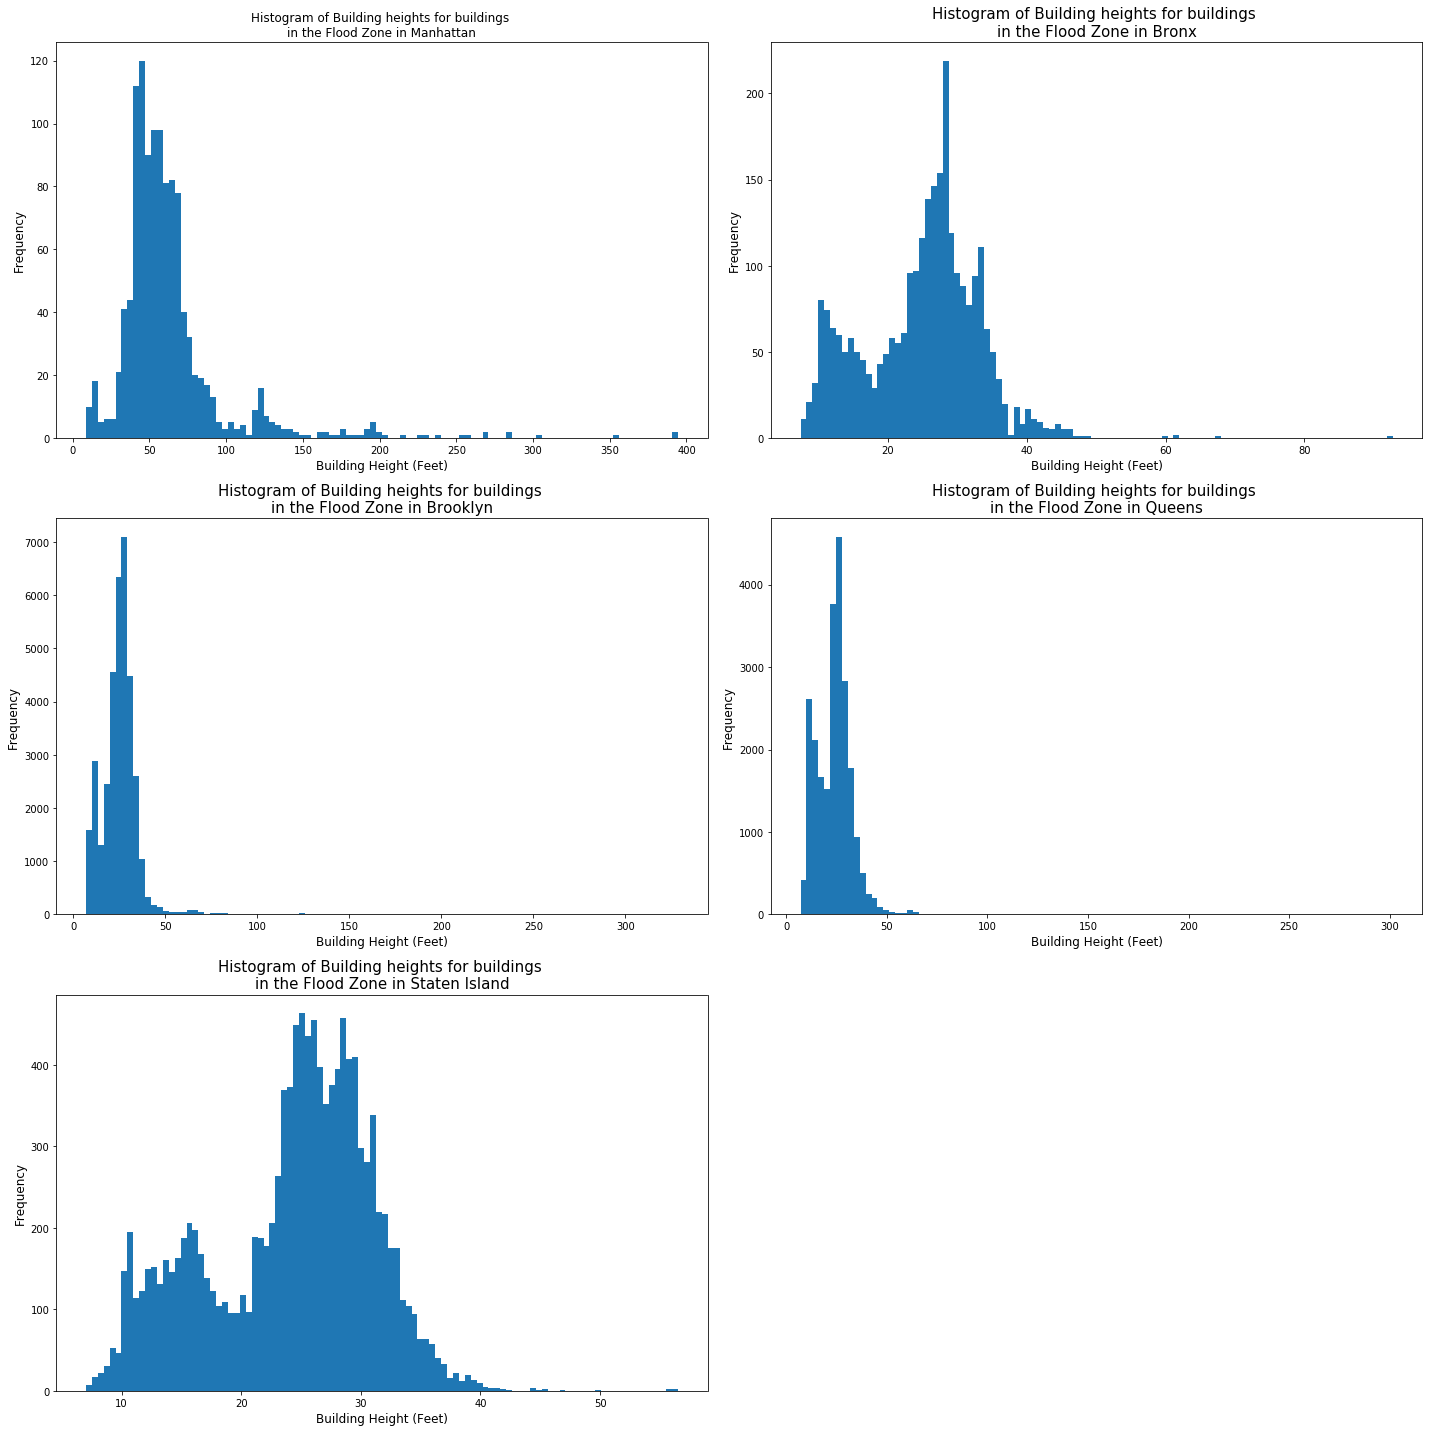

In [1231]:
#Set total figure size
plt.figure(figsize=(20,20))

# Plot Manhattan Heights
plt.subplot(321)
plt.hist(three_way['heightroof'][three_way['Borough']=='MN'], bins = 100)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \nin the Flood Zone in Manhattan",fontsize=12)
#plt.xlim(0,700)

# Plot Bronx Heights
plt.subplot(322)
plt.hist(three_way['heightroof'][three_way['Borough']=='BX'], bins = 100)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \nin the Flood Zone in Bronx",fontsize=15)
#plt.xlim(0,700)

# Plot Brooklyn Heights
plt.subplot(323)
plt.hist(three_way['heightroof'][three_way['Borough']=='BK'], bins = 100)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \nin the Flood Zone in Brooklyn",fontsize=15)
#plt.xlim(0,700)

# Plot Queens Heights
plt.subplot(324)
plt.hist(three_way['heightroof'][three_way['Borough']=='QN'], bins = 100)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \nin the Flood Zone in Queens",fontsize=15)
#plt.xlim(0,700)

# Plot Staten Island Heights
plt.subplot(325)
plt.hist(three_way['heightroof'][three_way['Borough']=='SI'], bins = 100)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \nin the Flood Zone in Staten Island",fontsize=15)
#plt.xlim(0,700)

plt.tight_layout()

There appear to be outliers in each borough, however the bulk of residential buildings falls in specific ranges, with all borough's means mostly falling below 50 feet, which makes sense. except for Manhaatan where there are more high rises. Let's look at the building types and heights to identify potential outliers?

### Building land Use Codes for Pluto Data
![bashrc aliases and functions](https://raw.githubusercontent.com/andrewnell/CAUI2017_adn323/master/Images/Screen%20Shot%202017-11-20%20at%202.15.01%20PM.png)

Available from: https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=16v2

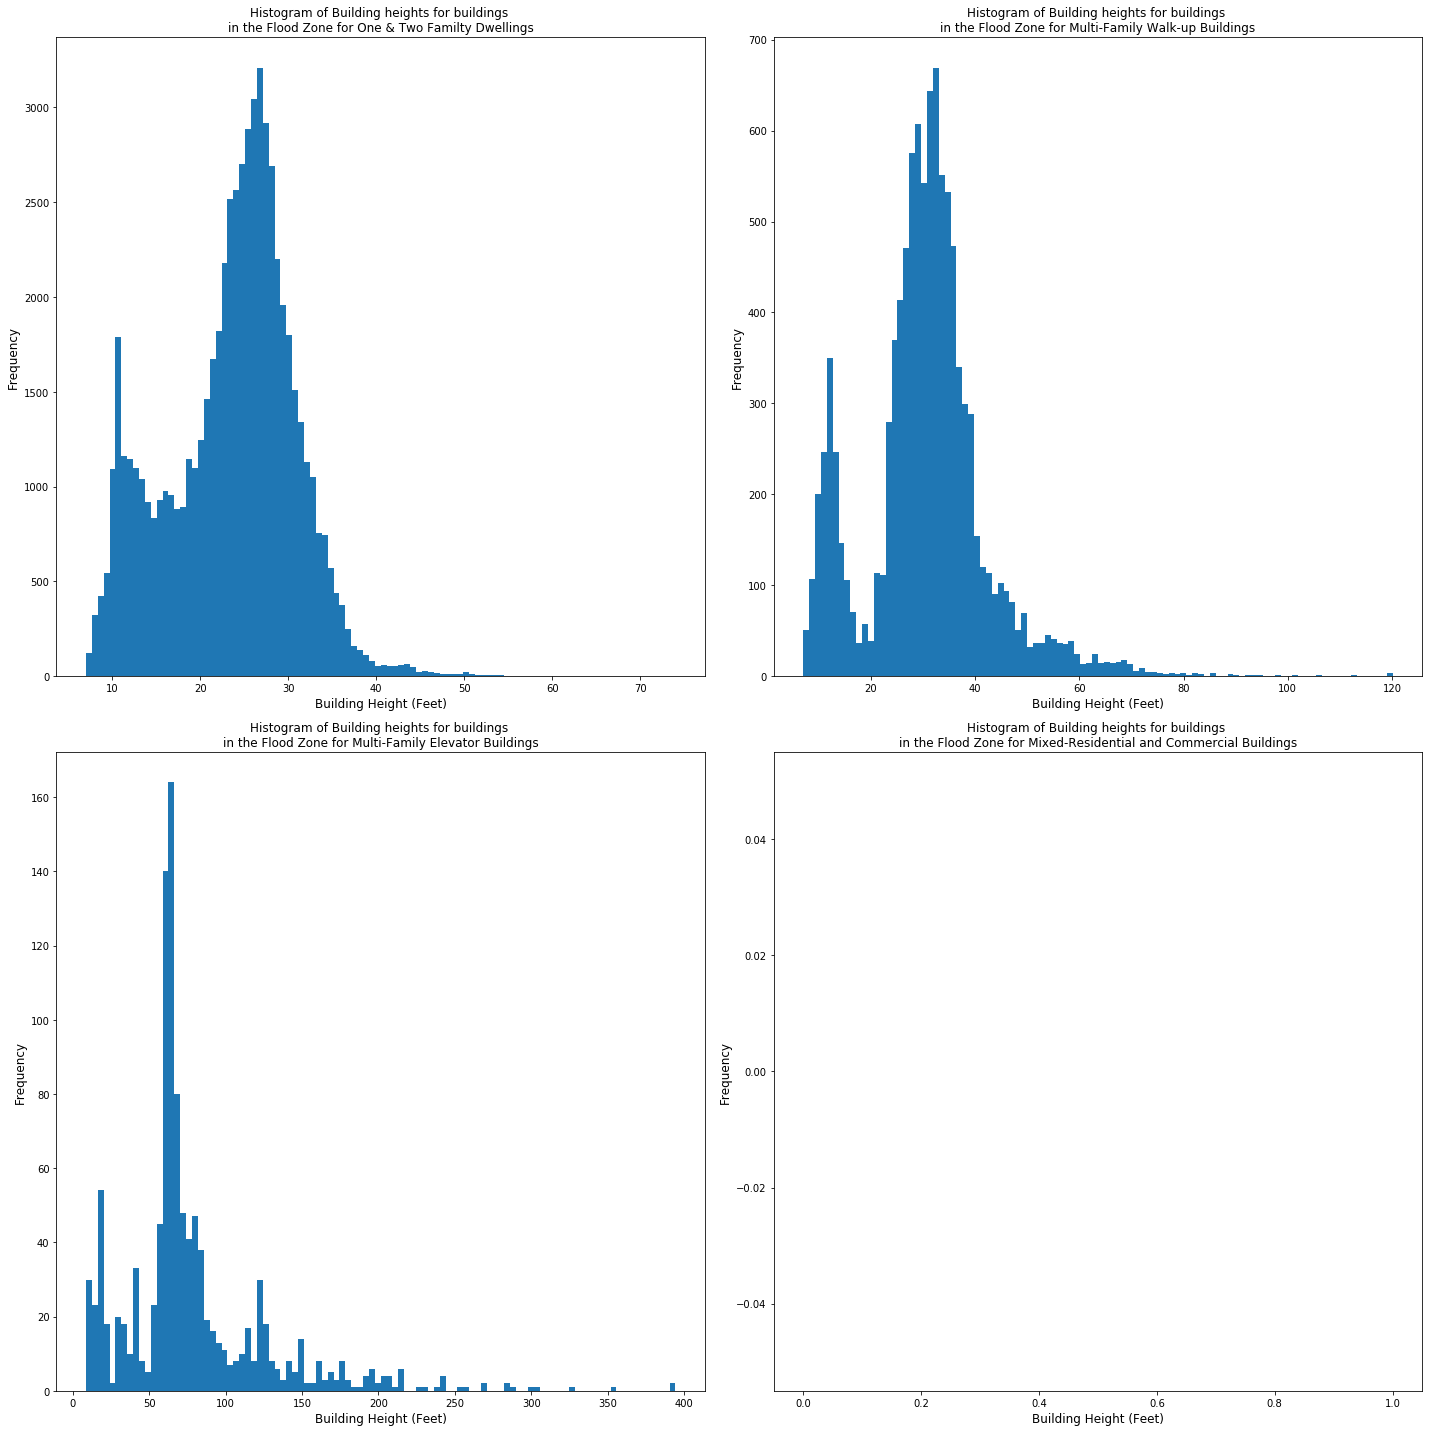

In [1232]:
#Set total figure size
plt.figure(figsize=(20,20))

# Plot One and Two Family Buildings Heights
plt.subplot(221)
plt.hist(three_way['heightroof'][three_way['LandUse']==1], bins = 100)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \n"
          "in the Flood Zone for One & Two Familty Dwellings",fontsize=12)
#plt.xlim(0,700)

# Plot Multi-Family Walk Ups Heights
plt.subplot(222)
plt.hist(three_way['heightroof'][three_way['LandUse']==2], bins = 100)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \n"
          "in the Flood Zone for Multi-Family Walk-up Buildings",fontsize=12)
#plt.xlim(0,700)

# Plot Multi-Family Elevator Heights
plt.subplot(223)
plt.hist(three_way['heightroof'][three_way['LandUse']==3], bins = 100)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \n"
          "in the Flood Zone for Multi-Family Elevator Buildings",fontsize=12)
#plt.xlim(0,700)

# Plot Mixed-Residential and Commercial Heights
plt.subplot(224)
plt.hist(three_way['heightroof'][three_way['LandUse']==4], bins = 100)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \n"
          "in the Flood Zone for Mixed-Residential and Commercial Buildings",fontsize=12)
#plt.xlim(0,700)


plt.tight_layout()

It is clear that the one and two family homes make sense mostly, with all data points between 10 and 30 feet, about 1-4 stories. 

The multi Family Walk ups appear to have some outliers with data suggesting 10 feet, however the buildings could be from underground, so single sotry walk ups. The rest of the data makes sense with buildings up to mostly 60 feet. Approximately 6 stories, with some outliers.

The Multi-Family Elevator buildings have a much high range due to the elevators. However there is some concern regarding data below 20 feet, why would they have elevators below 2 stories?

Mixed Residential and Commrecial buildings have a big mix of ranges and there are potential truths in the high values, with the low values also making sense, potentially with some buildings being 1 story.

In [1233]:
three_way = three_way[~((three_way['heightroof'] > 50) & (three_way['LandUse']==1))]
three_way.shape
# 70 lost

(74904, 76)

[]

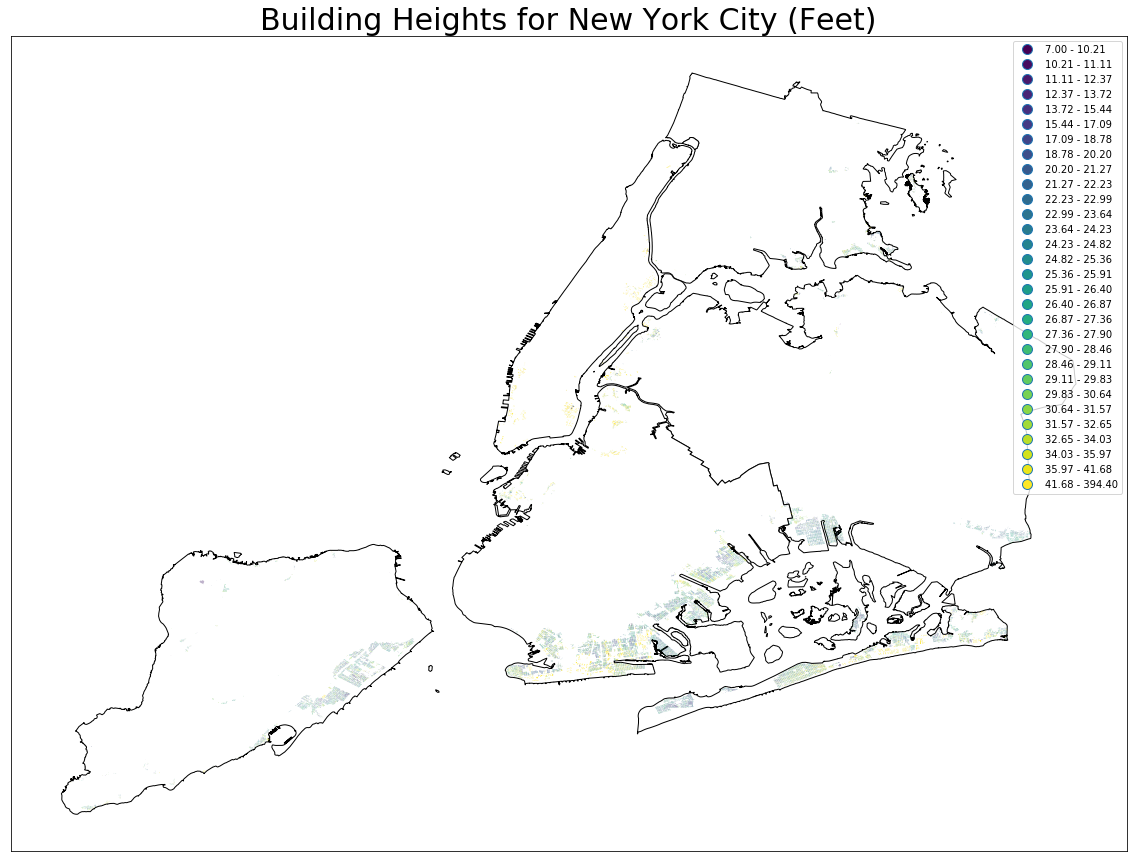

In [1234]:
# Plot Figure with base plot
fig,ax = plt.subplots(figsize=(20,15))
base = baseboro.plot(color='white',edgecolor='black', ax=ax)
three_way.plot(column='heightroof',cmap='viridis',scheme='Quantiles',k=30,legend=True,ax=ax)

# Format Plot
plt.title('Building Heights for New York City (Feet)',fontsize=30)
ax.set_xticks([])
ax.set_yticks([])

[]

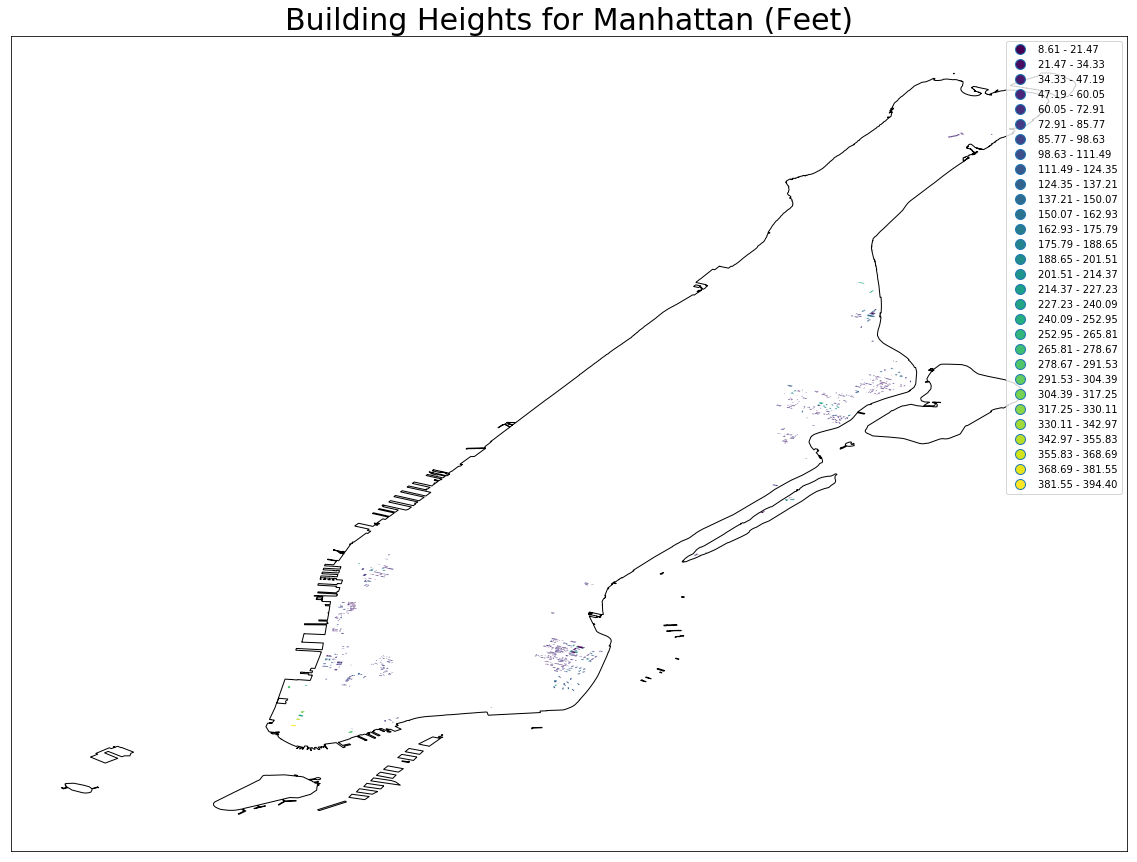

In [832]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==1].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['Borough']=='MN')].plot(column='heightroof',cmap='viridis',
                                             scheme='Equal_interval',
                                             k=30,legend=True,ax=ax)

# Format Plot
plt.title('Building Heights for Manhattan (Feet)',fontsize=30)
ax.set_xticks([])
ax.set_yticks([])

[]

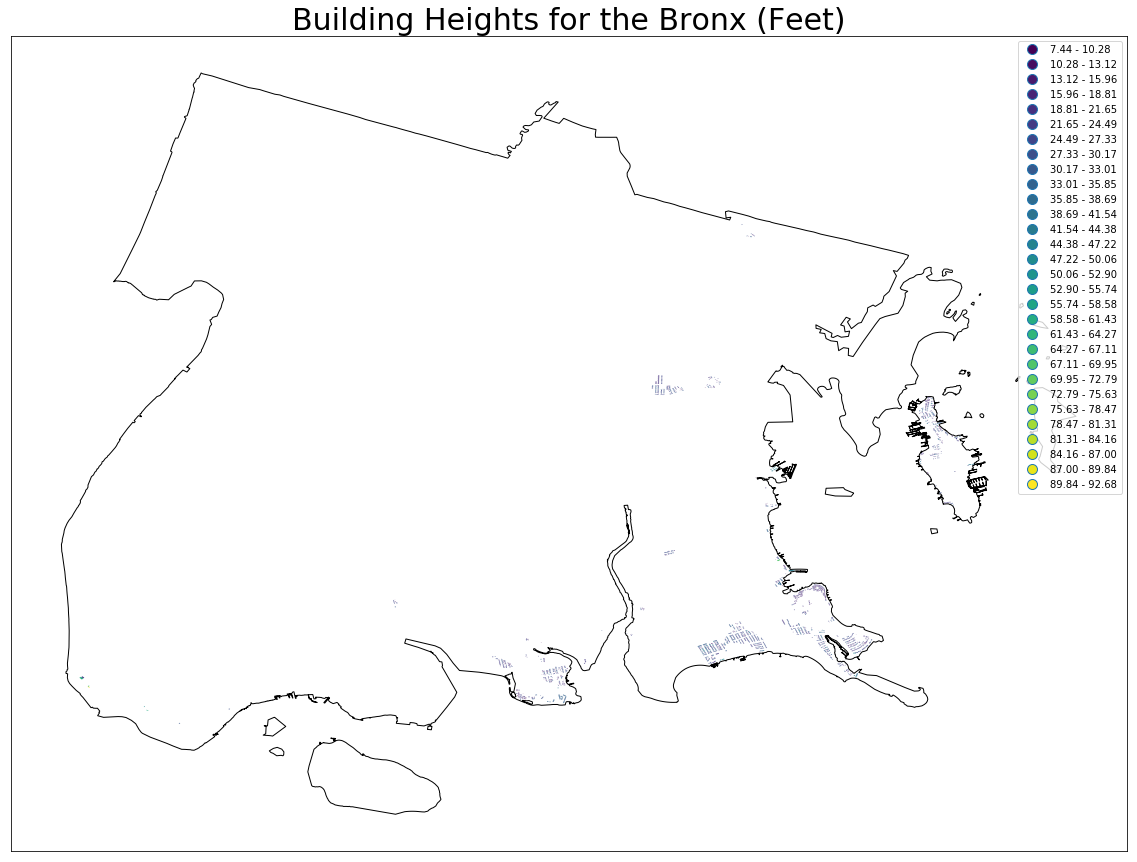

In [833]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==2].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['Borough']=='BX')].plot(column='heightroof',cmap='viridis',
                                             scheme='Equal_interval',
                                             k=30,legend=True,ax=ax)

# Format Plot
plt.title('Building Heights for the Bronx (Feet)',fontsize=30)
ax.set_xticks([])
ax.set_yticks([])

[]

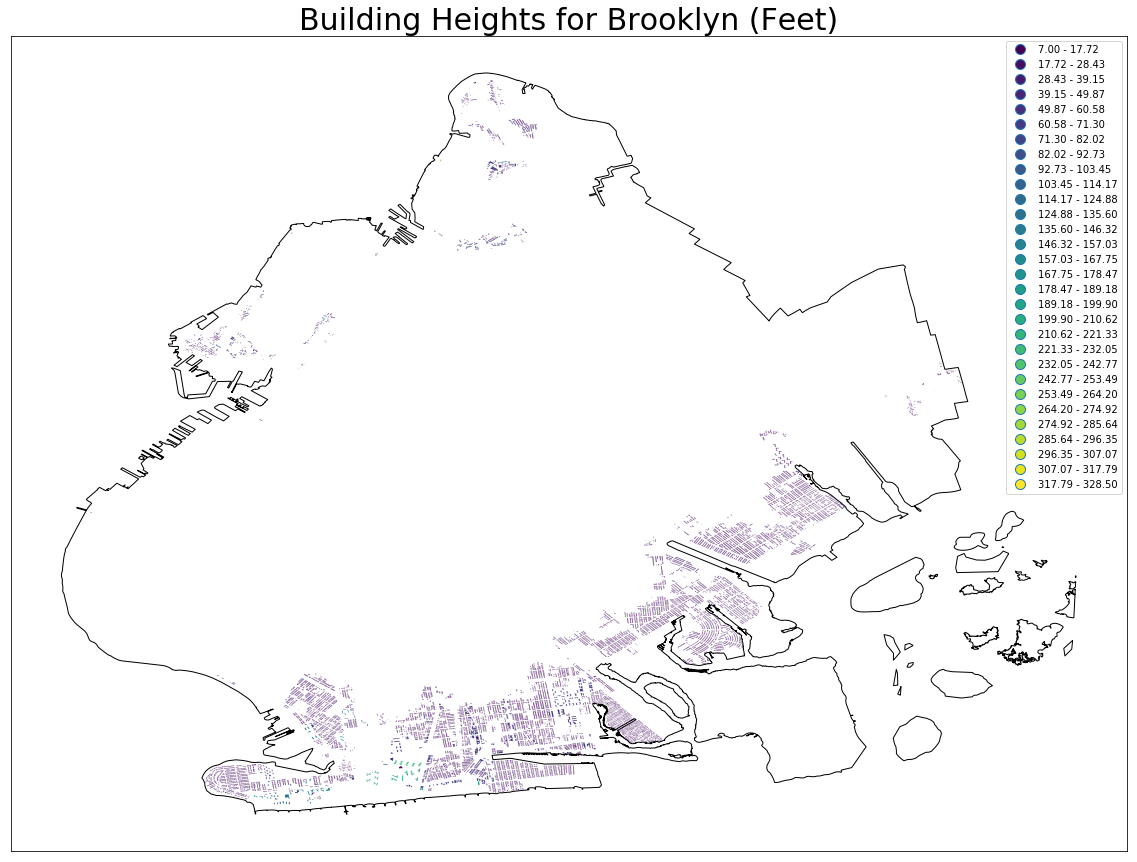

In [834]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==3].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['Borough']=='BK')].plot(column='heightroof',cmap='viridis',
                                             scheme='Equal_interval',
                                             k=30,legend=True,ax=ax)

# Format Plot
plt.title('Building Heights for Brooklyn (Feet)',fontsize=30)
ax.set_xticks([])
ax.set_yticks([])

[]

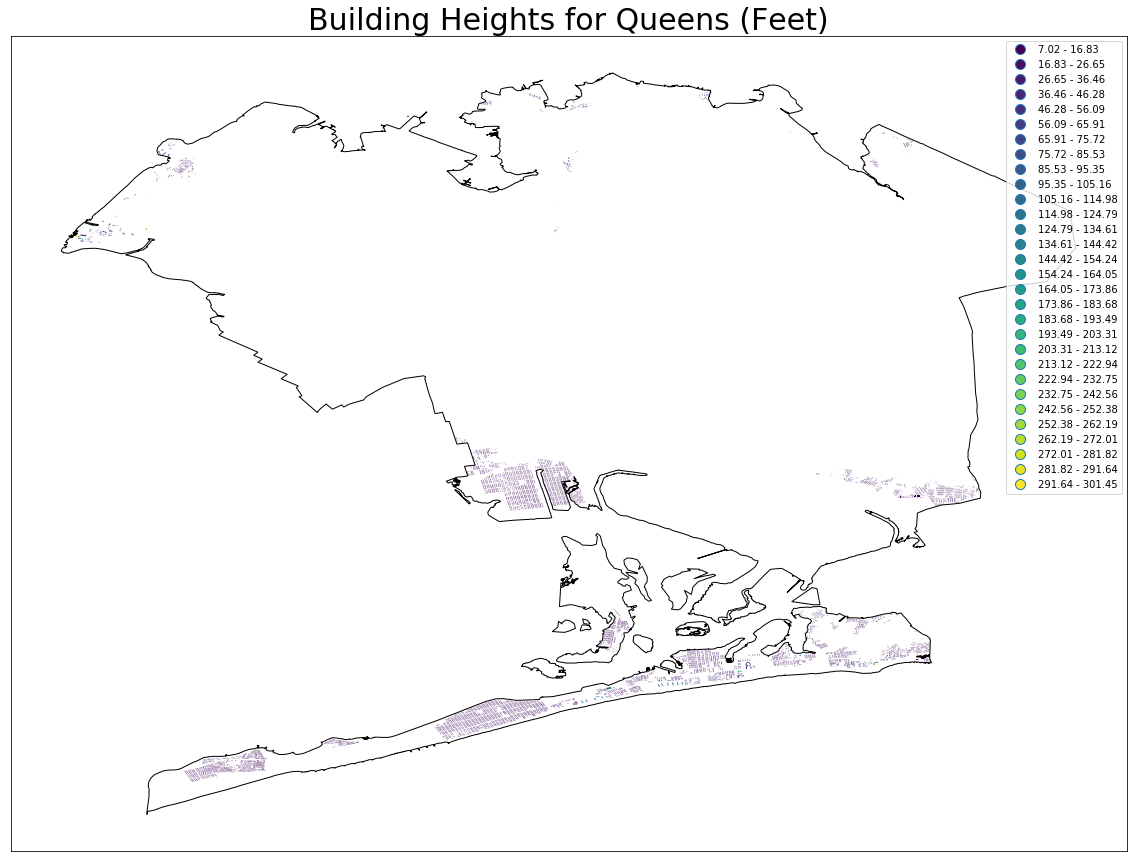

In [835]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==4].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['Borough']=='QN')].plot(column='heightroof',cmap='viridis',
                                             scheme='Equal_interval',
                                             k=30,legend=True,ax=ax)

# Format Plot
plt.title('Building Heights for Queens (Feet)',fontsize=30)
ax.set_xticks([])
ax.set_yticks([])

[]

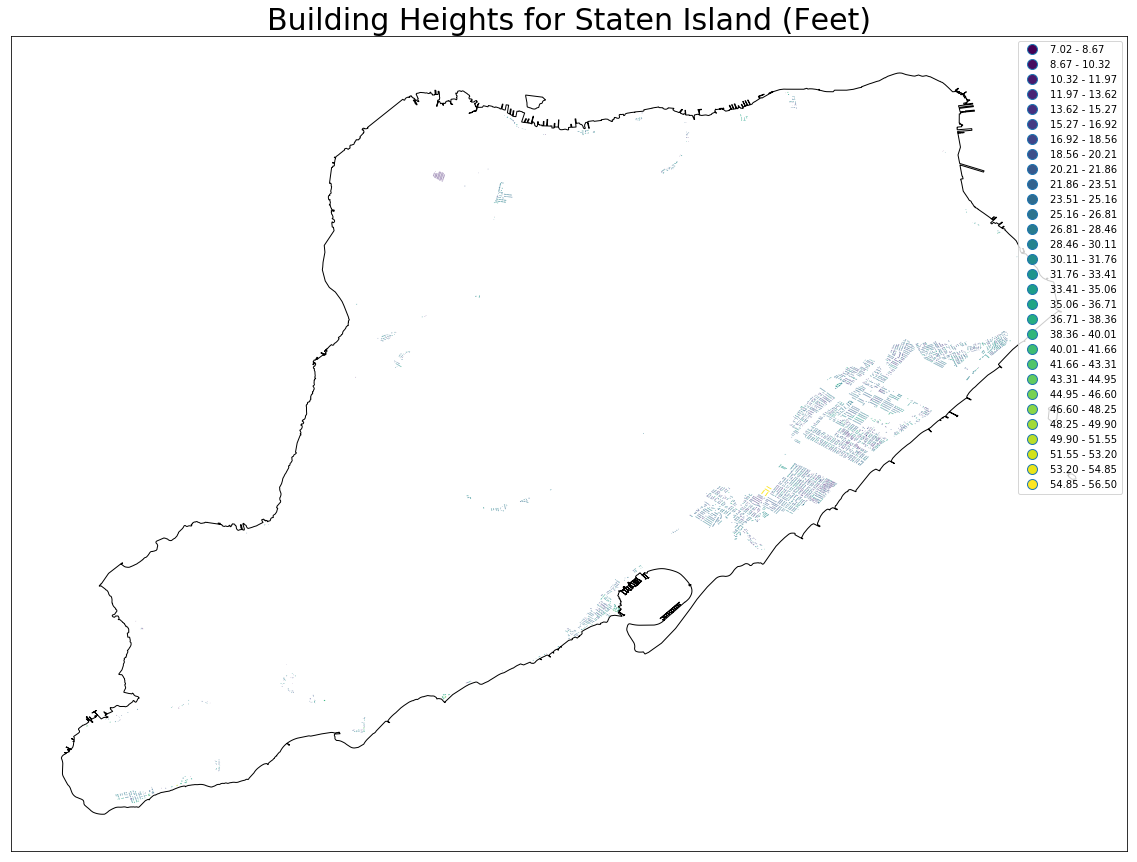

In [836]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==5].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['Borough']=='SI')].plot(column='heightroof',cmap='viridis',
                                             scheme='Equal_interval',
                                             k=30,legend=True,ax=ax)

# Format Plot
plt.title('Building Heights for Staten Island (Feet)',fontsize=30)
ax.set_xticks([])
ax.set_yticks([])

### Number of Floors

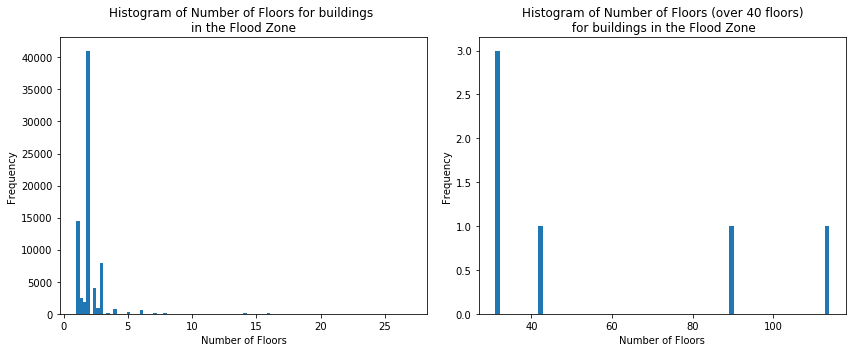

In [1235]:
#Set total figure size
plt.figure(figsize=(12,5))

# Plot Basic Histogram for Height
plt.subplot(121)
plt.hist(three_way['NumFloors'][(three_way['NumFloors']<30) & (three_way['NumFloors']>0)], bins = 100)

# Formatting
plt.xlabel("Number of Floors",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Histogram of Number of Floors for buildings \nin the Flood Zone",fontsize=12)
#plt.ylim(0,5)
#plt.xlim(0,100)

# Plot Histogram at heights over 100 feet
plt.subplot(122)
plt.hist(three_way['NumFloors'][three_way['NumFloors']>30], bins = 70)

# Formatting
plt.xlabel("Number of Floors",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Histogram of Number of Floors (over 40 floors)\n"\
          " for buildings in the Flood Zone",fontsize=12)


plt.tight_layout()

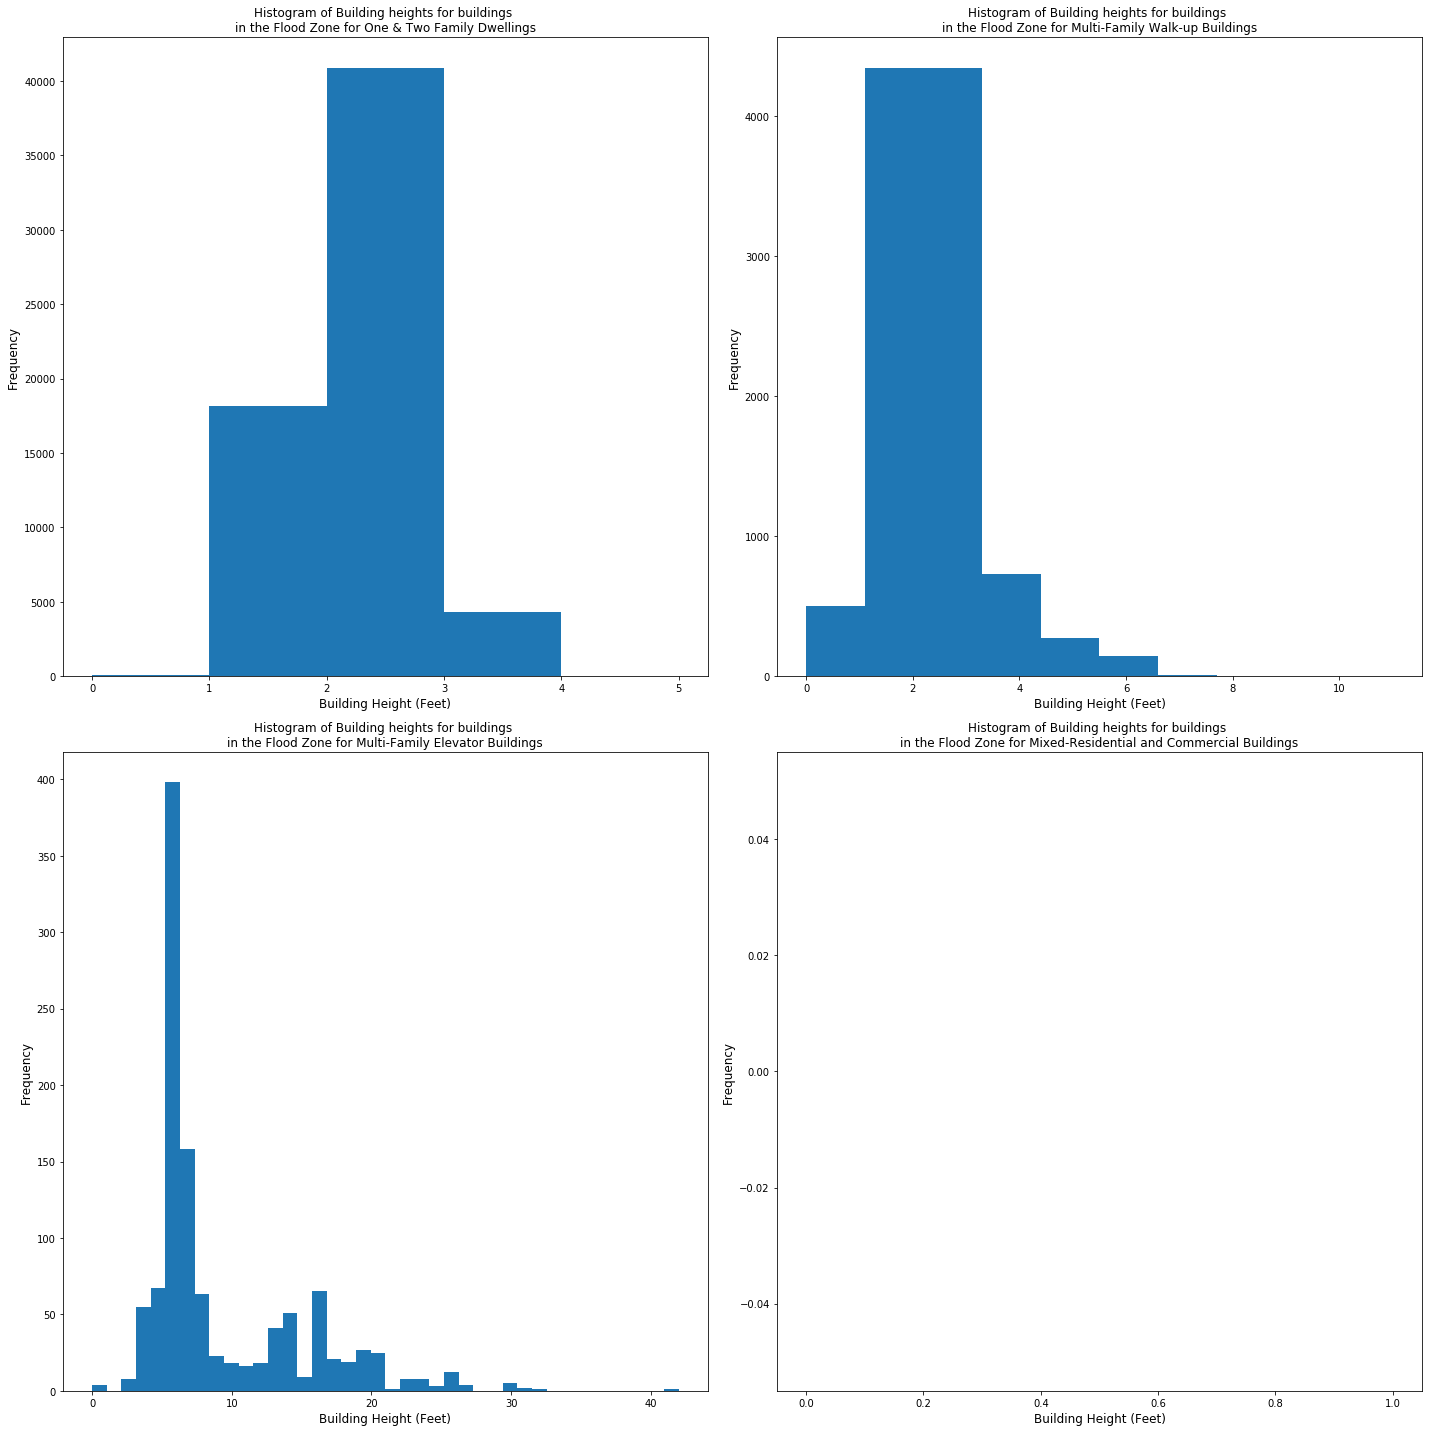

In [1236]:
#Set total figure size
plt.figure(figsize=(20,20))

# Plot One and Two Family Buildings Heights
plt.subplot(221)
plt.hist(three_way['NumFloors'][(three_way['LandUse']==1) & (three_way['NumFloors']<10)], bins = 5)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \n"
          "in the Flood Zone for One & Two Family Dwellings",fontsize=12)
#plt.xlim(0,700)

# Plot Multi-Family Walk Ups Heights
plt.subplot(222)
plt.hist(three_way['NumFloors'][(three_way['LandUse']==2) & (three_way['NumFloors']<20)], bins = 10)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \n"
          "in the Flood Zone for Multi-Family Walk-up Buildings",fontsize=12)
#plt.xlim(0,700)

# Plot Multi-Family Elevator Heights
plt.subplot(223)
plt.hist(three_way['NumFloors'][three_way['LandUse']==3], bins = 40)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \n"
          "in the Flood Zone for Multi-Family Elevator Buildings",fontsize=12)
#plt.xlim(0,700)

# Plot Mixed-Residential and Commercial Heights
plt.subplot(224)
plt.hist(three_way['NumFloors'][three_way['LandUse']==4], bins = 50)

# Formatting
plt.xlabel("Building Height (Feet)",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Histogram of Building heights for buildings \n"
          "in the Flood Zone for Mixed-Residential and Commercial Buildings",fontsize=12)
#plt.xlim(0,700)


plt.tight_layout()

 There are clearly filters that need to be applied to individual building types, as you it is unlikely that a single or double familty home has more than 10 stories. Additionally, it is unlikely that a multi-family walk up is more than 20 stories. This data must be cleaned up.
 
 It is anticipated that the numebr of stories will follow a similar pattern to the building heights with obvious variation of a floor or two due to buildings potentially having basements etc. 

In [1237]:
# Removing Floors less than zero
three_way = three_way[~(three_way['NumFloors'] <= 0)]

# Remove one or two family homes with more than 10 floors
three_way = three_way[~((three_way['LandUse']==1) & (three_way['NumFloors']>10))]

# Remove Multi-Family Walk Ups with more than 20 stories
three_way = three_way[~((three_way['LandUse']==2) & (three_way['NumFloors']>20))]

In [1238]:
three_way.shape # Approximately 70 data points removed

(74828, 76)

### Building Age Data

First we need to remove buildings that are clear outliers, ie. 0 construction years

In [1239]:
# Removing Floors less than zero
three_way = three_way[~(three_way['cnstrct_yr'] == 0)]

In [1240]:
three_way.shape # Approximately 200 data points were lost

(74653, 76)

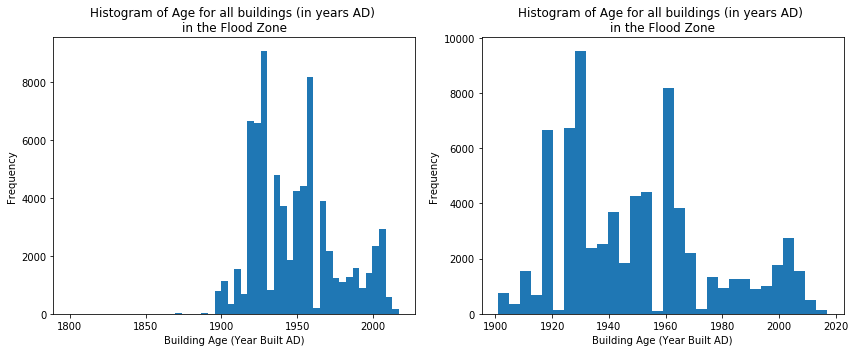

In [1241]:
#Set total figure size
plt.figure(figsize=(12,5))

# Plot Basic Histogram for Height
plt.subplot(121)
plt.hist(three_way['cnstrct_yr'], bins = 50)

# Formatting
plt.xlabel("Building Age (Year Built AD)",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Histogram of Age for all buildings (in years AD) \nin the Flood Zone",fontsize=12)
#plt.ylim(0,100)
#plt.xlim(0,100)

# Plot Histogram at heights over 100 feet
plt.subplot(122)
plt.hist(three_way['cnstrct_yr'][three_way['cnstrct_yr']>1900], bins = 30)

# Formatting
plt.xlabel("Building Age (Year Built AD)",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Histogram of Age for all buildings (in years AD) \nin the Flood Zone",fontsize=12)


plt.tight_layout()

In [1242]:
# Check building Age groups
three_way[(three_way['cnstrct_yr']>=1980)]['cnstrct_yr'].count()

11969

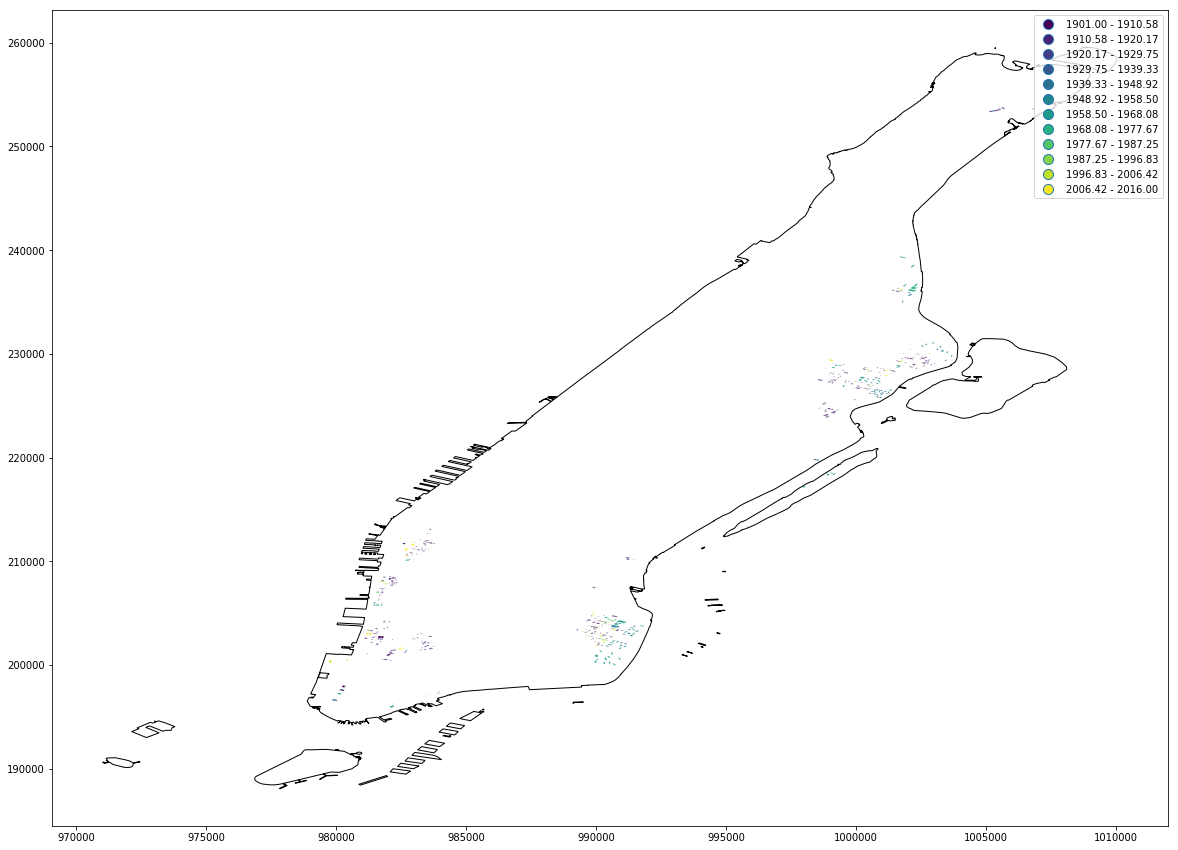

In [844]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==1].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['cnstrct_yr']>1900) &
          (three_way['Borough']=='MN')].plot(column='cnstrct_yr',cmap='viridis',
                                             scheme='Equal_interval',
                                             k=12,legend=True,ax=ax)

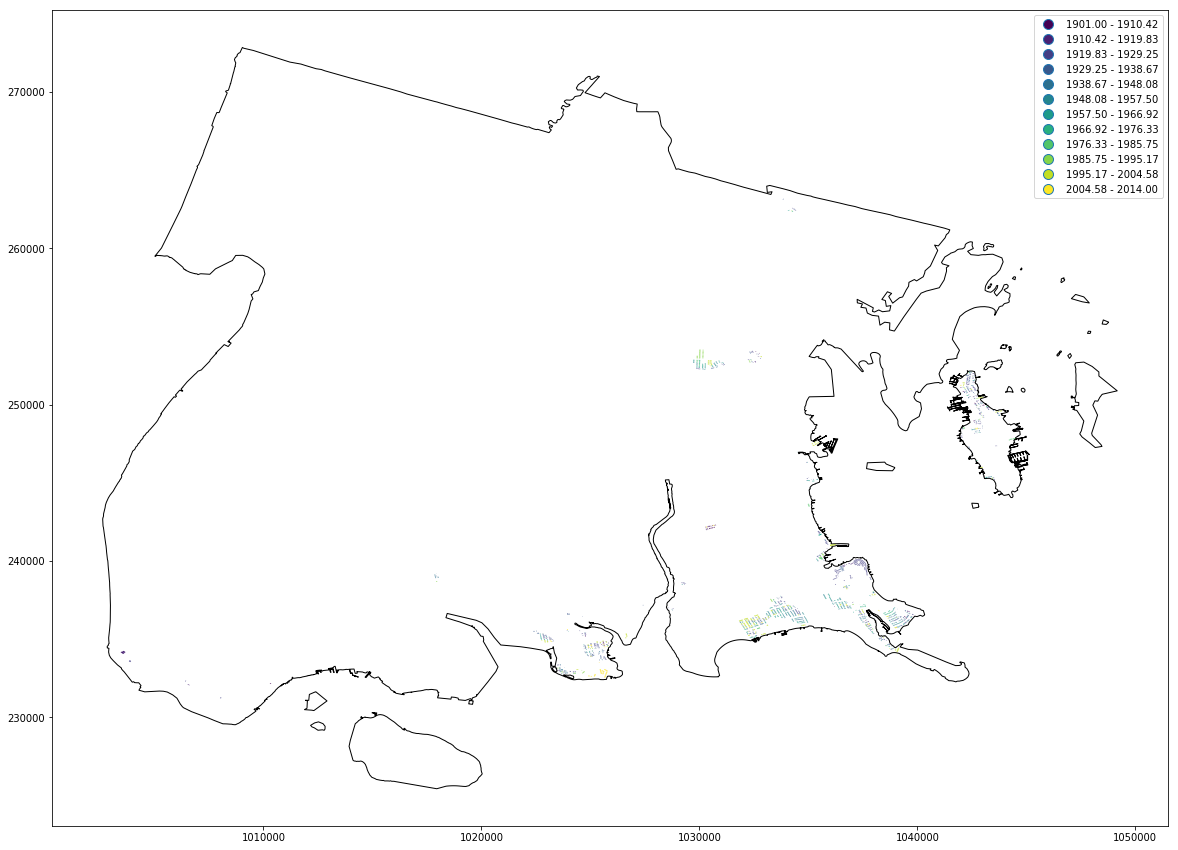

In [845]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==2].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['cnstrct_yr']>1900) &
          (three_way['Borough']=='BX')].plot(column='cnstrct_yr',cmap='viridis',
                                             scheme='Equal_interval',
                                             k=12,legend=True,ax=ax)

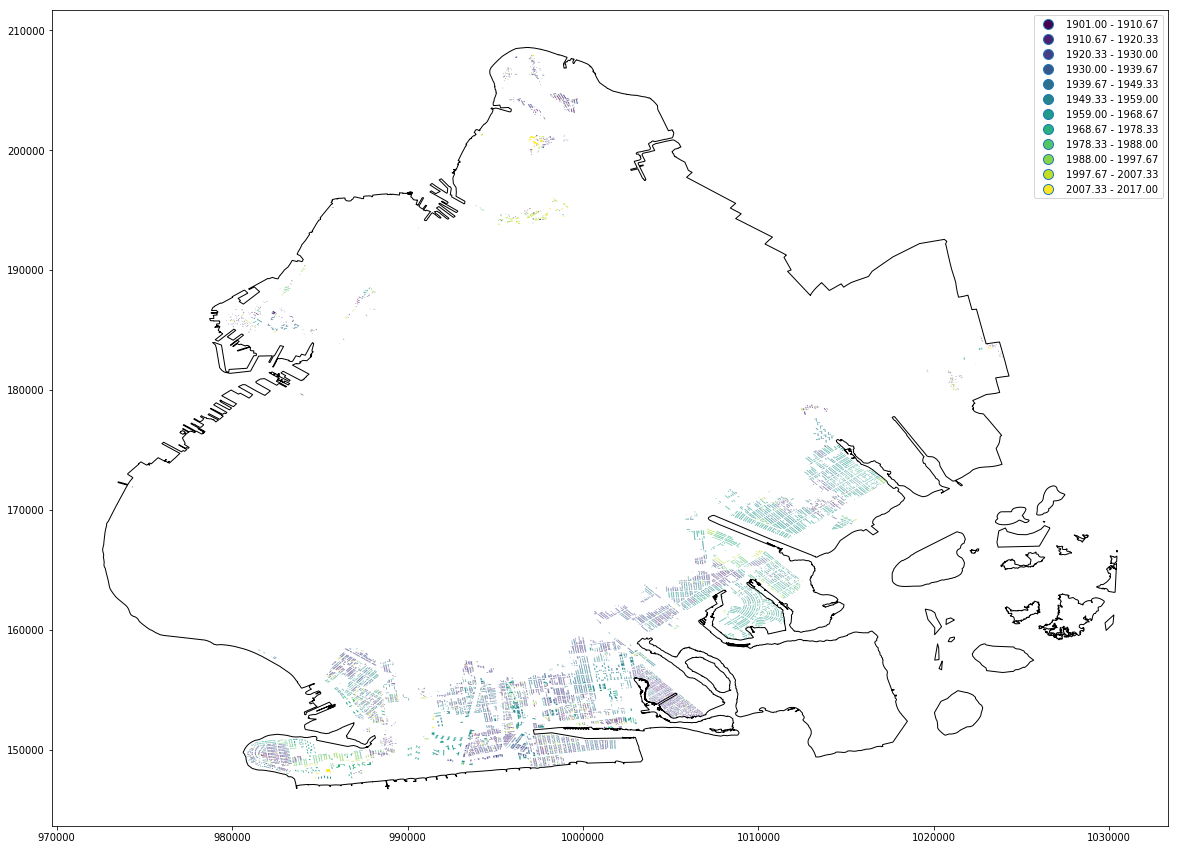

In [846]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==3].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['cnstrct_yr']>1900) &
          (three_way['Borough']=='BK')].plot(column='cnstrct_yr',cmap='viridis',
                                             scheme='Equal_interval',
                                             k=12,legend=True,ax=ax)

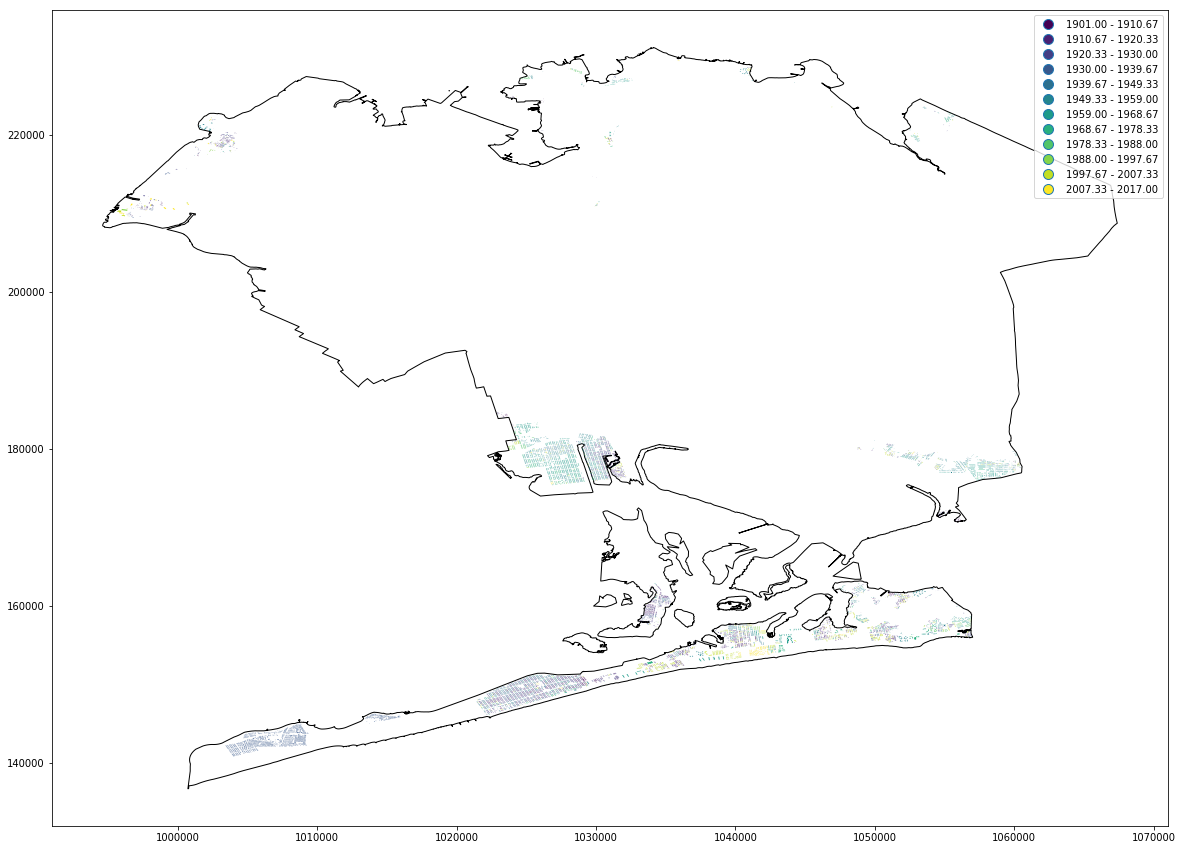

In [847]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==4].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['cnstrct_yr']>1900) &
          (three_way['Borough']=='QN')].plot(column='cnstrct_yr',cmap='viridis',
                                             scheme='Equal_interval',
                                             k=12,legend=True,ax=ax)

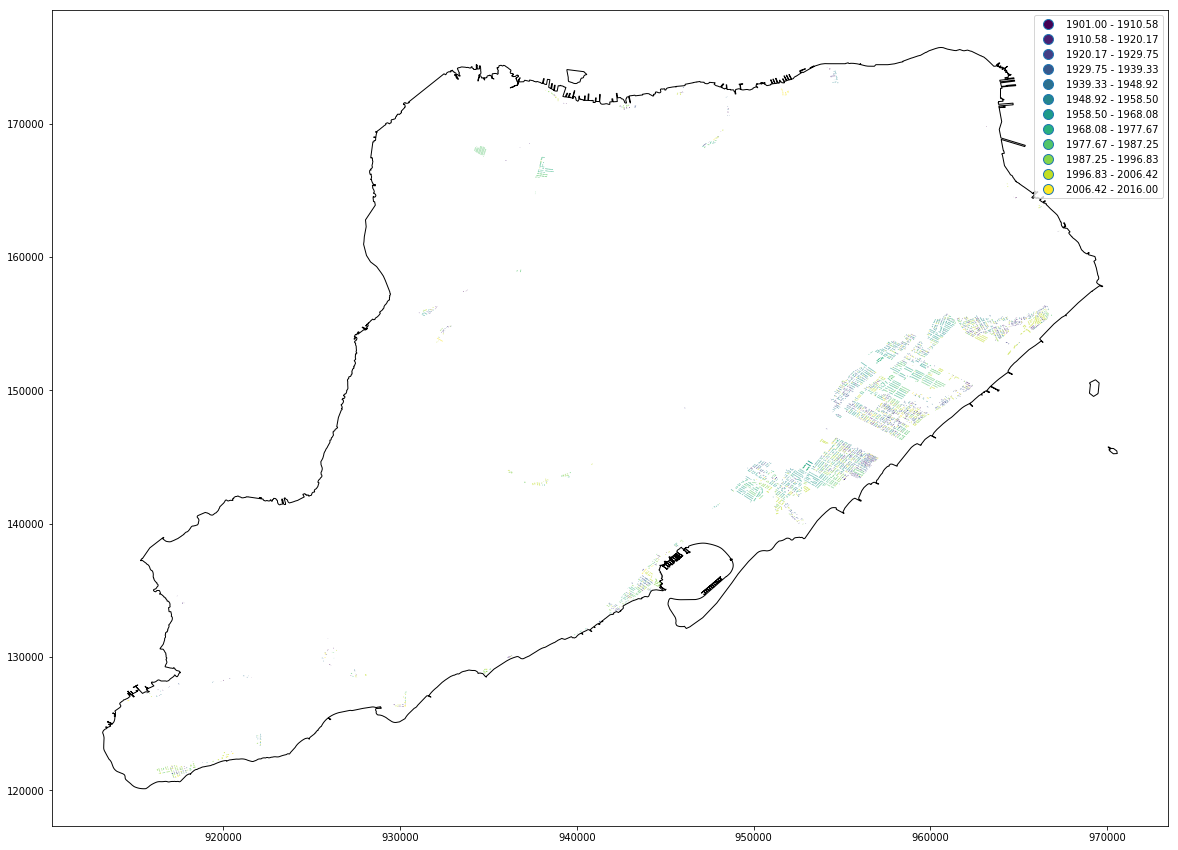

In [848]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==5].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['cnstrct_yr']>1900) &
          (three_way['Borough']=='SI')].plot(column='cnstrct_yr',cmap='viridis',
                                             scheme='Equal_interval',
                                             k=12,legend=True,ax=ax)

In [1243]:
three_way[['cnstrct_yr','groundelev','heightroof','STATIC_BFE','NumFloors']].describe()

cnstrct_yr    groundelev    heightroof    STATIC_BFE     NumFloors
count  74653.000000  74653.000000  74653.000000  74653.000000  74653.000000
mean    1949.124375      9.111797     25.316397  -3615.699918      2.076885
std       27.352860      2.556983     12.094877   4811.320540      1.314434
min     1800.000000     -2.000000      7.000000  -9999.000000      1.000000
25%     1930.000000      7.000000     19.565500  -9999.000000      2.000000
50%     1945.000000      9.000000     25.370000     10.000000      2.000000
75%     1965.000000     11.000000     29.470000     11.000000      2.000000
max     2017.000000     21.000000    394.404914     22.000000     42.000000

# Plot a figure of all the data sets prior to combining

[]

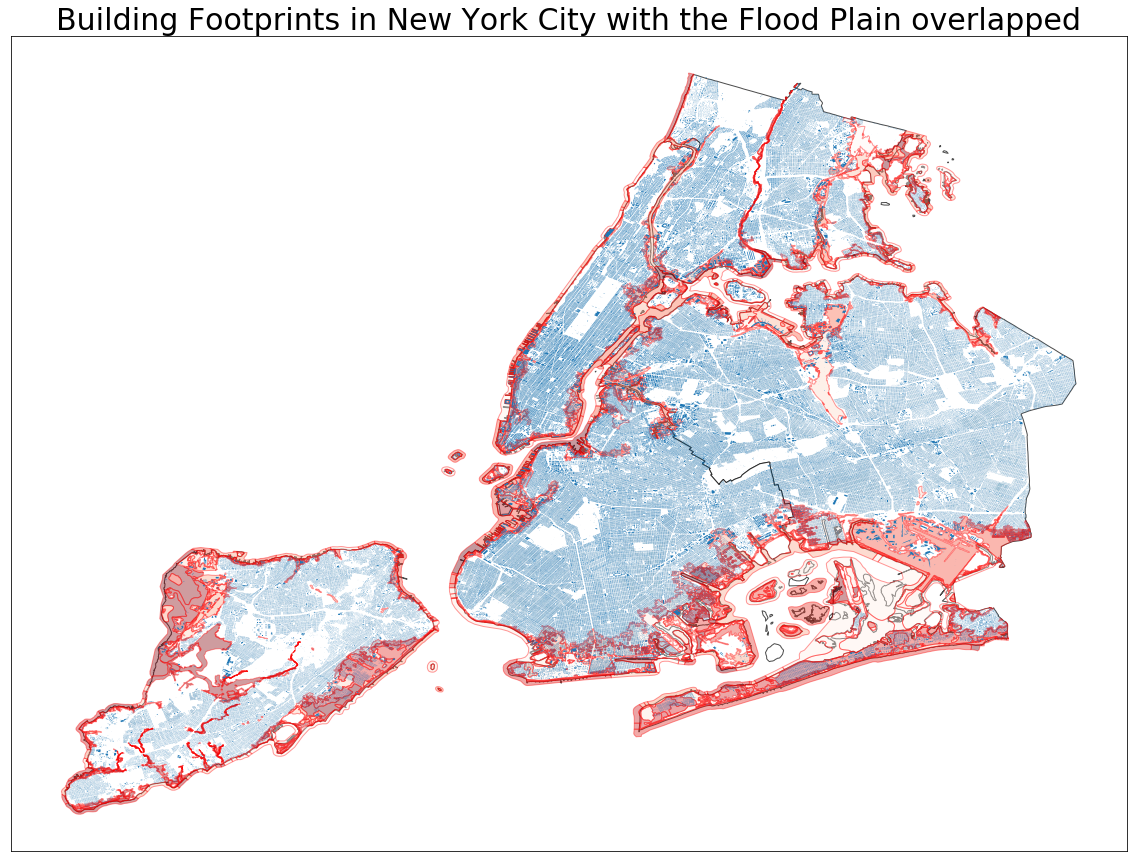

In [850]:
# Setup Figures
fig,ax = plt.subplots(figsize=(20,15))

# Plot Base Plot of Borogughs
baseboro.plot(color='white',edgecolor='black', ax=ax, alpha=0.7)

# Plot Flood Plain
FloodPlain[(FloodPlain.FLD_ZONE <> 'OPEN WATER') & (FloodPlain.FLD_ZONE <> 'X')].plot(cmap='Reds',
                                                                                      alpha=0.4,
                                                                                      ax=ax,
                                                                                      legend=True,
                                                                                      edgecolor='red')

# Plot Building Footprints
Footprintsshp_ft.geometry.plot(ax=ax)

# Format Plot
plt.title('Building Footprints in New York City with the Flood Plain overlapped',fontsize=30)
ax.set_xticks([])
ax.set_yticks([])

# Check Building Heights Data in two columns

In [1244]:
three_way.head()

cnstrct_yr  date_lstmo      bin  groundelev  heightroof         bbl  \
17      1960.0  2017-08-22  2083018        12.0   32.330000  2056540254   
18      1960.0  2017-08-17  2126930        14.0   10.213893  2056540254   
19      1930.0  2017-08-22  2083104        14.0   28.000000  2056550110   
20      1970.0  2017-08-22  2083022        14.0   30.180000  2056540265   
21      1986.0  2017-08-22  2083021        12.0   33.600000  2056540263   

   FLD_AR_ID                            FLD_ZONE  STATIC_BFE Bin #  \
17        81                                  AE        13.0  None   
18        85  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     -9999.0  None   
19        84  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     -9999.0  None   
20        85  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     -9999.0  None   
21        85  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     -9999.0  None   

                          ...                         YearBuilt YearAlter1  \
17                        ...                              1960          0   
18                        ...                              1960          0   
19                        ...                              1930          0   
20                        ...                              1970          0   
21                        ...                              1986          0   

   YearAlter2 BuiltFAR ResidFAR       BBL_y CondoNo  Tract2010  PLUTOMapID  \
17          0     6.76      0.6  2056540254       0        456           1   
18          0     6.76      0.6  2056540254       0        456           1   
19          0     0.33      0.6  2056550110       0        456           1   
20          0     0.31      0.6  2056540265       0        456           1   
21          0     0.61      0.6  2056540263       0        456           1   

                                             geometry  
17  POLYGON ((1034076.282881302 262397.1120663384,...  
18  POLYGON ((1034129.608562063 262445.2353296688,...  
19  POLYGON ((1033866.004758566 263143.0331466591,...  
20  POLYGON ((1034291.044918985 262352.531774908, ...  
21  POLYGON ((1034269.410119724 262393.8000650823,...  

[5 rows x 76 columns]

In [1245]:
three_way.columns

Index([u'cnstrct_yr', u'date_lstmo', u'bin', u'groundelev', u'heightroof',
       u'bbl', u'FLD_AR_ID', u'FLD_ZONE', u'STATIC_BFE', u'Bin #', u'Job Type',
       u'Job Status Descrp', u'Latest Action Date', u'Building Type',
       u'City Owned', u'Other Description', u'Approved',
       u'ExistingNo. of Stories', u'Proposed No. of Stories',
       u'Existing Height', u'Proposed Height', u'Existing Dwelling Units',
       u'Proposed Dwelling Units', u'Existing Occupancy',
       u'Proposed Occupancy', u'Job Description', u'BBL_x', u'Borough', u'CD',
       u'CT2010', u'CB2010', u'ZoneDist1', u'ZoneDist2', u'ZoneDist3',
       u'ZoneDist4', u'LtdHeight', u'SplitZone', u'BldgClass', u'LandUse',
       u'LotArea', u'BldgArea', u'ComArea', u'ResArea', u'OfficeArea',
       u'RetailArea', u'GarageArea', u'StrgeArea', u'FactryArea', u'OtherArea',
       u'AreaSource', u'NumBldgs', u'NumFloors', u'UnitsRes', u'UnitsTotal',
       u'LotFront', u'LotDepth', u'BldgFront', u'BldgDepth', u'Ext',
 

# Set Average Floor Height to ? and Calculate LFE for each building

In [1246]:
Avg_Floor_Ht = 10

In [1247]:
three_way["HeightDiff"] = three_way.heightroof - three_way['Existing Height']
three_way["LFE_est"] = three_way.groundelev + three_way.heightroof - (three_way.NumFloors * Avg_Floor_Ht)
three_way["BFE_LFEest_diff"] = three_way["LFE_est"] - three_way["STATIC_BFE"]

three_way.head()

cnstrct_yr  date_lstmo      bin  groundelev  heightroof         bbl  \
17      1960.0  2017-08-22  2083018        12.0   32.330000  2056540254   
18      1960.0  2017-08-17  2126930        14.0   10.213893  2056540254   
19      1930.0  2017-08-22  2083104        14.0   28.000000  2056550110   
20      1970.0  2017-08-22  2083022        14.0   30.180000  2056540265   
21      1986.0  2017-08-22  2083021        12.0   33.600000  2056540263   

   FLD_AR_ID                            FLD_ZONE  STATIC_BFE Bin #  \
17        81                                  AE        13.0  None   
18        85  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     -9999.0  None   
19        84  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     -9999.0  None   
20        85  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     -9999.0  None   
21        85  0.2 PCT ANNUAL CHANCE FLOOD HAZARD     -9999.0  None   

         ...        BuiltFAR ResidFAR       BBL_y CondoNo Tract2010  \
17       ...            6.76      0.6  2056540254       0       456   
18       ...            6.76      0.6  2056540254       0       456   
19       ...            0.33      0.6  2056550110       0       456   
20       ...            0.31      0.6  2056540265       0       456   
21       ...            0.61      0.6  2056540263       0       456   

   PLUTOMapID                                           geometry  HeightDiff  \
17          1  POLYGON ((1034076.282881302 262397.1120663384,...         NaN   
18          1  POLYGON ((1034129.608562063 262445.2353296688,...         NaN   
19          1  POLYGON ((1033866.004758566 263143.0331466591,...         NaN   
20          1  POLYGON ((1034291.044918985 262352.531774908, ...         NaN   
21          1  POLYGON ((1034269.410119724 262393.8000650823,...         NaN   

      LFE_est  BFE_LFEest_diff  
17  24.330000        11.330000  
18   4.213893     10003.213893  
19  25.300000     10024.300000  
20  24.180000     10023.180000  
21  15.600000     10014.600000  

[5 rows x 79 columns]

In [1248]:
# Remove STATIC BFE's that are not true <0
three_way = three_way[three_way.STATIC_BFE>0]
# Check shape, we lose 25000 data points
three_way.shape

(47607, 79)

In [1249]:
# COnvert approved data to date
three_way.Approved = pd.to_datetime(three_way.Approved)

In [1250]:
# Check Building permit approved dates to see if permits are approved after Lidar Data Capture
three_way.Approved[three_way.Approved<'06/24/2014'].unique()

array(['2013-06-12T00:00:00.000000000'], dtype='datetime64[ns]')

In [1251]:
# There's only one data point like this
three_way.Approved[three_way.Approved<'06/24/2014'].count()

1

All buildings with data indicate that they were captured after the LIDAR measurements were taken, which could lead to a problem regarding accuracy with building heights.

# Check Calculated LFE and LFE and BFE difference

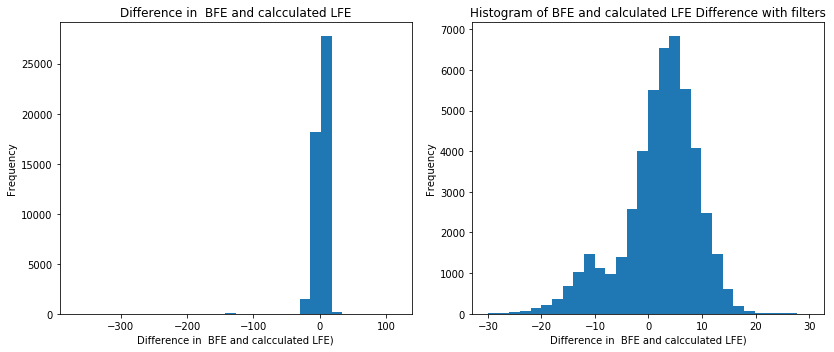

In [1252]:
#Set total figure size
plt.figure(figsize=(12,5))

# Plot Basic Histogram for LFe  and BFE Diff
plt.subplot(121)
plt.hist(three_way.BFE_LFEest_diff, bins = 30)

# Formatting
plt.xlabel("Difference in  BFE and calcculated LFE)",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Difference in  BFE and calcculated LFE",fontsize=12)
#plt.ylim(0,100)
#plt.xlim(0,100)

# Plot Histogram for LFE and BFE Diff 
plt.subplot(122)
plt.hist(three_way.BFE_LFEest_diff[(three_way.BFE_LFEest_diff>-30) & (three_way.BFE_LFEest_diff<30)], bins = 30)

# Formatting
plt.xlabel("Difference in  BFE and calcculated LFE)",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Histogram of BFE and calculated LFE Difference with filters",fontsize=12)


plt.tight_layout()

In [1253]:
three_way.shape

(47607, 79)

In [1255]:
# Drop Data that does not make sense
three_way = three_way[(three_way.BFE_LFEest_diff>-20) & (three_way.BFE_LFEest_diff<20)]
three_way.shape # lose 500 data points

(47097, 79)

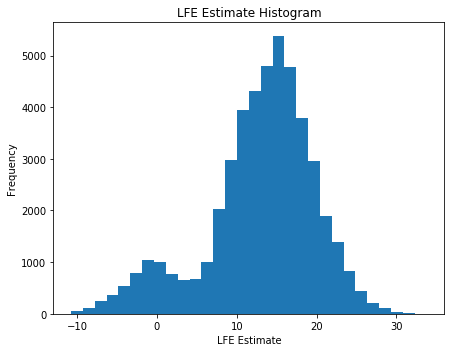

In [1256]:
#Set total figure size
plt.figure(figsize=(12,5))

# Plot Basic Histogram for LFe  and BFE Diff
plt.subplot(121)
plt.hist(three_way.LFE_est, bins = 30)

# Formatting
plt.xlabel("LFE Estimate",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("LFE Estimate Histogram",fontsize=12)
#plt.ylim(0,100)
#plt.xlim(0,100)

plt.tight_layout()

This doesn't make sense that we have so much data below 0 LFE. Should we get rid of this data?
Potentially get rid of all data below 0 or -2

# Should we get rid of data below 0 LFE
We can see from validation the the number of floors data seems to be incorrect

In [1257]:
DOBBuildings = three_way.dropna(subset=["Bin #"])
DOBBuildings.shape

(1488, 79)

In [1258]:
len(DOBBuildings['Bin #'].unique())

968

In [1259]:
DOBBuildings.head()

cnstrct_yr  date_lstmo      bin  groundelev  heightroof         bbl  \
1077      1925.0  2017-08-22  3250106         8.0   18.997472  3089390908   
1078      1925.0  2017-08-22  3250106         8.0   18.997472  3089390908   
1079      1925.0  2017-08-22  3250106         8.0   18.997472  3089390908   
1080      1925.0  2017-08-22  3250106         8.0   18.997472  3089390908   
1081      1925.0  2017-08-22  3250106         8.0   18.997472  3089390908   

     FLD_AR_ID FLD_ZONE  STATIC_BFE    Bin #       ...        BuiltFAR  \
1077       130       AE        11.0  3250106       ...            0.31   
1078       130       AE        11.0  3250106       ...            0.31   
1079       130       AE        11.0  3250106       ...            0.31   
1080       130       AE        11.0  3250106       ...            0.31   
1081       130       AE        11.0  3250106       ...            0.31   

     ResidFAR       BBL_y CondoNo Tract2010 PLUTOMapID  \
1077      0.9  3089390908       0       628          1   
1078      0.9  3089390908       0       628          1   
1079      0.9  3089390908       0       628          1   
1080      0.9  3089390908       0       628          1   
1081      0.9  3089390908       0       628          1   

                                               geometry  HeightDiff   LFE_est  \
1077  POLYGON ((1004189.155647812 155896.5265114942,...   -8.002528  9.497472   
1078  POLYGON ((1004189.155647812 155896.5265114942,...   -8.002528  9.497472   
1079  POLYGON ((1004189.155647812 155896.5265114942,...   -1.002528  9.497472   
1080  POLYGON ((1004189.155647812 155896.5265114942,...   -1.002528  9.497472   
1081  POLYGON ((1004189.155647812 155896.5265114942,...   -1.002528  9.497472   

      BFE_LFEest_diff  
1077        -1.502528  
1078        -1.502528  
1079        -1.502528  
1080        -1.502528  
1081        -1.502528  

[5 rows x 79 columns]

In [1260]:
# Minimum date for Building permits is after LIDAR Date 
min(DOBBuildings['Latest Action Date'])

u'01/02/2015'

In [1261]:
# Number of failed or disapproved permits
DOBBuildings.groupby('Job Status Descrp').count()['cnstrct_yr']

Job Status Descrp
APPLICATION ASSIGNED TO PLAN EXAMINER    179
APPLICATION PROCESSED - ENTIRE           882
APPLICATION PROCESSED - NO PLAN EXAM      44
PERMIT ISSUED - ENTIRE JOB/WORK           45
PERMIT ISSUED - PARTIAL JOB                4
PLAN EXAM - APPROVED                      32
PLAN EXAM - DISAPPROVED                   27
PLAN EXAM - IN PROCESS                   261
PRE-FILING                                14
Name: cnstrct_yr, dtype: int64

# Checking Specific Buildings

In [1262]:
three_way[three_way.bin=='3250168']

cnstrct_yr  date_lstmo      bin  groundelev  heightroof         bbl  \
1094      1945.0  2017-08-22  3250168         6.0     23.3216  3089460848   
1095      1945.0  2017-08-22  3250168         6.0     23.3216  3089460848   

     FLD_AR_ID FLD_ZONE  STATIC_BFE    Bin #       ...        BuiltFAR  \
1094       130       AE        11.0  3250168       ...            0.64   
1095       130       AE        11.0  3250168       ...            0.64   

     ResidFAR       BBL_y CondoNo Tract2010 PLUTOMapID  \
1094      0.9  3089460848       0       628          1   
1095      0.9  3089460848       0       628          1   

                                               geometry  HeightDiff  LFE_est  \
1094  POLYGON ((1004198.310157063 155975.9928879922,...      8.3216  12.6216   
1095  POLYGON ((1004198.310157063 155975.9928879922,...      0.3216  12.6216   

      BFE_LFEest_diff  
1094           1.6216  
1095           1.6216  

[2 rows x 79 columns]

In [1263]:
test = three_way[['bin','Existing Height','Proposed Height','HeightDiff','heightroof','groundelev','NumFloors','STATIC_BFE','LFE_est','BFE_LFEest_diff']]
test.head()

bin  Existing Height  Proposed Height  HeightDiff  heightroof  \
17   2083018              NaN              NaN         NaN   32.330000   
97   2125717              NaN              NaN         NaN   13.440920   
98   2119248              NaN              NaN         NaN   34.391168   
99   2082339              NaN              NaN         NaN   30.030000   
100  2082336              NaN              NaN         NaN   26.170426   

     groundelev  NumFloors  STATIC_BFE    LFE_est  BFE_LFEest_diff  
17         12.0        2.0        13.0  24.330000        11.330000  
97          9.0        2.0        14.0   2.440920       -11.559080  
98         10.0        2.0        14.0  24.391168        10.391168  
99          7.0        2.0        14.0  17.030000         3.030000  
100         8.0        2.5        14.0   9.170426        -4.829574

In [1264]:
test[test.bin=='3250168']

bin  Existing Height  Proposed Height  HeightDiff  heightroof  \
1094  3250168             15.0             15.0      8.3216     23.3216   
1095  3250168             23.0             23.0      0.3216     23.3216   

      groundelev  NumFloors  STATIC_BFE  LFE_est  BFE_LFEest_diff  
1094         6.0       1.67        11.0  12.6216           1.6216  
1095         6.0       1.67        11.0  12.6216           1.6216

In [1265]:
test.describe()

Existing Height  Proposed Height   HeightDiff    heightroof  \
count      1488.000000      1488.000000  1488.000000  47097.000000   
mean         23.307124        25.756720     1.181828     24.910066   
std          17.692065        17.172019    11.174417      9.787250   
min           0.000000         0.000000   -27.580000      7.020000   
25%                NaN              NaN          NaN     19.220000   
50%                NaN              NaN          NaN     25.250000   
75%                NaN              NaN          NaN     29.640000   
max         160.000000       160.000000    64.110000    198.400000   

         groundelev     NumFloors    STATIC_BFE       LFE_est  BFE_LFEest_diff  
count  47097.000000  47097.000000  47097.000000  47097.000000     47097.000000  
mean       7.790624      1.977269     10.712551     12.927995         2.215444  
std        1.880013      0.906408      1.081844      6.855594         6.834279  
min       -2.000000      1.000000      8.000000    -10.751215       -19.996212  
25%        7.000000      1.500000     10.000000      9.824422        -1.000000  
50%        8.000000      2.000000     10.000000     13.950884         3.195231  
75%        9.000000      2.000000     11.000000     17.400000         6.816859  
max       19.000000     20.000000     22.000000     33.770000        19.851481

# Import and Merge Actual LFE data acquired


In [1266]:
Actual_LFE = pd.read_csv('https://raw.githubusercontent.com/andrewnell/CAUI2017_'\
                         'adn323/master/Project_AtRisk_Flood_Buildings/LFE_Actual'\
                         '_Data.csv',sep=';',names={'bin','LFE_Actual'},header=0)


In [1267]:
Actual_LFE.replace(',','.',regex=True,inplace=True)

Actual_LFE.LFE_Actual = Actual_LFE.LFE_Actual.astype(float)
Actual_LFE.bin = Actual_LFE.bin.astype(str)

In [1268]:
Actual_LFE.head()

bin  LFE_Actual
0  4304822        13.2
1  4301237        18.7
2  4301237        18.7
3  4301237        18.7
4  4301249        15.1

In [1269]:
Actual_LFE.dtypes

bin            object
LFE_Actual    float64
dtype: object

In [1270]:
Actual_LFE.columns

Index([u'bin', u'LFE_Actual'], dtype='object')

In [1271]:
Actual_LFE.dtypes

bin            object
LFE_Actual    float64
dtype: object

In [1272]:
three_way = three_way.merge(Actual_LFE,on='bin',how='outer')

In [1273]:
three_way['BFE_LFEact_diff'] = three_way["LFE_Actual"] - three_way["STATIC_BFE"]

In [1274]:
three_way.head()

cnstrct_yr  date_lstmo      bin  groundelev  heightroof         bbl  \
0      1960.0  2017-08-22  2083018        12.0   32.330000  2056540254   
1      2009.0  2017-08-17  2125717         9.0   13.440920  2056330158   
2      2009.0  2017-08-22  2119248        10.0   34.391168  2056330158   
3      1920.0  2017-08-22  2082339         7.0   30.030000  2056340066   
4      1910.0  2017-08-22  2082336         8.0   26.170426  2056340054   

  FLD_AR_ID FLD_ZONE  STATIC_BFE Bin #       ...              BBL_y CondoNo  \
0        81       AE        13.0  None       ...         2056540254       0   
1        93       AE        14.0  None       ...         2056330158       0   
2        93       AE        14.0  None       ...         2056330158       0   
3        93       AE        14.0  None       ...         2056340066       0   
4        93       AE        14.0  None       ...         2056340054       0   

  Tract2010 PLUTOMapID                                           geometry  \
0       456          1  POLYGON ((1034076.282881302 262397.1120663384,...   
1       516          1  POLYGON ((1042678.135756314 248486.4361475795,...   
2       516          1  POLYGON ((1042676.81062773 248473.847590086, 1...   
3       516          1  POLYGON ((1042612.891792315 248874.6355024203,...   
4       516          1  POLYGON ((1042638.565297395 248968.5644484094,...   

  HeightDiff    LFE_est  BFE_LFEest_diff  LFE_Actual  BFE_LFEact_diff  
0        NaN  24.330000        11.330000         NaN              NaN  
1        NaN   2.440920       -11.559080         NaN              NaN  
2        NaN  24.391168        10.391168         NaN              NaN  
3        NaN  17.030000         3.030000         NaN              NaN  
4        NaN   9.170426        -4.829574         NaN              NaN  

[5 rows x 81 columns]

# Draw some maps

In [1275]:
three_way.groupby(by='LandUse').count()

cnstrct_yr  date_lstmo    bin  groundelev  heightroof    bbl  \
LandUse                                                                 
1.0           40864       40864  40864       40864       40864  40864   
2.0            5900        5900   5900        5900        5900   5900   
3.0             411         411    411         411         411    411   

         FLD_AR_ID  FLD_ZONE  STATIC_BFE  Bin #       ...         BBL_y  \
LandUse                                               ...                 
1.0          40864     40864       40864   1435       ...         40864   
2.0           5900      5900        5900     57       ...          5900   
3.0            411       411         411     74       ...           411   

         CondoNo  Tract2010  PLUTOMapID  geometry  HeightDiff  LFE_est  \
LandUse                                                                  
1.0        40864      40864       40864     40864        1435    40864   
2.0         5900       5900        5900      5900          57     5900   
3.0          411        411         411       411          74      411   

         BFE_LFEest_diff  LFE_Actual  BFE_LFEact_diff  
LandUse                                                
1.0                40864         226              226  
2.0                 5900           4                4  
3.0                  411           0                0  

[3 rows x 80 columns]

[]

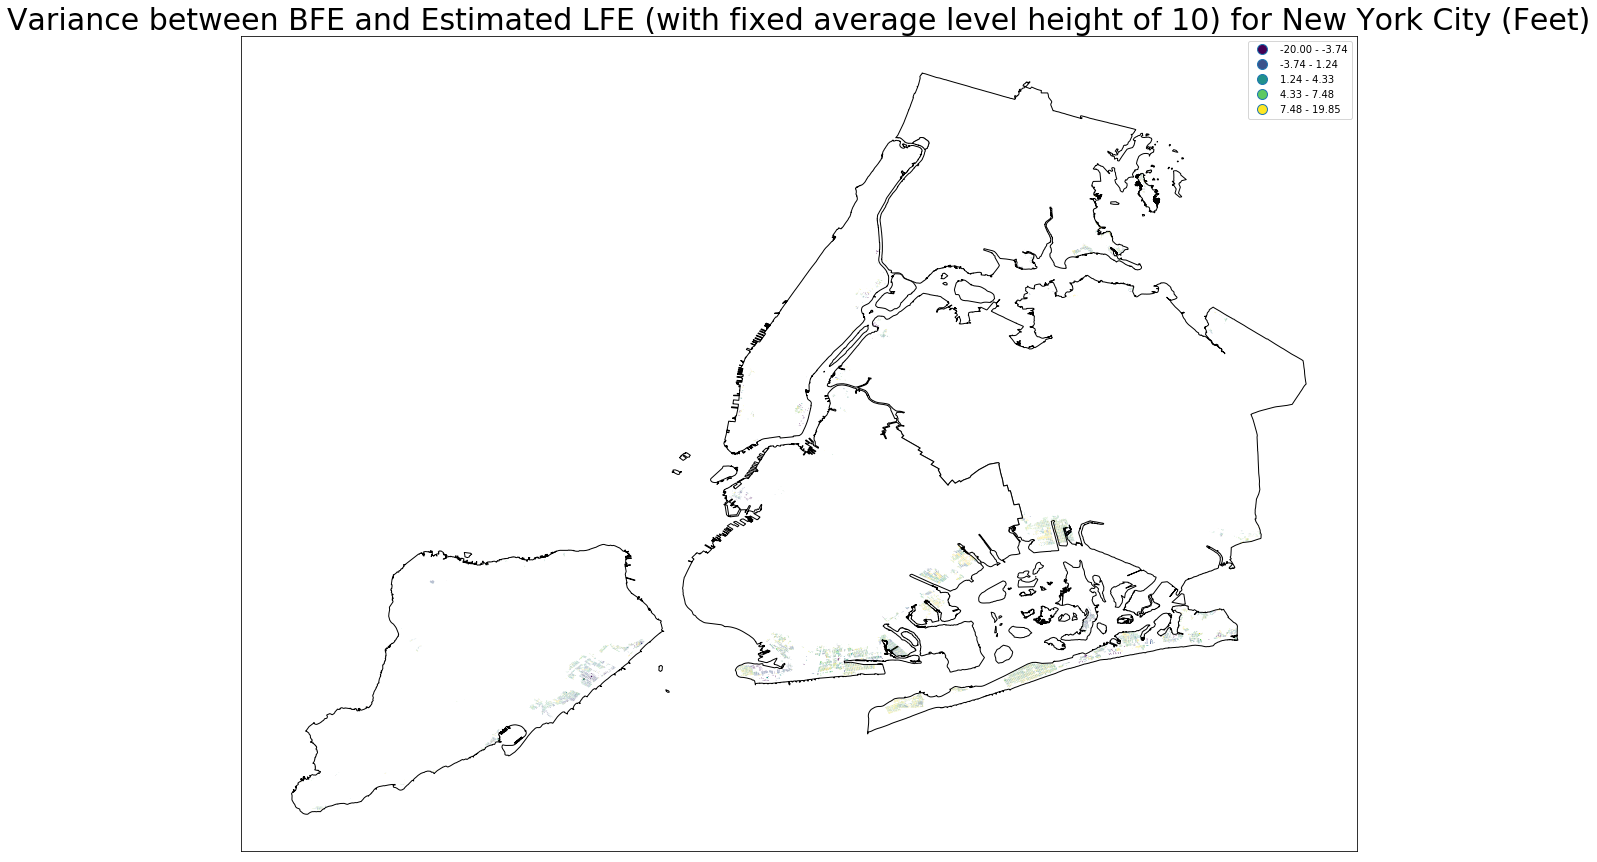

In [1026]:
# Plot Figure with base plot
fig,ax = plt.subplots(figsize=(20,15))
base = baseboro.plot(color='white',edgecolor='black', ax=ax)
three_way.plot(column='BFE_LFEest_diff',cmap='viridis',scheme='Quantiles',k=5,legend=True,ax=ax)

# Format Plot
plt.title('Variance between BFE and Estimated LFE (with fixed average level height of 10) for New York City (Feet)',fontsize=30)
ax.set_xticks([])
ax.set_yticks([])

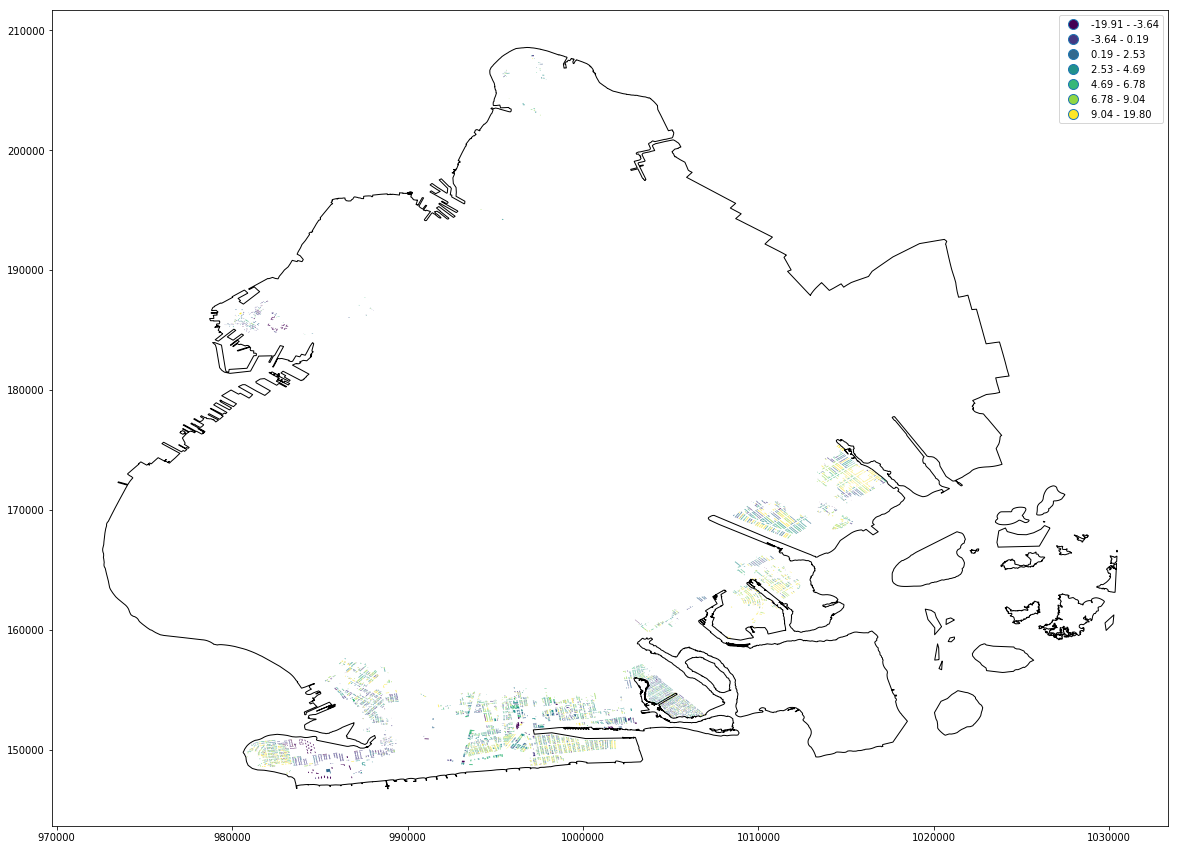

In [1027]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==3].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['Borough']=='BK')].plot(column='BFE_LFEest_diff',cmap='viridis',scheme='Quantiles',k=7,legend=True,ax=ax)


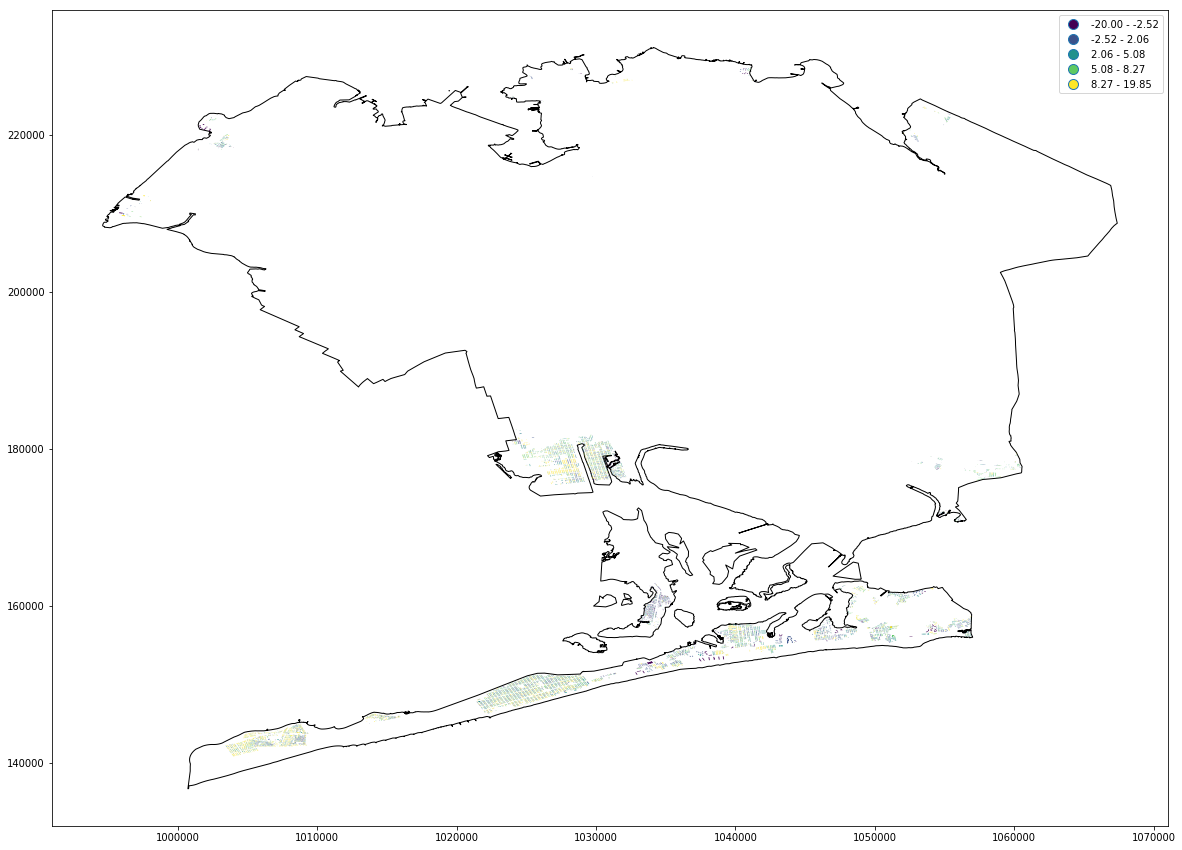

In [1030]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==4].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['Borough']=='QN')].plot(column='BFE_LFEest_diff',cmap='viridis',scheme='Quantiles',k=5,legend=True,ax=ax)

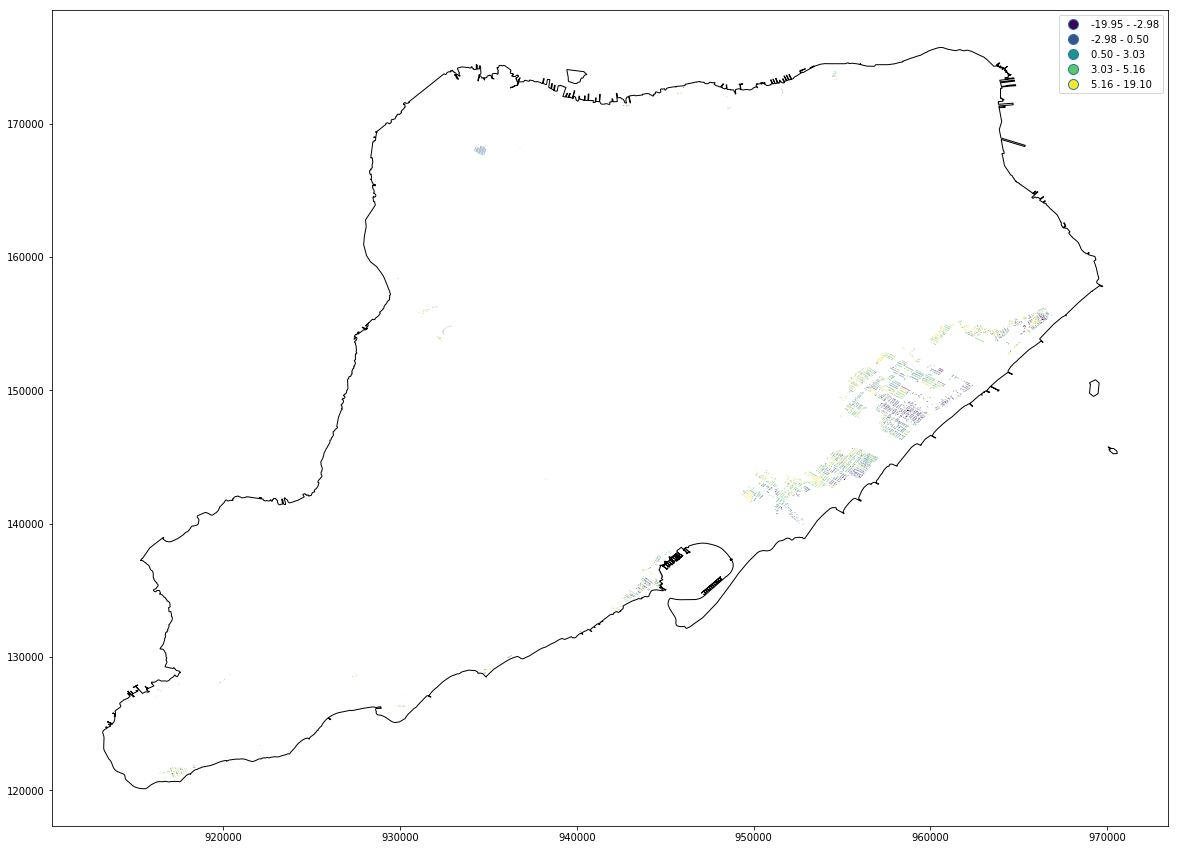

In [1276]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==5].plot(color='white',edgecolor='black', ax=ax)
three_way[(three_way['Borough']=='SI')].plot(column='BFE_LFEest_diff',cmap='viridis',scheme='Quantiles',k=5,legend=True,ax=ax)

# Output Data

In [1032]:
#Need to drop Approved due to data type
three_way.drop(['Approved'],axis=1,inplace=True)

ValueError: labels ['Approved'] not contained in axis

In [1049]:
# Output data sets
three_way.to_csv('Processed_Data.csv')
three_way.to_file('Processed_Data.shp', driver='ESRI Shapefile')
DOBBuildings.to_csv('DOBBuildings.csv')


This warning will not be emitted any more for that layer.


In [1050]:
# Move all shapefiles to new directory
os.system('mkdir ProcessedShapefile')
os.system('mv Processed_Data.shp ProcessedShapefile')
os.system('mv Processed_Data.cpg ProcessedShapefile')
os.system('mv Processed_Data.dbf ProcessedShapefile')
os.system('mv Processed_Data.prj ProcessedShapefile')
os.system('mv Processed_Data.cpg ProcessedShapefile')
os.system('mv Processed_Data.shx ProcessedShapefile')

0

In [1277]:
three_way.columns

Index([u'cnstrct_yr', u'date_lstmo', u'bin', u'groundelev', u'heightroof',
       u'bbl', u'FLD_AR_ID', u'FLD_ZONE', u'STATIC_BFE', u'Bin #', u'Job Type',
       u'Job Status Descrp', u'Latest Action Date', u'Building Type',
       u'City Owned', u'Other Description', u'Approved',
       u'ExistingNo. of Stories', u'Proposed No. of Stories',
       u'Existing Height', u'Proposed Height', u'Existing Dwelling Units',
       u'Proposed Dwelling Units', u'Existing Occupancy',
       u'Proposed Occupancy', u'Job Description', u'BBL_x', u'Borough', u'CD',
       u'CT2010', u'CB2010', u'ZoneDist1', u'ZoneDist2', u'ZoneDist3',
       u'ZoneDist4', u'LtdHeight', u'SplitZone', u'BldgClass', u'LandUse',
       u'LotArea', u'BldgArea', u'ComArea', u'ResArea', u'OfficeArea',
       u'RetailArea', u'GarageArea', u'StrgeArea', u'FactryArea', u'OtherArea',
       u'AreaSource', u'NumBldgs', u'NumFloors', u'UnitsRes', u'UnitsTotal',
       u'LotFront', u'LotDepth', u'BldgFront', u'BldgDepth', u'Ext',
 

In [1278]:

three_way.head()

cnstrct_yr  date_lstmo      bin  groundelev  heightroof         bbl  \
0      1960.0  2017-08-22  2083018        12.0   32.330000  2056540254   
1      2009.0  2017-08-17  2125717         9.0   13.440920  2056330158   
2      2009.0  2017-08-22  2119248        10.0   34.391168  2056330158   
3      1920.0  2017-08-22  2082339         7.0   30.030000  2056340066   
4      1910.0  2017-08-22  2082336         8.0   26.170426  2056340054   

  FLD_AR_ID FLD_ZONE  STATIC_BFE Bin #       ...              BBL_y CondoNo  \
0        81       AE        13.0  None       ...         2056540254       0   
1        93       AE        14.0  None       ...         2056330158       0   
2        93       AE        14.0  None       ...         2056330158       0   
3        93       AE        14.0  None       ...         2056340066       0   
4        93       AE        14.0  None       ...         2056340054       0   

  Tract2010 PLUTOMapID                                           geometry  \
0       456          1  POLYGON ((1034076.282881302 262397.1120663384,...   
1       516          1  POLYGON ((1042678.135756314 248486.4361475795,...   
2       516          1  POLYGON ((1042676.81062773 248473.847590086, 1...   
3       516          1  POLYGON ((1042612.891792315 248874.6355024203,...   
4       516          1  POLYGON ((1042638.565297395 248968.5644484094,...   

  HeightDiff    LFE_est  BFE_LFEest_diff  LFE_Actual  BFE_LFEact_diff  
0        NaN  24.330000        11.330000         NaN              NaN  
1        NaN   2.440920       -11.559080         NaN              NaN  
2        NaN  24.391168        10.391168         NaN              NaN  
3        NaN  17.030000         3.030000         NaN              NaN  
4        NaN   9.170426        -4.829574         NaN              NaN  

[5 rows x 81 columns]

In [1279]:
tabe = pd.read_csv('Threeway.csv')
tabe.head()

Unnamed: 0  cnstrct_yr  date_lstmo      bin  groundelev  heightroof  \
0           0      1942.0  2014-07-18  2095149        11.0   28.240000   
1           1      1942.0  2017-08-22  2095150        12.0   13.450000   
2           2      1942.0  2014-07-18  2095146         8.0   14.940000   
3           3      1958.0  2017-08-22  2067198        11.0    9.140000   
4           4      1958.0  2014-07-18  2095148        10.0   19.094666   

          bbl                                           geometry  FLD_AR_ID  \
0  2049740070  POLYGON ((1032115.225779818 263604.5643758191,...         81   
1  2049740070  POLYGON ((1032062.329888226 263689.7298879102,...         81   
2  2049740070  POLYGON ((1032515.749913137 263468.8799359164,...         81   
3  2049740088  POLYGON ((1032068.150086567 263717.9001071612,...         81   
4  2049740088  POLYGON ((1032161.539991645 263703.4700179226,...         81   

  FLD_ZONE     ...      ExemptTot  YearBuilt YearAlter1 YearAlter2 BuiltFAR  \
0       AE     ...            0.0       1942          0          0     0.01   
1       AE     ...            0.0       1942          0          0     0.01   
2       AE     ...            0.0       1942          0          0     0.01   
3       AE     ...            0.0       1958          0          0     0.05   
4       AE     ...            0.0       1958          0          0     0.05   

  ResidFAR       BBL_y CondoNo Tract2010  PLUTOMapID  
0      0.0  2049740070       0       456           1  
1      0.0  2049740070       0       456           1  
2      0.0  2049740070       0       456           1  
3      0.0  2049740088       0       456           1  
4      0.0  2049740088       0       456           1  

[5 rows x 77 columns]

In [1280]:
tabe.groupby('LandUse').count()['PLUTOMapID']

LandUse
1.0     63769
2.0     10369
3.0      1147
4.0      3110
5.0      1975
6.0      1866
7.0      1309
8.0       983
9.0       753
10.0      864
11.0      525
Name: PLUTOMapID, dtype: int64

In [1281]:
three_way.groupby('LandUse').count()

cnstrct_yr  date_lstmo    bin  groundelev  heightroof    bbl  \
LandUse                                                                 
1.0           40864       40864  40864       40864       40864  40864   
2.0            5900        5900   5900        5900        5900   5900   
3.0             411         411    411         411         411    411   

         FLD_AR_ID  FLD_ZONE  STATIC_BFE  Bin #       ...         BBL_y  \
LandUse                                               ...                 
1.0          40864     40864       40864   1435       ...         40864   
2.0           5900      5900        5900     57       ...          5900   
3.0            411       411         411     74       ...           411   

         CondoNo  Tract2010  PLUTOMapID  geometry  HeightDiff  LFE_est  \
LandUse                                                                  
1.0        40864      40864       40864     40864        1435    40864   
2.0         5900       5900        5900      5900          57     5900   
3.0          411        411         411       411          74      411   

         BFE_LFEest_diff  LFE_Actual  BFE_LFEact_diff  
LandUse                                                
1.0                40864         226              226  
2.0                 5900           4                4  
3.0                  411           0                0  

[3 rows x 80 columns]

In [1282]:
three_way.shape

(47175, 81)

In [1283]:
testing = three_way
testing.head()

cnstrct_yr  date_lstmo      bin  groundelev  heightroof         bbl  \
0      1960.0  2017-08-22  2083018        12.0   32.330000  2056540254   
1      2009.0  2017-08-17  2125717         9.0   13.440920  2056330158   
2      2009.0  2017-08-22  2119248        10.0   34.391168  2056330158   
3      1920.0  2017-08-22  2082339         7.0   30.030000  2056340066   
4      1910.0  2017-08-22  2082336         8.0   26.170426  2056340054   

  FLD_AR_ID FLD_ZONE  STATIC_BFE Bin #       ...              BBL_y CondoNo  \
0        81       AE        13.0  None       ...         2056540254       0   
1        93       AE        14.0  None       ...         2056330158       0   
2        93       AE        14.0  None       ...         2056330158       0   
3        93       AE        14.0  None       ...         2056340066       0   
4        93       AE        14.0  None       ...         2056340054       0   

  Tract2010 PLUTOMapID                                           geometry  \
0       456          1  POLYGON ((1034076.282881302 262397.1120663384,...   
1       516          1  POLYGON ((1042678.135756314 248486.4361475795,...   
2       516          1  POLYGON ((1042676.81062773 248473.847590086, 1...   
3       516          1  POLYGON ((1042612.891792315 248874.6355024203,...   
4       516          1  POLYGON ((1042638.565297395 248968.5644484094,...   

  HeightDiff    LFE_est  BFE_LFEest_diff  LFE_Actual  BFE_LFEact_diff  
0        NaN  24.330000        11.330000         NaN              NaN  
1        NaN   2.440920       -11.559080         NaN              NaN  
2        NaN  24.391168        10.391168         NaN              NaN  
3        NaN  17.030000         3.030000         NaN              NaN  
4        NaN   9.170426        -4.829574         NaN              NaN  

[5 rows x 81 columns]

In [1284]:
testing.shape

(47175, 81)

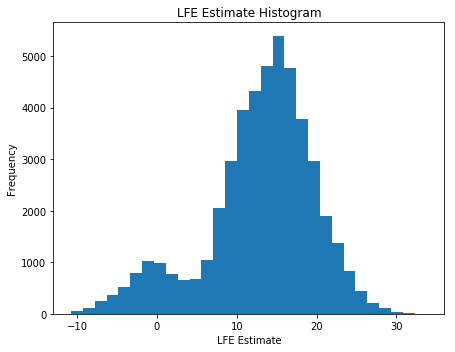

In [1285]:
#Set total figure size
plt.figure(figsize=(12,5))

# Plot Basic Histogram for LFe  and BFE Diff
plt.subplot(121)
plt.hist(three_way.LFE_est, bins = 30)

# Formatting
plt.xlabel("LFE Estimate",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("LFE Estimate Histogram",fontsize=12)
#plt.ylim(0,100)
#plt.xlim(0,100)

plt.tight_layout()

In [1302]:
testing.to_csv("datagraph.csv")

In [1286]:

testing = testing[testing['LFE_est'] > 0]

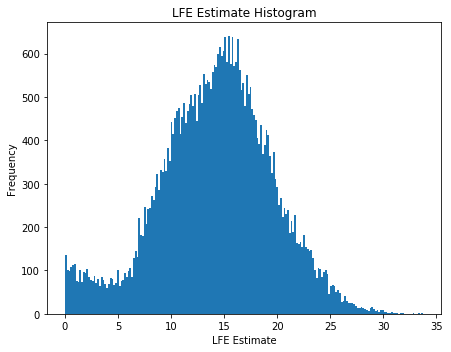

In [1287]:
#Set total figure size
plt.figure(figsize=(12,5))

# Plot Basic Histogram for LFe  and BFE Diff
plt.subplot(121)
plt.hist(testing.LFE_est, bins = 200)

# Formatting
plt.xlabel("LFE Estimate",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("LFE Estimate Histogram",fontsize=12)
#plt.ylim(0,100)
#plt.xlim(0,100)

plt.tight_layout()

AttributeError: 'GeoDataFrame' object has no attribute 'BFE_LFEest_diff'

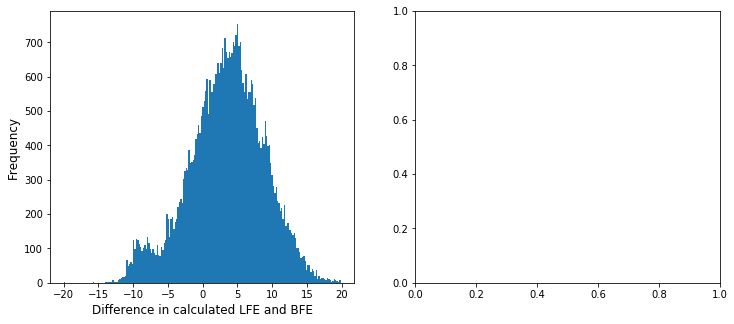

In [1310]:
#Set total figure size
plt.figure(figsize=(12,5))

# Plot Basic Histogram for LFe  and BFE Diff
plt.subplot(121)
plt.hist(testing.BFE_LFEest_diff, bins = 200)

# Formatting
plt.xlabel("Difference in calculated LFE and BFE",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
#plt.title("Difference in  calculated LFE and BFE",fontsize=12)
#plt.ylim(0,100)
#plt.xlim(0,100)

# Plot Histogram for LFE and BFE Diff 
plt.subplot(122)
plt.hist(testing.BFE_LFEest_diff[(three_way.BFE_LFEest_diff>-30) & (three_way.BFE_LFEest_diff<30)], bins = 200)

# Formatting
plt.xlabel("Difference in  BFE and calcculated LFE)",fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.title("Histogram of difference between Estimated LFE and BFE",fontsize=12)


plt.tight_layout()

In [1295]:
testing.count()

cnstrct_yr                 43759
date_lstmo                 43759
bin                        43759
groundelev                 43759
heightroof                 43759
bbl                        43759
FLD_AR_ID                  43759
FLD_ZONE                   43759
STATIC_BFE                 43759
Bin #                       1535
Job Type                    1535
Job Status Descrp           1535
Latest Action Date          1535
Building Type               1535
City Owned                    42
Other Description            984
Approved                     130
ExistingNo. of Stories      1535
Proposed No. of Stories     1535
Existing Height             1535
Proposed Height             1535
Existing Dwelling Units     1297
Proposed Dwelling Units     1353
Existing Occupancy          1297
Proposed Occupancy          1353
Job Description             1535
BBL_x                       1535
Borough                    43759
CD                         43759
CT2010                     43759
          

In [1301]:
testing.BFE_LFEest_diff[(three_way.BFE_LFEest_diff>=5) & (three_way.BFE_LFEest_diff<30)].count()

17394

[]

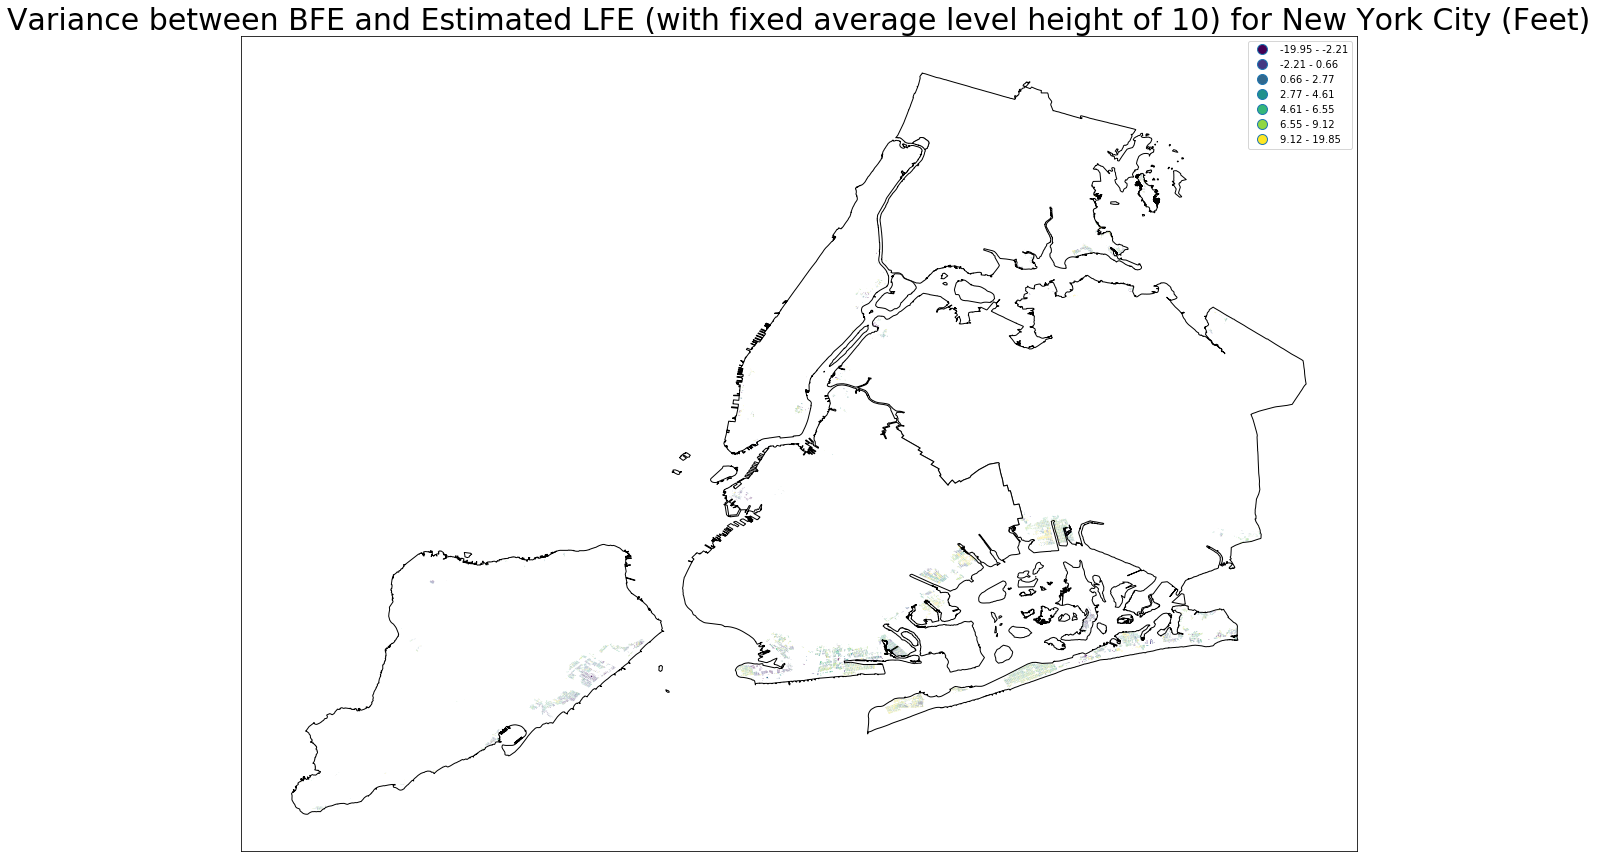

In [1293]:
# Plot Figure with base plot
fig,ax = plt.subplots(figsize=(20,15))
base = baseboro.plot(color='white',edgecolor='black', ax=ax)
testing.plot(column='BFE_LFEest_diff',cmap='viridis',scheme='Quantiles',k=7,legend=True,ax=ax)

# Format Plot
plt.title('Variance between BFE and Estimated LFE (with fixed average level height of 10) for New York City (Feet)',fontsize=30)
ax.set_xticks([])
ax.set_yticks([])

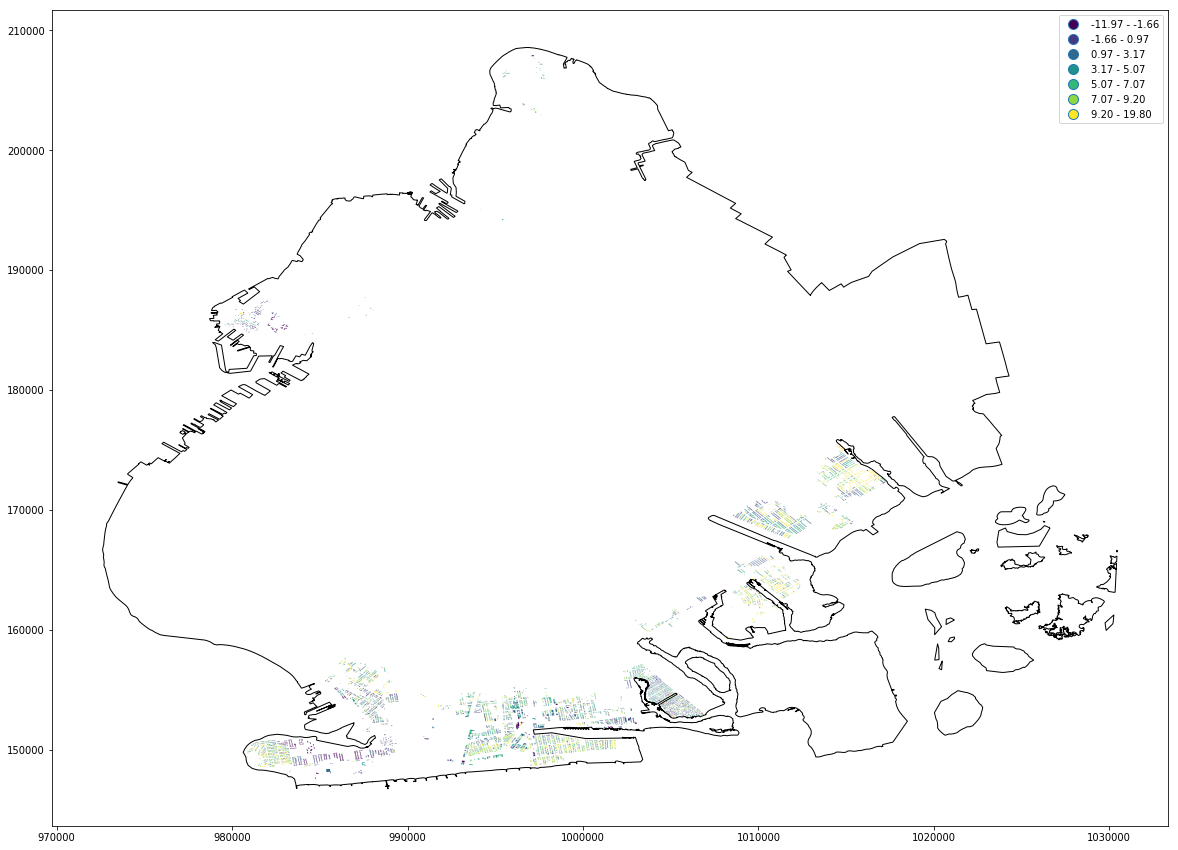

In [1290]:
fig,ax = plt.subplots(figsize=(20,15))

base = baseboro[baseboro['BoroCode']==3].plot(color='white',edgecolor='black', ax=ax)
testing[(testing['Borough']=='BK')].plot(column='BFE_LFEest_diff',cmap='viridis',scheme='Quantiles',k=7,legend=True,ax=ax)


In [1172]:
three_way.columns

Index([u'Unnamed: 0', u'cnstrct_yr', u'date_lstmo', u'bin', u'groundelev',
       u'heightroof', u'bbl', u'geometry', u'FLD_AR_ID', u'FLD_ZONE',
       u'STATIC_BFE', u'Bin #', u'Job Type', u'Job Status Descrp',
       u'Latest Action Date', u'Building Type', u'City Owned',
       u'Other Description', u'Approved', u'ExistingNo. of Stories',
       u'Proposed No. of Stories', u'Existing Height', u'Proposed Height',
       u'Existing Dwelling Units', u'Proposed Dwelling Units',
       u'Existing Occupancy', u'Proposed Occupancy', u'Job Description',
       u'BBL_x', u'Borough', u'CD', u'CT2010', u'CB2010', u'ZoneDist1',
       u'ZoneDist2', u'ZoneDist3', u'ZoneDist4', u'LtdHeight', u'SplitZone',
       u'BldgClass', u'LandUse', u'LotArea', u'BldgArea', u'ComArea',
       u'ResArea', u'OfficeArea', u'RetailArea', u'GarageArea', u'StrgeArea',
       u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs', u'NumFloors',
       u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', u'BldgFro